# 환경설정

In [38]:
import re
import gc
import sys
import ast
import shap
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import dataframe_image as dfi
import statsmodels.api as sm

from imblearn.combine import SMOTETomek
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from flaml import AutoML
from sklearn.linear_model import LogisticRegression
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [3]:
import warnings    
warnings.filterwarnings("ignore")

In [4]:
# 1. 폰트 경로와 폰트 이름 설정
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = 'Apple SD Gothic Neo'

# 2. 폰트 설정
plt.rc('font', family=font_name)

# 3. 폰트 등록 (한글 깨짐 방지)
fm.fontManager.addfont(font_path)

# 4. 마이너스 기호가 깨지지 않도록 설정
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 준비

## 1.1 데이터 불러오기

In [4]:
# 데이터 불러오기
# 3일 체험 신청 (유저id, 3일체험신청일시)
trial_register = pd.read_csv('data/trial_register.csv')

# 3일체험 신청자 일자별 방문기록 (유저id, 날짜, 지점id, 최초입실시각, 최종퇴실시각, 체류시간)
trial_visit_info = pd.read_csv('data/trial_visit_info.csv')

# 3일체험 신청자 출입기록 (유저id, 지점id, timestamp, 출입방향)
trial_access_log = pd.read_csv('data/trial_access_log.csv')

# 3일체험 신청자 결제 여부 (유저id, 결제여부)
trial_payment = pd.read_csv('data/trial_payment.csv')

### 1.1.1 3일 체험 신청 데이터

In [5]:
trial_register.head()

,trial_date,user_uuid
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0


In [6]:
print("데이터 형태: ", trial_register.shape)
print("열 이름: \n", trial_register.columns)

데이터 형태:  (9659, 2)
열 이름: 
 Index(['trial_date', 'user_uuid'], dtype='object')


In [7]:
print("데이터 정보")
trial_register.info()

데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


- `trial_date`는 날짜이므로 `datetime` 타입으로 변환합니다.

In [8]:
# 데이터 타입 변환
trial_register['trial_date'] = pd.to_datetime(trial_register['trial_date'])
trial_register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trial_date  9659 non-null   datetime64[ns]
 1   user_uuid   9659 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 151.1+ KB


In [9]:
# 데이터 확인
trial_register.head()

,trial_date,user_uuid
0,2023-12-21,2b251333-8676-4c11-a736-dcf2350f8821
1,2023-12-21,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,2023-12-21,4a184795-b056-4572-a874-644f68609ea3
3,2023-12-21,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,2023-12-21,1d49ba36-6c23-405b-9514-aa7f4aeceff0


### 1.1.2 3일체험 신청자 일자별 방문기록 데이터

In [10]:
trial_visit_info.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
0,1,2023-12-23,01:11:19.983486,4279,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73
1,1,2023-12-24,04:35:10.361341,16510,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73
2,1,2023-12-25,02:09:54.117163,7794,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73
3,1,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594
4,3,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594


In [11]:
print("데이터 형태: ", trial_visit_info.shape)
print("열 이름: \n", trial_visit_info.columns)

데이터 형태:  (11477, 7)
열 이름: 
 Index(['site_id', 'date', 'stay_time', 'stay_time_second', 'first_enter_time',
       'last_leave_time', 'user_uuid'],
      dtype='object')


In [12]:
print("데이터 정보")
trial_visit_info.info()

데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           11477 non-null  int64 
 1   date              11477 non-null  object
 2   stay_time         11477 non-null  object
 3   stay_time_second  11477 non-null  int64 
 4   first_enter_time  10922 non-null  object
 5   last_leave_time   10922 non-null  object
 6   user_uuid         11477 non-null  object
dtypes: int64(2), object(5)
memory usage: 627.8+ KB


In [13]:
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])

# site_id별 가장 이른 날짜 추출
earliest_dates = trial_visit_info.groupby('site_id')['date'].min().reset_index()

# 결과 출력
print(earliest_dates)

   site_id       date
0        1 2021-05-03
1        2 2021-05-06
2        3 2021-05-02
3        4 2021-05-12
4        5 2021-09-03
5        6 2021-11-15
6       17 2022-08-08
7       47 2022-12-09
8       49 2023-04-22


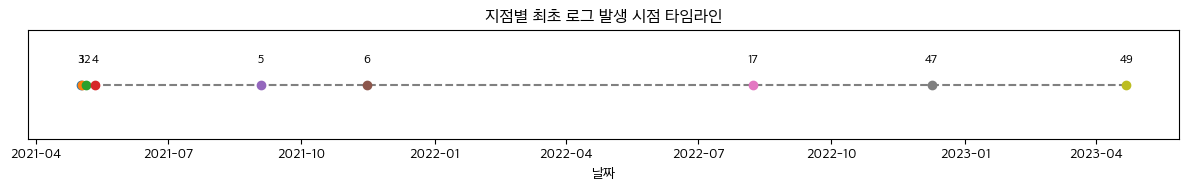

In [14]:
# 데이터 정렬
earliest_dates_sorted = earliest_dates.sort_values('date')

# 시각화
plt.figure(figsize=(12, 2))
plt.hlines(y=1, xmin=earliest_dates_sorted['date'].min(), xmax=earliest_dates_sorted['date'].max(), color='gray', linestyles='dashed')

# 이벤트 점 찍기
for idx, row in earliest_dates_sorted.iterrows():
    plt.plot(row['date'], 1, 'o', label=f"Site {row['site_id']}")
    plt.text(row['date'], 1.02, f"{row['site_id']}", ha='center', va='bottom', fontsize=9)

plt.yticks([])
plt.title("지점별 최초 로그 발생 시점 타임라인")
plt.xlabel("날짜")
plt.tight_layout()
plt.show()

- 본 분석에서는 `site_id`를 이용하지 않으므로 제거
    - 지점에 대한 정보가 "평수"밖에 없으며, 지점별로 로그가 쌓인 기간이 상이하게 다름
- `first_enter_time`과 `last_leave_time`에 결측치 발견, 추후 처리 필요
- `date`, `first_enter_time`, `last_leave_time`은 `datetime` 타입으로 변환 필요
- `stay_time`은 `stay_time_second`와 같은 정보를 담고 있으므로 제거
- `stay_time_second`의 초는 너무 세밀한 정보를 담고 있으므로, 시간으로 변환 후 제거 -> `stay_time_hour`

In [15]:
# site_id 제거
trial_visit_info = trial_visit_info.drop(columns=['site_id'])

# 데이터 타입 변환
trial_visit_info['date'] = pd.to_datetime(trial_visit_info['date'])
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'], errors='coerce')
trial_visit_info['last_leave_time'] = pd.to_datetime(trial_visit_info['last_leave_time'], errors='coerce')

# 1. stay_time 컬럼 제거
trial_visit_info = trial_visit_info.drop(columns=['stay_time'])

# 2. stay_time_second → stay_time_hour (정수형, 반올림)
trial_visit_info['stay_time_hour'] = (trial_visit_info['stay_time_second'] / 3600).round().astype(int)

# 3. stay_time_second 제거
trial_visit_info = trial_visit_info.drop(columns=['stay_time_second'])

trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              11477 non-null  datetime64[ns]
 1   first_enter_time  10124 non-null  datetime64[ns]
 2   last_leave_time   10147 non-null  datetime64[ns]
 3   user_uuid         11477 non-null  object        
 4   stay_time_hour    11477 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 448.4+ KB


In [16]:
# 데이터 확인
trial_visit_info.head()

,date,first_enter_time,last_leave_time,user_uuid,stay_time_hour
0,2023-12-23,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,1
1,2023-12-24,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,5
2,2023-12-25,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,2
3,2023-12-23,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,5
4,2023-12-26,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,5


### 3일체험 신청자 출입기록 데이터

In [17]:
# 데이터 확인
trial_access_log.head()

,id,checkin,cdate,site_id,user_uuid
0,1719038,1,2023-07-07 07:11:55.201673,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
1,1716702,2,2023-07-06 15:15:58.761284,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
2,1719956,2,2023-07-07 14:10:41.848998,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
3,1716588,1,2023-07-06 13:09:48.758097,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
4,1719649,1,2023-07-07 10:12:42.083352,49,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89


In [18]:
print("데이터 형태: ", trial_access_log.shape)
print("열 이름: \n", trial_access_log.columns)

데이터 형태:  (63708, 5)
열 이름: 
 Index(['id', 'checkin', 'cdate', 'site_id', 'user_uuid'], dtype='object')


In [19]:
print("데이터 정보")
trial_access_log.info()

데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         63708 non-null  int64 
 1   checkin    63708 non-null  int64 
 2   cdate      63708 non-null  object
 3   site_id    63708 non-null  int64 
 4   user_uuid  63708 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.4+ MB


- `id`, `site_id`는 본 분석에서 사용하지 않으므로 제거
- `cdate`는 `datetime`(KST)로 변환 필요

In [20]:
# id, site_id 제거
trial_access_log = trial_access_log.drop(columns=['id', 'site_id'])

# cdate → datetime 변환 + KST로 변환 후, 타임존 제거
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'], utc=True) \
                               .dt.tz_convert('Asia/Seoul') \
                               .dt.tz_localize(None)

# 확인
trial_access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   checkin    63708 non-null  int64         
 1   cdate      63708 non-null  datetime64[ns]
 2   user_uuid  63708 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.5+ MB


In [21]:
# 데이터 확인
trial_access_log.head()

,checkin,cdate,user_uuid
0,1,2023-07-07 16:11:55.201673,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
1,2,2023-07-07 00:15:58.761284,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
2,2,2023-07-07 23:10:41.848998,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
3,1,2023-07-06 22:09:48.758097,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89
4,1,2023-07-07 19:12:42.083352,cacd0adb-2c87-450f-8a00-2b2ea6b8fa89


### 3일체험 신청자 결제 여부 데이터

In [22]:
# 데이터 확인
trial_payment.head()

,is_payment,user_uuid
0,0,2b251333-8676-4c11-a736-dcf2350f8821
1,0,e111619a-0975-451b-9a4a-bc8aea7b7b84
2,1,4a184795-b056-4572-a874-644f68609ea3
3,0,2ba8ab19-2d40-4423-ad04-f0f9ca814871
4,0,1d49ba36-6c23-405b-9514-aa7f4aeceff0


In [23]:
print("데이터 형태: ", trial_payment.shape)
print("열 이름: \n", trial_payment.columns)

데이터 형태:  (9659, 2)
열 이름: 
 Index(['is_payment', 'user_uuid'], dtype='object')


In [24]:
print("데이터 정보")
trial_payment.info()

데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   is_payment  9659 non-null   int64 
 1   user_uuid   9659 non-null   object
dtypes: int64(1), object(1)
memory usage: 151.1+ KB


- 별도의 처리 필요 없음.

## 1.2 결측치 처리

### 1.2.1 방문기록 내 최초입실시각 / 최종퇴실시각의 결측치

- `trial_visit_info`의 `first_enter_time`, `last_leave_time` 열에서 결측치가 각각 555건씩 발생했으므로 결측치를 처리합니다.
- 데이터 제공자의 설명에 따르면, 이는 "`stay_time`은 결측치가 없는데, `first_enter_time` 혹은 `last_leave_time`이 결측치인 경우"에 해당합니다.
- 결측치 발생 원인은 "최초 입실 / 최종 퇴실을 할 때 앞에 분에 따라 들어오는 경우가 있어서 기록이 남지 않는 경우"라고 합니다.

In [25]:
# 전체 행 수
total_rows = len(trial_visit_info)

# 각 열의 결측치 비율 계산
first_enter_na_ratio = trial_visit_info['first_enter_time'].isna().sum() / total_rows
last_leave_na_ratio = trial_visit_info['last_leave_time'].isna().sum() / total_rows

# 결과 출력
print(f"first_enter_time 결측치 비율: {first_enter_na_ratio:.4f}")
print(f"last_leave_time  결측치 비율: {last_leave_na_ratio:.4f}")

# 결측치가 있는 행 추출 및 표시
missing_rows = trial_visit_info[
    trial_visit_info['first_enter_time'].isna() | trial_visit_info['last_leave_time'].isna()
]

print(f"\n⚠️ 결측치 포함 행 수: {len(missing_rows)}")
display(missing_rows.head(10))  # 필요에 따라 전체 출력 가능

first_enter_time 결측치 비율: 0.1179
last_leave_time  결측치 비율: 0.1159

⚠️ 결측치 포함 행 수: 2001


,date,first_enter_time,last_leave_time,user_uuid,stay_time_hour
18,2023-12-27,NaT,2023-12-27 15:46:08.599449,b159d9f8-9a5e-4602-b251-8a8e95305da5,1
55,2023-12-30,2023-12-30 22:05:32.822669,NaT,a806f6d6-4bea-40df-b870-212859386e9d,2
56,2023-12-31,NaT,2023-12-31 00:30:23.216706,a806f6d6-4bea-40df-b870-212859386e9d,0
86,2023-12-29,NaT,2023-12-29 15:26:42.106259,f70fa4ed-8364-499c-8c49-6d232e6c271b,15
104,2023-12-21,NaT,2023-12-21 13:48:44.547279,4df43903-b549-405f-90e2-aa769c301ba9,7
105,2023-12-20,2023-12-20 22:17:58.538983,NaT,4df43903-b549-405f-90e2-aa769c301ba9,2
123,2023-12-27,2023-12-27 22:06:43.013016,NaT,868bd6d8-a092-4e16-8974-87c11ac0e357,2
124,2023-12-28,NaT,2023-12-28 00:04:29.487973,868bd6d8-a092-4e16-8974-87c11ac0e357,0
129,2023-12-29,2023-12-29 12:39:05.814511,NaT,fa06b23d-3a20-448f-8791-557beff8df9f,11
130,2023-12-30,NaT,2023-12-30 20:38:07.472557,fa06b23d-3a20-448f-8791-557beff8df9f,20


- 두 열 모두 결측치가 11% 이상으로 적지 않지만, 분석의 신뢰성을 위해 제거합니다.

In [26]:
# 전체 데이터 수
total_rows = len(trial_visit_info)

# 제거 대상: 두 열 중 하나라도 결측인 경우
missing_mask = trial_visit_info['first_enter_time'].isna() | trial_visit_info['last_leave_time'].isna()
num_missing = missing_mask.sum()
num_remaining = total_rows - num_missing
missing_ratio = num_missing / total_rows

# 출력
print(f"총 행 수: {total_rows}")
print(f"제거될 행 수: {num_missing}")
print(f"제거 후 남는 행 수: {num_remaining}")
print(f"제거 비율: {missing_ratio:.2%}")

총 행 수: 11477
제거될 행 수: 2001
제거 후 남는 행 수: 9476
제거 비율: 17.43%


In [27]:
# 결측 제거 후 데이터프레임
trial_visit_info = trial_visit_info[~missing_mask]
trial_visit_info.shape

(9476, 5)

In [28]:
# 데이터 확인
trial_visit_info.head()

,date,first_enter_time,last_leave_time,user_uuid,stay_time_hour
0,2023-12-23,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,1
1,2023-12-24,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,5
2,2023-12-25,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,2
3,2023-12-23,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,5
4,2023-12-26,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,5


## 1.3 이상치 처리

### 1.3.1 체험 신청 기록 내 중복 신청
데이터 제공자에 따르면, 다음과 같은 경우가 존재한다고 합니다.

> ‘신규 가입자는 딱 1번 3일 체험을 이용할 수 있음’에도 불구하고
> 1) 같은 날 2회 3일 체험을 신청하거나
> 2) 서로 다른 날 2회 3일 체험을 신청한 경우가 존재함

그리고 그 원인은 다음과 같다고 합니다.
 
> 1) **같은 날 2회 3일 체험을 신청한 경우**:
>   - 전산 오류로 인해 직접 현장 매니저들이 임시로 3일 체험할 수 있게 권한 부여를 직접 한 케이스
> 2) **서로 다른 날 2회 3일 체험을 신청한 경우**:
>   - 3일 체험을 신청했는데 방문을 못해서 다른 날에 재신청한 케이스

이상의 경우를 구분하여 다음과 같이 처리할 수 있습니다.
1) **같은 날 2회 3일 체험을 신청한 경우**
    - 이는 전산 오류로 인해 현장 매니저가 임의로 권한을 부여한 사례로,  
    - 사용자의 실제 의도와 무관하게 중복이 발생한 것입니다.  
    - 따라서 **가장 먼저 기록된 신청만 남기고**, 이후 중복 신청은 제거합니다.  
    - → 사용자가 최초로 체험 의사를 밝힌 **진정한 신청 시점**을 대표값으로 간주합니다.
2) **서로 다른 날 2회 3일 체험을 신청한 경우**  
    - 이는 첫 신청 후 실제 방문을 하지 못한 사용자가 의도적으로 재신청한 사례입니다.
    - 두 번째 신청이 발생한 시점에서, 사용자는 이전 신청에 대응되는 방문을 하지 못했다는 것을 알 수 있고, 더 이상 이전 신청은 유효하지 않습니다.
    - 따라서 실제 체험과 이어질 수 있는 마지막 신청만 남기고 이전 신청들은 모두 제거합니다.

In [29]:
# 1. 같은 날 중복 신청 기록 추출
dup_same_day = trial_register[trial_register.duplicated(subset=['user_uuid', 'trial_date'], keep=False)]

# 같은 날 중복 신청 사용자 수
same_day_users = dup_same_day['user_uuid'].nunique()

# 중복 제거된 데이터 생성 (각 날짜당 첫 번째만 유지)
dedup_same_day = trial_register.drop_duplicates(subset=['user_uuid', 'trial_date'], keep='first')

In [30]:
# 2. 다른 날 중복 신청 사용자 탐지
user_counts = dedup_same_day['user_uuid'].value_counts()
reapplicant_users = user_counts[user_counts > 1].index

# 다른 날 중복 신청 기록 추출
dup_diff_day = dedup_same_day[dedup_same_day['user_uuid'].isin(reapplicant_users)]

In [31]:
# 3. 결과 출력
print(f"✅ 같은 날 중복 신청 사용자 수: {same_day_users}명")
print(f"✅ 같은 날 중복 신청 기록 수: {len(dup_same_day)}건")
display(dup_same_day.sort_values(['user_uuid', 'trial_date']).head(10))

print(f"\n✅ 다른 날 중복 신청 사용자 수: {len(reapplicant_users)}명")
print(f"✅ 다른 날 중복 신청 기록 수: {len(dup_diff_day)}건")
display(dup_diff_day.sort_values(['user_uuid', 'trial_date']).head(10))

✅ 같은 날 중복 신청 사용자 수: 28명
✅ 같은 날 중복 신청 기록 수: 56건


,trial_date,user_uuid
340,2023-12-11,02458b10-7f2b-4030-950b-ba650ce2fb49
341,2023-12-11,02458b10-7f2b-4030-950b-ba650ce2fb49
132,2023-11-24,039fa563-fc65-4b0c-9087-4beb5cd17fd7
133,2023-11-24,039fa563-fc65-4b0c-9087-4beb5cd17fd7
175,2023-11-27,06e78cdd-c7f0-4b45-af6d-9126125d0686
176,2023-11-27,06e78cdd-c7f0-4b45-af6d-9126125d0686
313,2023-12-09,091cdea5-fc99-47fd-a722-3fe190f9cb26
314,2023-12-09,091cdea5-fc99-47fd-a722-3fe190f9cb26
103,2022-12-27,19c8e329-9654-4178-989d-c93617655650
104,2022-12-27,19c8e329-9654-4178-989d-c93617655650



✅ 다른 날 중복 신청 사용자 수: 7명
✅ 다른 날 중복 신청 기록 수: 14건


,trial_date,user_uuid
5624,2022-01-28,14872783-3af7-492a-b51c-12f3003b76f1
5625,2023-02-10,14872783-3af7-492a-b51c-12f3003b76f1
1682,2021-09-06,4008307f-486f-408f-b90b-e01398972029
1683,2022-03-25,4008307f-486f-408f-b90b-e01398972029
3554,2022-03-14,5b16f32b-3344-4b39-b2bf-8cf1caac78fa
3555,2023-03-22,5b16f32b-3344-4b39-b2bf-8cf1caac78fa
4968,2022-09-05,6a88014b-fbbd-4e73-8036-04435c062a97
4969,2023-02-10,6a88014b-fbbd-4e73-8036-04435c062a97
4674,2022-08-02,bd3ed6c2-f139-4e0c-b53e-b956101b2822
4675,2022-10-21,bd3ed6c2-f139-4e0c-b53e-b956101b2822


In [32]:
# 데이터 확인
trial_register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trial_date  9659 non-null   datetime64[ns]
 1   user_uuid   9659 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 151.1+ KB


### 2. "최종퇴실시각 - 최초입실시각"이 "체류시간"과 다른 경우

데이터 제공자에 따르면, `trial_visit_info` 내에는 다음과 같은 사례가 존재합니다:

> `stay_time_hour`과 `first_enter_time`, `last_leave_time` 간의 시간 차이가 일치하지 않는 경우

이는 이상치라기보다는 두 지표가 **의도적으로 다른 개념을 측정**하기 때문에 발생하는 차이입니다.  
- `first_enter_time`: 최초 입실 시각  
- `last_leave_time`: 최종 퇴실 시각  
- `stay_time_hour`: 실제 체류 시간의 합 (중간 퇴실 시간은 제외됨)

즉, 사용자가 **입실 후 중간에 외출했다 돌아온 경우**,  
`last_leave_time - first_enter_time`은 **총 이용 구간**이고,
이 구간에는 실제 체류하지 않았던 시간(예: 외출 시간)도 포함될 수 있습니다.
`stay_time_hour`은 **실제 머문 시간만 누적한 값**입니다.

따라서 이 둘을 일치시키는 정제는 부적절하며, 두 값을 모두 보존합니다.

In [33]:
# 데이터 확인
trial_visit_info.head()

,date,first_enter_time,last_leave_time,user_uuid,stay_time_hour
0,2023-12-23,2023-12-23 16:11:25.345793,2023-12-23 17:25:32.233995,939fc566-61cd-47f0-a3ce-e2936fdcff73,1
1,2023-12-24,2023-12-24 16:10:45.668026,2023-12-24 20:53:34.842447,939fc566-61cd-47f0-a3ce-e2936fdcff73,5
2,2023-12-25,2023-12-25 10:19:47.087268,2023-12-25 12:39:51.221372,939fc566-61cd-47f0-a3ce-e2936fdcff73,2
3,2023-12-23,2023-12-23 14:49:40.302823,2023-12-23 19:27:39.406803,ba49324f-d317-4053-adf9-2b17b3f07594,5
4,2023-12-26,2023-12-26 14:57:10.220793,2023-12-26 19:34:36.971542,ba49324f-d317-4053-adf9-2b17b3f07594,5


In [34]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9476 entries, 0 to 11475
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              9476 non-null   datetime64[ns]
 1   first_enter_time  9476 non-null   datetime64[ns]
 2   last_leave_time   9476 non-null   datetime64[ns]
 3   user_uuid         9476 non-null   object        
 4   stay_time_hour    9476 non-null   int64         
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 444.2+ KB


### 3. 방문기록 내 4일째 체험 기록

In [35]:
# 1. 사용자별 첫 방문일과 모든 방문일 추출
user_dates = trial_visit_info[['user_uuid', 'date']].drop_duplicates()

# 2. 사용자별 첫 방문일 계산
first_dates = user_dates.groupby('user_uuid')['date'].min().reset_index()
first_dates.columns = ['user_uuid', 'first_date']

# 3. 병합하여 각 방문일이 첫 방문일 기준 며칠 뒤인지 계산
user_dates = user_dates.merge(first_dates, on='user_uuid', how='left')
user_dates['day_offset'] = (user_dates['date'] - user_dates['first_date']).dt.days

# 4. 사용자별로 3일 이내(0,1,2일차)만 방문했는지 여부 판단
max_offset = user_dates.groupby('user_uuid')['day_offset'].max().reset_index()
max_offset.columns = ['user_uuid', 'max_day_offset']
max_offset['within_3_days'] = max_offset['max_day_offset'] <= 2

# 5. 분포 집계
day_limit_dist = max_offset['within_3_days'].value_counts().sort_index().reset_index()
day_limit_dist.columns = ['within_3_days', 'user_count']
total_users_limit = day_limit_dist['user_count'].sum()
day_limit_dist['percent'] = (day_limit_dist['user_count'] / total_users_limit * 100).round(2)

# 6. 출력 (True: 3일 이내 / False: 3일 초과)
display(day_limit_dist)

# 7. 예시 출력: 4일째(3일 offset) 방문 기록이 있는 사용자
user_with_day4 = user_dates[user_dates['day_offset'] == 3]['user_uuid'].unique()
print(f"4일째 방문기록이 있는 유저 수: {len(user_with_day4)}")

# 해당 유저 중 일부의 방문 일자 출력 (예: 상위 5명)
example_day4 = user_dates[user_dates['user_uuid'].isin(user_with_day4)].sort_values(['user_uuid', 'date'])
display(example_day4.head(20))

,within_3_days,user_count,percent
0,False,109,1.88
1,True,5685,98.12


4일째 방문기록이 있는 유저 수: 109


,user_uuid,date,first_date,day_offset
1963,01260e33-69c0-45da-bad1-e21c6e7a82b3,2023-12-14,2023-12-14,0
1964,01260e33-69c0-45da-bad1-e21c6e7a82b3,2023-12-16,2023-12-14,2
1965,01260e33-69c0-45da-bad1-e21c6e7a82b3,2023-12-17,2023-12-14,3
1925,01dab720-a416-4444-94bc-dee7fdbe8bd2,2023-12-11,2023-12-11,0
1923,01dab720-a416-4444-94bc-dee7fdbe8bd2,2023-12-12,2023-12-11,1
1924,01dab720-a416-4444-94bc-dee7fdbe8bd2,2023-12-13,2023-12-11,2
1926,01dab720-a416-4444-94bc-dee7fdbe8bd2,2023-12-14,2023-12-11,3
1935,02458b10-7f2b-4030-950b-ba650ce2fb49,2023-12-11,2023-12-11,0
1934,02458b10-7f2b-4030-950b-ba650ce2fb49,2023-12-13,2023-12-11,2
1936,02458b10-7f2b-4030-950b-ba650ce2fb49,2023-12-14,2023-12-11,3


In [36]:
# 1. 위에서 구한 max_offset을 그대로 사용한다고 가정 (없다면 재생성 필요)
#    max_offset: ['user_uuid', 'max_day_offset', 'within_3_days']

# 2. 3일 초과 사용자만 필터링
over_3_users = max_offset[max_offset['within_3_days'] == False].copy()

# 3. 방문 기간은 day_offset + 1일이므로 이를 계산
over_3_users['visit_duration_days'] = over_3_users['max_day_offset'] + 1

# 4. 분포 집계
over3_dist = over_3_users['visit_duration_days'].value_counts().sort_index().reset_index()
over3_dist.columns = ['visit_duration_days', 'user_count']
total_over3 = over3_dist['user_count'].sum()
over3_dist['percent'] = (over3_dist['user_count'] / total_over3 * 100).round(2)

# 5. 결과 출력
display(over3_dist)

,visit_duration_days,user_count,percent
0,4,109,100.0


In [37]:
# 1. 복사본 생성
access_log = trial_access_log.copy()

# 2. cdate를 datetime으로 변환하고, 날짜만 추출하여 새로운 컬럼으로 저장
access_log['access_date'] = pd.to_datetime(access_log['cdate']).dt.date

# 3. 사용자별 고유한 접속일 수 계산
access_counts = access_log.groupby('user_uuid')['access_date'].nunique().reset_index()
access_counts.columns = ['user_uuid', 'unique_access_days']

# 4. 고유 일수별 사용자 수 집계
access_day_distribution = access_counts['unique_access_days'].value_counts().sort_index().reset_index()
access_day_distribution.columns = ['access_day_count', 'user_count']

# 5. 전체 대비 비율 계산
total_users = len(access_counts)
access_day_distribution['percent'] = (access_day_distribution['user_count'] / total_users * 100).round(2)

# 6. 결과 테이블 출력
display(access_day_distribution)

,access_day_count,user_count,percent
0,1,3391,56.27
1,2,2235,37.09
2,3,400,6.64


In [38]:
# 1. 복사본 생성
access_log = trial_access_log.copy()

# 2. cdate를 datetime으로 변환하고, 날짜만 추출
access_log['access_date'] = pd.to_datetime(access_log['cdate']).dt.date

# 3. 사용자별 첫날과 마지막날 계산
access_date_range = access_log.groupby('user_uuid')['access_date'].agg(['min', 'max']).reset_index()
access_date_range['date_diff_days'] = (access_date_range['max'] - access_date_range['min']).apply(lambda x: x.days)

# 4. 3일 이내 방문 여부 판단
access_date_range['within_3_days'] = access_date_range['date_diff_days'] <= 2  # 기준일 포함하여 3일

# 5. 결과 확인
display(access_date_range[['user_uuid', 'date_diff_days', 'within_3_days']])

,user_uuid,date_diff_days,within_3_days
0,000590dc-046f-462b-8225-4c81a97b7166,0,True
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,1,True
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,1,True
3,002606d9-38ca-48f3-910c-cbfada9a9109,1,True
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,0,True
...,...,...,...
6021,ffc79669-ed11-4cde-86d4-8ec232ac7b14,0,True
6022,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,1,True
6023,ffce32ca-2efc-4485-b685-4b65811c2dcf,0,True
6024,ffd287bc-2797-4788-82fa-6268c82e7fa9,1,True


In [39]:
# 1. 값 개수 계산
within_3_counts = access_date_range['within_3_days'].value_counts().sort_index()

# 2. 비율 계산
within_3_percent = (within_3_counts / within_3_counts.sum() * 100).round(2)

# 3. 결과 테이블 생성
within_3_df = pd.DataFrame({
    'within_3_days': within_3_counts.index.map({False: '> 3일', True: '≤ 3일'}),
    'user_count': within_3_counts.values,
    'percent': within_3_percent.values
})

# 4. 출력
display(within_3_df)

,within_3_days,user_count,percent
0,≤ 3일,6026,100.0


- 체험기간은 3일간으로 정해져 있지만, `trial_visit_info`에 3일 이후의(4일째) 체험 기록이 존재합니다.

- 체험기간이 일수 기준이 아니라 시간(72시간) 기준인지 확인합니다.

In [40]:
# 1. 3일 초과 사용자만 추출
over3_users = max_offset[max_offset['within_3_days'] == False]['user_uuid']

# 2. 해당 유저들의 방문 기록 필터링
over3_visits = trial_visit_info[trial_visit_info['user_uuid'].isin(over3_users)].copy()

# 3. first_enter_time을 datetime으로 변환
over3_visits['first_enter_time'] = pd.to_datetime(over3_visits['first_enter_time'])

# 4. 사용자별 최초 및 최종 입실 시각 구하기
enter_time_range = over3_visits.groupby('user_uuid')['first_enter_time'].agg(['min', 'max']).reset_index()
enter_time_range['enter_diff_hr'] = ((enter_time_range['max'] - enter_time_range['min']).dt.total_seconds() / 3600).round(1)
enter_time_range['within_72_hours'] = enter_time_range['enter_diff_hr'] <= 72

# 5. 열 정리
result_df = enter_time_range[['user_uuid', 'enter_diff_hr', 'within_72_hours']]

# 결과 확인
display(result_df)

,user_uuid,enter_diff_hr,within_72_hours
0,01260e33-69c0-45da-bad1-e21c6e7a82b3,68.8,True
1,01dab720-a416-4444-94bc-dee7fdbe8bd2,72.3,False
2,02458b10-7f2b-4030-950b-ba650ce2fb49,72.1,False
3,05ba4035-9ef6-48a7-a4af-1d829b86ae37,64.9,True
4,06492eb4-8140-4a76-abb2-153e5ed54120,65.6,True
...,...,...,...
104,f0198dcc-2aae-4c83-b166-e2bb72a284e6,76.9,False
105,f346736f-0f1d-4da9-8c2a-497e20b9295c,69.5,True
106,f6d152e1-7263-496f-b261-f3cfec49f64a,72.0,True
107,fbc19d42-097c-447b-b8d4-12d8446a9bca,67.7,True


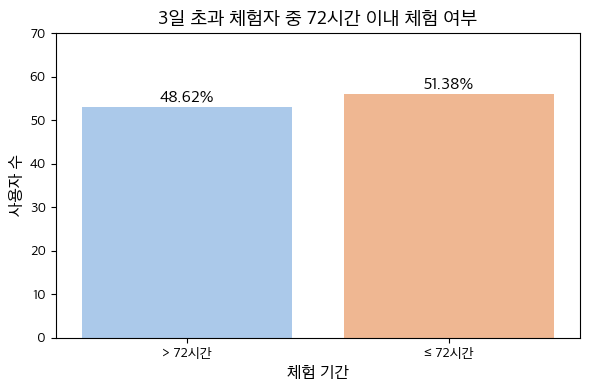

In [41]:
# 1. True / False 비율 계산
within_counts = result_df['within_72_hours'].value_counts().sort_index()
within_percent = (within_counts / within_counts.sum() * 100).round(2)

# 2. 시각화
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=within_percent.index.map({False: '> 72시간', True: '≤ 72시간'}),
                 y=within_counts.values, palette='pastel')

# 3. 텍스트 비율 표시
for i, (count, percent) in enumerate(zip(within_counts.values, within_percent.values)):
    plt.text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=12)

# 4. 꾸미기
plt.ylim(0, within_counts.max() * 1.25)
plt.title('3일 초과 체험자 중 72시간 이내 체험 여부', fontsize=14)
plt.xlabel('체험 기간', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.tight_layout()
plt.show()

- 72시간 이내에 발생하지 않은 4일째 방문도 다수 확인되어, "3일 체험"의 기준이 72시간이라는 근거는 찾을 수 없었습니다.
- 4일째 방문은 전환자들에 국한된 행동패턴(결제 이후 체험 카드 임시 사용)일 수 있으므로, 전환 여부에 따라 다시 검토합니다.

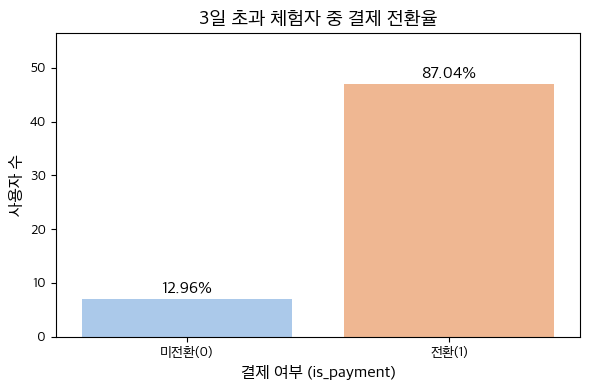

In [42]:
# 1. 결제 여부 병합
result_df = result_df.merge(trial_payment, on='user_uuid', how='left')

# 2. 3일 초과 체험자만 필터링
over_3days = result_df[result_df['within_72_hours'] == False]

# 3. 전환 여부별 사용자 수 및 비율 계산
conversion_counts = over_3days['is_payment'].value_counts().sort_index()
conversion_percent = (conversion_counts / conversion_counts.sum() * 100).round(2)

# 4. 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=conversion_percent.index.map({0: '미전환(0)', 1: '전환(1)'}),
            y=conversion_counts.values,
            palette='pastel')

# 5. 퍼센트 텍스트 추가
for i, (count, percent) in enumerate(zip(conversion_counts.values, conversion_percent.values)):
    plt.text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=12)

# 6. 꾸미기
plt.ylim(0, conversion_counts.max() * 1.2)
plt.title('3일 초과 체험자 중 결제 전환율', fontsize=14)
plt.xlabel('결제 여부 (is_payment)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.tight_layout()
plt.show()

- 4일 방문한 유저 중에는 미전환 유저도 11.67% 있는 것이 확인되었습니다.

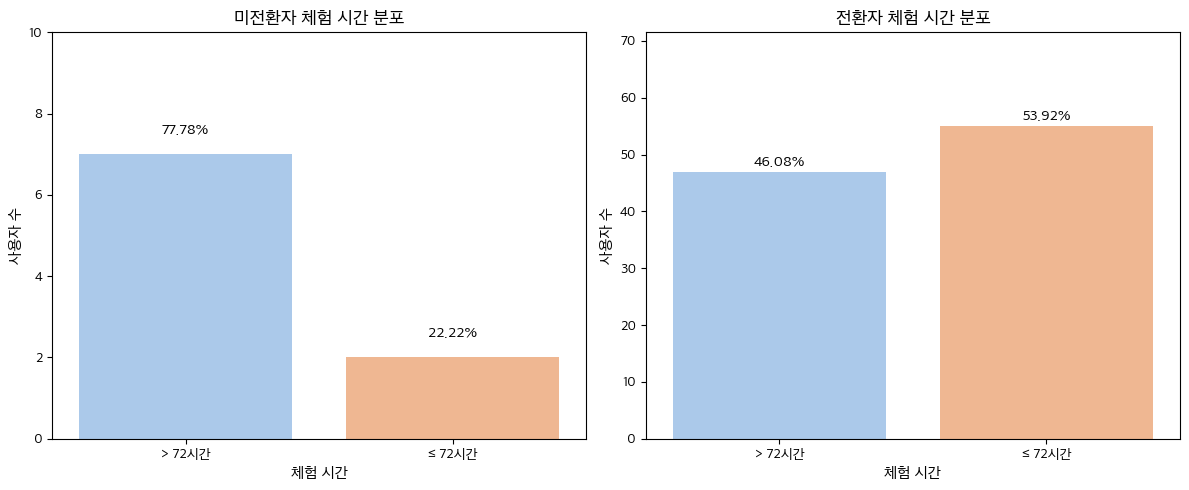

In [43]:
# 1. 전환 여부에 따라 분리
non_converted = result_df[result_df['is_payment'] == 0]
converted = result_df[result_df['is_payment'] == 1]

# 2. 그룹별 비율 계산
non_conv_counts = non_converted['within_72_hours'].value_counts().sort_index()
non_conv_percent = (non_conv_counts / non_conv_counts.sum() * 100).round(2)

conv_counts = converted['within_72_hours'].value_counts().sort_index()
conv_percent = (conv_counts / conv_counts.sum() * 100).round(2)

# 3. 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 3-1. 미전환자
sns.barplot(
    x=non_conv_percent.index.map({False: '> 72시간', True: '≤ 72시간'}),
    y=non_conv_counts.values,
    palette='pastel',
    ax=axes[0]
)
for i, (count, percent) in enumerate(zip(non_conv_counts.values, non_conv_percent.values)):
    axes[0].text(i, count + 0.5, f'{percent:.2f}%', ha='center', fontsize=11)

axes[0].set_title('미전환자 체험 시간 분포', fontsize=13)
axes[0].set_xlabel('체험 시간', fontsize=11)
axes[0].set_ylabel('사용자 수', fontsize=11)
axes[0].set_ylim(0, 10)  # y축 범위 제한

# 3-2. 전환자
sns.barplot(
    x=conv_percent.index.map({False: '> 72시간', True: '≤ 72시간'}),
    y=conv_counts.values,
    palette='pastel',
    ax=axes[1]
)
for i, (count, percent) in enumerate(zip(conv_counts.values, conv_percent.values)):
    axes[1].text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=11)

axes[1].set_title('전환자 체험 시간 분포', fontsize=13)
axes[1].set_xlabel('체험 시간', fontsize=11)
axes[1].set_ylabel('사용자 수', fontsize=11)
axes[1].set_ylim(0, conv_counts.max() * 1.3)

plt.tight_layout()
plt.show()

- 최초 입장 후 72시간이 지나고 4일째 방문이 발생한 비율은 미전환자 쪽이 더 높았습니다.
- `trial_access_log`에는 4일 방문 데이터가 존재하지 않는다는 것은, "3일 체험 기간"은 분명 전산상으로 엄격히 관리되고 있는 것으로 보이는데, `trial_visit_info`에 어째서 4일째 방문 기록이 남아 있고, 4일째 방문이 허용되었는지는 판단하기 어렵습니다.
- 비정상 이용 기록이라고 판단, 4일째 기록은 제거합니다.

In [44]:
# 지우기 전 데이터
trial_visit_info.shape

(9476, 5)

In [45]:
# 1. 날짜 컬럼을 datetime으로 변환하고 date만 추출
trial_visit_info['first_enter_time'] = pd.to_datetime(trial_visit_info['first_enter_time'])
trial_visit_info['visit_date'] = trial_visit_info['first_enter_time'].dt.date

# 2. 사용자별 첫 방문 날짜 계산
first_visit_date = trial_visit_info.groupby('user_uuid')['visit_date'].min().rename('start_date')

# 3. 병합하여 날짜 차이 계산
trial_visit_info = trial_visit_info.merge(first_visit_date, on='user_uuid', how='left')
trial_visit_info['day_diff'] = (trial_visit_info['visit_date'] - trial_visit_info['start_date']).apply(lambda x: x.days)

# ✅ [1단계] 3일 이후(day_diff > 2) 방문 중 하루에 2회 이상 방문한 사용자만 출력
over3day = trial_visit_info[trial_visit_info['day_diff'] > 2]
duplicated_users = over3day['user_uuid'].value_counts()
duplicated_users = duplicated_users[duplicated_users > 1].index
duplicated_records = over3day[over3day['user_uuid'].isin(duplicated_users)]

# 출력
display(duplicated_records)

# ✅ [2단계] 전체 데이터에서 3일 이후 방문 기록 제거 (즉, day_diff > 2 제거)
trial_visit_info = trial_visit_info[trial_visit_info['day_diff'] <= 2].reset_index(drop=True)

# 정리
trial_visit_info = trial_visit_info.drop(columns=['visit_date', 'start_date', 'day_diff'])

,date,first_enter_time,last_leave_time,user_uuid,stay_time_hour,visit_date,start_date,day_diff
1457,2023-04-06,2023-04-06 07:06:24.880463,2023-04-06 11:59:55.164340,3c793cb0-a6d1-42a2-89fb-2553a19f5ae8,5,2023-04-06,2023-04-03,3
1460,2023-04-06,2023-04-06 14:03:28.685090,2023-04-06 14:38:11.659703,3c793cb0-a6d1-42a2-89fb-2553a19f5ae8,1,2023-04-06,2023-04-03,3
1655,2023-11-11,2023-11-11 18:41:16.628998,2023-11-11 22:26:14.548792,5f07d159-1aa3-4666-a013-d51aefcbbc79,4,2023-11-11,2023-11-08,3
1656,2023-11-11,2023-11-11 13:23:23.266460,2023-11-11 17:03:16.464729,5f07d159-1aa3-4666-a013-d51aefcbbc79,3,2023-11-11,2023-11-08,3
2002,2023-12-14,2023-12-14 19:41:49.902190,2023-12-14 21:00:36.422923,02458b10-7f2b-4030-950b-ba650ce2fb49,1,2023-12-14,2023-12-11,3
2003,2023-12-14,2023-12-14 19:41:49.902190,2023-12-14 21:00:36.422923,02458b10-7f2b-4030-950b-ba650ce2fb49,1,2023-12-14,2023-12-11,3
2131,2023-04-28,2023-04-28 14:22:35.321988,2023-04-28 15:21:38.742446,6986a5ec-b02b-43e9-a722-be8cebc85c1a,1,2023-04-28,2023-04-25,3
2132,2023-04-28,2023-04-28 15:51:59.184069,2023-04-28 17:01:10.009861,6986a5ec-b02b-43e9-a722-be8cebc85c1a,1,2023-04-28,2023-04-25,3
2133,2023-04-28,2023-04-28 10:36:08.508621,2023-04-28 12:01:41.229520,6986a5ec-b02b-43e9-a722-be8cebc85c1a,1,2023-04-28,2023-04-25,3


In [46]:
# 데이터 확인
trial_visit_info.shape

(9362, 5)

- 109명의 4일째 방문 데이터 114건이 지워졌습니다. (4일째에 2회 방문 유저 3명, 3회 방문 유저 1명 존재)

### 1.3.4 방문기록과 출입기록의 불일치

In [47]:
# 1. 복사본 생성
access_log = trial_access_log.copy()
visit_info = trial_visit_info.copy()

# 2. cdate → datetime 변환 및 날짜 추출
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date

# 3. checkin == 1 → 최초 입장 시각
first_checkin = access_log[access_log['checkin'] == 1] \
    .groupby(['user_uuid', 'date'])['cdate'].min().reset_index()
first_checkin.columns = ['user_uuid', 'date', 'first_checkin_time']

# 4. checkin == 2 → 마지막 퇴장 시각
last_checkout = access_log[access_log['checkin'] == 2] \
    .groupby(['user_uuid', 'date'])['cdate'].max().reset_index()
last_checkout.columns = ['user_uuid', 'date', 'last_checkout_time']

# 5. visit_info의 날짜 정제
visit_info['date'] = pd.to_datetime(visit_info['date']).dt.date

# 6. 병합
merged = visit_info.merge(first_checkin, on=['user_uuid', 'date'], how='left') \
                   .merge(last_checkout, on=['user_uuid', 'date'], how='left')

# 7. 시각 비교 (분 단위까지만 비교)
merged['first_enter_match'] = pd.to_datetime(merged['first_enter_time']).dt.floor('min') == \
                              pd.to_datetime(merged['first_checkin_time']).dt.floor('min')

merged['last_leave_match'] = pd.to_datetime(merged['last_leave_time']).dt.floor('min') == \
                             pd.to_datetime(merged['last_checkout_time']).dt.floor('min')

# 8. 결과 확인
comparison_result = merged[[
    'user_uuid', 'date',
    'first_enter_time', 'first_checkin_time', 'first_enter_match',
    'last_leave_time', 'last_checkout_time', 'last_leave_match'
]]

comparison_result.head()

,user_uuid,date,first_enter_time,first_checkin_time,first_enter_match,last_leave_time,last_checkout_time,last_leave_match
0,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,2023-12-23 16:11:25.345793,2023-12-23 16:11:25.888624,True,2023-12-23 17:25:32.233995,2023-12-23 17:25:32.797735,True
1,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-24,2023-12-24 16:10:45.668026,2023-12-24 16:10:46.214942,True,2023-12-24 20:53:34.842447,2023-12-24 20:53:35.456099,True
2,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-25,2023-12-25 10:19:47.087268,2023-12-25 10:19:47.690764,True,2023-12-25 12:39:51.221372,2023-12-25 12:39:51.728980,True
3,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,2023-12-23 14:49:40.302823,2023-12-23 14:49:40.844597,True,2023-12-23 19:27:39.406803,2023-12-23 19:27:40.007304,True
4,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-25,2023-12-25 14:38:26.896366,2023-12-25 14:38:27.480359,True,2023-12-25 20:29:58.172946,2023-12-25 20:29:58.740380,True


In [48]:
# first_enter_match 또는 last_leave_match가 False인 행만 필터링
mismatched_rows = comparison_result[
    (comparison_result['first_enter_match'] == False) |
    (comparison_result['last_leave_match'] == False)
]

# 결과 확인
display(mismatched_rows)

,user_uuid,date,first_enter_time,first_checkin_time,first_enter_match,last_leave_time,last_checkout_time,last_leave_match
31,34d68334-ee08-4a87-8879-9320746a52d9,2023-12-25,2023-12-25 20:00:56.885960,2023-12-25 20:08:49.612802,False,2023-12-25 22:24:14.133274,2023-12-25 22:24:14.637381,True
45,963a0a40-9499-4e30-a321-9feda7c6221f,2023-12-29,2023-12-29 11:38:59.540143,2023-12-29 11:39:00.061821,False,2023-12-29 21:08:45.247783,2023-12-29 21:08:45.789435,True
54,3fb96714-db4d-4896-b821-df6fc1d93fe5,2024-01-01,2024-01-01 17:52:32.264924,NaT,False,2024-01-01 18:50:14.547251,NaT,False
58,418edd26-c1c1-49f6-b67f-3b29c3e868e9,2024-01-02,2024-01-02 19:37:50.345305,NaT,False,2024-01-02 20:20:08.337566,NaT,False
87,6861f386-6914-4ba2-b6b2-ffc88f5cc661,2023-12-24,2023-12-24 16:42:28.354497,2023-12-24 16:42:28.900005,True,2023-12-24 18:34:59.491755,2023-12-24 18:35:00.020432,False
...,...,...,...,...,...,...,...,...
9346,d7013b60-95fd-472a-9283-3196e93f6ea6,2022-06-13,2022-06-13 20:35:33.912555,NaT,False,2022-06-13 23:18:04.461268,NaT,False
9351,ee19e504-ed45-47c1-9901-281194d77df2,2022-09-07,2022-09-07 11:05:45.614091,2022-09-07 11:05:46.206550,True,2022-09-07 18:42:59.950126,2022-09-07 18:43:01.573279,False
9352,1575d09e-c799-4529-9115-e2ae9ae46b0d,2023-01-09,2023-01-09 10:41:47.670501,NaT,False,2023-01-09 17:29:13.887330,NaT,False
9357,766221e7-a753-444f-aa5a-ae76ce86d3fd,2022-06-18,2022-06-18 15:14:52.844471,NaT,False,2022-06-18 17:51:56.463097,NaT,False


In [49]:
# 1. 전체 일치율 계산
first_enter_accuracy = comparison_result['first_enter_match'].mean() * 100
last_leave_accuracy = comparison_result['last_leave_match'].mean() * 100

# 2. 동시에 둘 다 일치한 비율
both_match_accuracy = (
    (comparison_result['first_enter_match'] & comparison_result['last_leave_match']).mean() * 100
)

# 3. 요약 출력
print("✅ 입장 시각 일치율: {:.2f}%".format(first_enter_accuracy))
print("✅ 퇴장 시각 일치율: {:.2f}%".format(last_leave_accuracy))
print("✅ 입장·퇴장 모두 일치한 비율: {:.2f}%".format(both_match_accuracy))

✅ 입장 시각 일치율: 78.30%
✅ 퇴장 시각 일치율: 78.43%
✅ 입장·퇴장 모두 일치한 비율: 76.63%


- 기준을 완화하여, 최초입실/최종퇴실 시간을 기준으로 ±1분의 체크인/체크아웃 기록과 비교합니다.

In [50]:
# 1. 복사본 생성
access_log = trial_access_log.copy()
visit_info = trial_visit_info.copy()

# 2. datetime 처리 및 날짜 컬럼 생성
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date
visit_info['date'] = pd.to_datetime(visit_info['date']).dt.date
visit_info['first_enter_time'] = pd.to_datetime(visit_info['first_enter_time'])
visit_info['last_leave_time'] = pd.to_datetime(visit_info['last_leave_time'])

# 3. 입장 / 퇴장 기록 분리
all_checkin = access_log[access_log['checkin'] == 1][['user_uuid', 'cdate']].copy()
all_checkout = access_log[access_log['checkin'] == 2][['user_uuid', 'cdate']].copy()

# 4. ±1분 이내 일치 여부 판단 함수 (명확히 기준 컬럼 전달)
def is_within_1min(row, df, df_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][df_col]
    if user_times.empty:
        return False
    return ((user_times - row[ref_col]).abs() <= pd.Timedelta(minutes=1)).any()

# 5. match 여부 적용
visit_info['first_enter_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_leave_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 6. 가장 가까운 실제 시각 보정 함수
def get_closest_time(row, df, time_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][time_col]
    if user_times.empty:
        return pd.NaT
    return user_times.iloc[(user_times - row[ref_col]).abs().argsort().iloc[0]]

# 7. 실제 시각 보정 적용
visit_info['first_checkin_time'] = visit_info.apply(
    lambda row: row['first_enter_time'] if row['first_enter_match']
    else get_closest_time(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_checkout_time'] = visit_info.apply(
    lambda row: row['last_leave_time'] if row['last_leave_match']
    else get_closest_time(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 8. 최종 비교 결과 출력
comparison_result = visit_info[[
    'user_uuid', 'date',
    'first_enter_time', 'first_checkin_time', 'first_enter_match',
    'last_leave_time', 'last_checkout_time', 'last_leave_match'
]]

# 결과 확인
display(comparison_result.head())

,user_uuid,date,first_enter_time,first_checkin_time,first_enter_match,last_leave_time,last_checkout_time,last_leave_match
0,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,2023-12-23 16:11:25.345793,2023-12-23 16:11:25.345793,True,2023-12-23 17:25:32.233995,2023-12-23 17:25:32.233995,True
1,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-24,2023-12-24 16:10:45.668026,2023-12-24 16:10:45.668026,True,2023-12-24 20:53:34.842447,2023-12-24 20:53:34.842447,True
2,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-25,2023-12-25 10:19:47.087268,2023-12-25 10:19:47.087268,True,2023-12-25 12:39:51.221372,2023-12-25 12:39:51.221372,True
3,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,2023-12-23 14:49:40.302823,2023-12-23 14:49:40.302823,True,2023-12-23 19:27:39.406803,2023-12-23 19:27:39.406803,True
4,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-25,2023-12-25 14:38:26.896366,2023-12-25 14:38:26.896366,True,2023-12-25 20:29:58.172946,2023-12-25 20:29:58.172946,True


In [51]:
# first_enter_match 또는 last_leave_match가 False인 행만 필터링
mismatched_rows = comparison_result[
    (comparison_result['first_enter_match'] == False) |
    (comparison_result['last_leave_match'] == False)
]

# 결과 확인
display(mismatched_rows)

,user_uuid,date,first_enter_time,first_checkin_time,first_enter_match,last_leave_time,last_checkout_time,last_leave_match
31,34d68334-ee08-4a87-8879-9320746a52d9,2023-12-25,2023-12-25 20:00:56.885960,2023-12-25 20:08:49.612802,False,2023-12-25 22:24:14.133274,2023-12-25 22:24:14.133274,True
54,3fb96714-db4d-4896-b821-df6fc1d93fe5,2024-01-01,2024-01-01 17:52:32.264924,2023-12-31 23:24:59.867903,False,2024-01-01 18:50:14.547251,2023-12-31 23:25:56.774039,False
58,418edd26-c1c1-49f6-b67f-3b29c3e868e9,2024-01-02,2024-01-02 19:37:50.345305,2024-01-01 20:35:59.136586,False,2024-01-02 20:20:08.337566,2024-01-01 21:37:41.055419,False
146,2e2c6d0c-ccf3-4435-b2cf-1ac75479a061,2023-09-30,2023-09-30 13:39:41.656267,2023-09-28 17:56:26.091999,False,2023-09-30 19:10:22.443106,2023-09-28 18:31:38.884372,False
150,15153a7c-4970-48f5-9dc8-1cde314675b7,2022-12-04,2022-12-04 11:22:25.399420,2022-12-03 20:14:33.019689,False,2022-12-04 17:07:31.021784,2022-12-03 20:45:07.842010,False
...,...,...,...,...,...,...,...,...
9344,f86f20a3-025f-49fc-87c4-86a9e15970af,2022-12-11,2022-12-11 15:07:30.451559,NaT,False,2022-12-11 16:10:09.161349,NaT,False
9346,d7013b60-95fd-472a-9283-3196e93f6ea6,2022-06-13,2022-06-13 20:35:33.912555,2022-06-12 20:32:38.412596,False,2022-06-13 23:18:04.461268,2022-06-12 23:33:25.859776,False
9352,1575d09e-c799-4529-9115-e2ae9ae46b0d,2023-01-09,2023-01-09 10:41:47.670501,NaT,False,2023-01-09 17:29:13.887330,NaT,False
9357,766221e7-a753-444f-aa5a-ae76ce86d3fd,2022-06-18,2022-06-18 15:14:52.844471,2022-06-16 16:56:19.458810,False,2022-06-18 17:51:56.463097,2022-06-16 18:23:38.959007,False


In [52]:
# 1. 전체 일치율 계산
first_enter_accuracy = comparison_result['first_enter_match'].mean() * 100
last_leave_accuracy = comparison_result['last_leave_match'].mean() * 100

# 2. 입장·퇴장 모두 일치한 비율
both_match_accuracy = (
    (comparison_result['first_enter_match'] & comparison_result['last_leave_match']).mean() * 100
)

# 3. 요약 출력
print("✅ 입장 시각 일치율: {:.2f}%".format(first_enter_accuracy))
print("✅ 퇴장 시각 일치율: {:.2f}%".format(last_leave_accuracy))
print("✅ 입장·퇴장 모두 일치한 비율: {:.2f}%".format(both_match_accuracy))

✅ 입장 시각 일치율: 79.76%
✅ 퇴장 시각 일치율: 79.90%
✅ 입장·퇴장 모두 일치한 비율: 79.44%


- 약 80%는 일치하지만, `trial_access_log`에 누락된 데이터가 다수 확인됩니다.
- 패턴이 보이지 않고, 최초 입실/최종 퇴실 기록을 신뢰하지 않을 이유가 없기 때문에, `trial_access_log`에 누락된 로그를 업데이트합니다.

In [53]:
# 1. mismatched_rows 정의
mismatched_rows = comparison_result[
    ~comparison_result['first_enter_match'] | ~comparison_result['last_leave_match']
].copy()

# 2. 체크인 로그 (first_enter_match == False 인 경우만)
checkin_add = mismatched_rows[~mismatched_rows['first_enter_match']][['user_uuid', 'first_enter_time']].copy()
checkin_add['checkin'] = 1
checkin_add = checkin_add.rename(columns={'first_enter_time': 'cdate'})

# 3. 체크아웃 로그 (last_leave_match == False 인 경우만)
checkout_add = mismatched_rows[~mismatched_rows['last_leave_match']][['user_uuid', 'last_leave_time']].copy()
checkout_add['checkin'] = 2
checkout_add = checkout_add.rename(columns={'last_leave_time': 'cdate'})

# 4. 병합
trial_access_log = pd.concat(
    [trial_access_log, checkin_add, checkout_add],
    ignore_index=True
).sort_values(by=['user_uuid', 'cdate']).reset_index(drop=True)

In [54]:
# 1. 복사본 생성
access_log = trial_access_log.copy()
visit_info = trial_visit_info.copy()

# 2. datetime 처리 및 날짜 컬럼 생성
access_log['cdate'] = pd.to_datetime(access_log['cdate'])
access_log['date'] = access_log['cdate'].dt.date
visit_info['date'] = pd.to_datetime(visit_info['date']).dt.date
visit_info['first_enter_time'] = pd.to_datetime(visit_info['first_enter_time'])
visit_info['last_leave_time'] = pd.to_datetime(visit_info['last_leave_time'])

# 3. 입장 / 퇴장 기록 분리
all_checkin = access_log[access_log['checkin'] == 1][['user_uuid', 'cdate']].copy()
all_checkout = access_log[access_log['checkin'] == 2][['user_uuid', 'cdate']].copy()

# 4. ±1분 이내 일치 여부 판단 함수 (명확히 기준 컬럼 전달)
def is_within_1min(row, df, df_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][df_col]
    if user_times.empty:
        return False
    return ((user_times - row[ref_col]).abs() <= pd.Timedelta(minutes=1)).any()

# 5. match 여부 적용
visit_info['first_enter_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_leave_match'] = visit_info.apply(
    lambda row: is_within_1min(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 6. 가장 가까운 실제 시각 보정 함수
def get_closest_time(row, df, time_col, ref_col):
    user_times = df[df['user_uuid'] == row['user_uuid']][time_col]
    if user_times.empty:
        return pd.NaT
    return user_times.iloc[(user_times - row[ref_col]).abs().argsort().iloc[0]]

# 7. 실제 시각 보정 적용
visit_info['first_checkin_time'] = visit_info.apply(
    lambda row: row['first_enter_time'] if row['first_enter_match']
    else get_closest_time(row, all_checkin, 'cdate', 'first_enter_time'),
    axis=1
)

visit_info['last_checkout_time'] = visit_info.apply(
    lambda row: row['last_leave_time'] if row['last_leave_match']
    else get_closest_time(row, all_checkout, 'cdate', 'last_leave_time'),
    axis=1
)

# 8. 최종 비교 결과 출력
comparison_result = visit_info[[
    'user_uuid', 'date',
    'first_enter_time', 'first_checkin_time', 'first_enter_match',
    'last_leave_time', 'last_checkout_time', 'last_leave_match'
]]

# 결과 확인
display(comparison_result.head())

,user_uuid,date,first_enter_time,first_checkin_time,first_enter_match,last_leave_time,last_checkout_time,last_leave_match
0,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-23,2023-12-23 16:11:25.345793,2023-12-23 16:11:25.345793,True,2023-12-23 17:25:32.233995,2023-12-23 17:25:32.233995,True
1,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-24,2023-12-24 16:10:45.668026,2023-12-24 16:10:45.668026,True,2023-12-24 20:53:34.842447,2023-12-24 20:53:34.842447,True
2,939fc566-61cd-47f0-a3ce-e2936fdcff73,2023-12-25,2023-12-25 10:19:47.087268,2023-12-25 10:19:47.087268,True,2023-12-25 12:39:51.221372,2023-12-25 12:39:51.221372,True
3,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-23,2023-12-23 14:49:40.302823,2023-12-23 14:49:40.302823,True,2023-12-23 19:27:39.406803,2023-12-23 19:27:39.406803,True
4,ba49324f-d317-4053-adf9-2b17b3f07594,2023-12-25,2023-12-25 14:38:26.896366,2023-12-25 14:38:26.896366,True,2023-12-25 20:29:58.172946,2023-12-25 20:29:58.172946,True


In [55]:
# 1. 전체 일치율 계산
first_enter_accuracy = comparison_result['first_enter_match'].mean() * 100
last_leave_accuracy = comparison_result['last_leave_match'].mean() * 100

# 2. 입장·퇴장 모두 일치한 비율
both_match_accuracy = (
    (comparison_result['first_enter_match'] & comparison_result['last_leave_match']).mean() * 100
)

# 3. 요약 출력
print("✅ 입장 시각 일치율: {:.2f}%".format(first_enter_accuracy))
print("✅ 퇴장 시각 일치율: {:.2f}%".format(last_leave_accuracy))
print("✅ 입장·퇴장 모두 일치한 비율: {:.2f}%".format(both_match_accuracy))

✅ 입장 시각 일치율: 100.00%
✅ 퇴장 시각 일치율: 100.00%
✅ 입장·퇴장 모두 일치한 비율: 100.00%


In [56]:
# 각 테이블의 고유 사용자 ID 집합 추출
uids_access = set(trial_access_log['user_uuid'].unique())
uids_visit = set(trial_visit_info['user_uuid'].unique())

# 각각에만 존재하는 사용자 집합
only_in_access = uids_access - uids_visit
only_in_visit = uids_visit - uids_access

# 결과 출력
print(f"✅ trial_access_log에만 있는 고유 사용자 수: {len(only_in_access)}")
print(f"✅ trial_visit_info에만 있는 고유 사용자 수: {len(only_in_visit)}")

✅ trial_access_log에만 있는 고유 사용자 수: 704
✅ trial_visit_info에만 있는 고유 사용자 수: 0


- `trial_access_log`에만 있는 사용자는 세션 구분이 어렵기 때문에 제외합니다.
- 실제로 `trial_visit_info`에 기록된 유저 중 약 20%는, 최초입실/최종퇴실 시각이 `trial_access_log`에 누락되어 있었습니다.
- 따라서 `trial_access_log`의 불완전한 정보만으로 세션을 구성해 `trial_visit_info`에 반영하는 것은 신뢰하기 어렵습니다.
- 최종적으로 `user_uuid`는 `trial_visit_info`에 존재하는 사용자만 사용하며, `trial_access_log`에만 있는 사용자는 분석 대상에서 제외합니다.

## 1.4 통합 `user` 데이터프레임 생성

In [57]:
# 0. 정상 방문자 정의
valid_visits = trial_visit_info.dropna(subset=['stay_time_hour', 'first_enter_time', 'date'])

# 1. 방문자 중 등록자 필터링
visited_users = valid_visits['user_uuid'].unique()
user = trial_register[trial_register['user_uuid'].isin(visited_users)].copy()

# 2. 결제 정보 병합
user = user.merge(trial_payment, on='user_uuid', how='left')
user['is_payment'] = user['is_payment'].fillna(0).astype(int)

# 3. 날짜 정리
user['trial_date'] = pd.to_datetime(user['trial_date'])

# 4. first_visit, last_visit (초 단위까지)
first_visit = valid_visits.groupby('user_uuid')['first_enter_time'].min().rename('first_visit')
last_visit = valid_visits.groupby('user_uuid')['last_leave_time'].max().rename('last_visit')

# 5. visit_delay_days 계산
visit_delay_days = (first_visit - user.set_index('user_uuid')['trial_date']).dt.days.rename('visit_delay_days')

# 6. days 계산
days = valid_visits.groupby('user_uuid')['date'].nunique().rename('days')

# 7. total_checkins
total_logs = trial_access_log.groupby('user_uuid').size()
total_checkins = (total_logs / 2).round().astype('int64').rename('total_checkins')

# 8. stay_time_hour
stay_time_hour = valid_visits.groupby('user_uuid')['stay_time_hour'].sum().round().astype('int64').rename('stay_time_hour')

# 9. 병합
user = user.merge(first_visit.reset_index(), on='user_uuid', how='left')
user = user.merge(last_visit.reset_index(), on='user_uuid', how='left')
user = user.merge(total_checkins.reset_index(), on='user_uuid', how='left')
user = user.merge(stay_time_hour.reset_index(), on='user_uuid', how='left')
user = user.merge(days.reset_index(), on='user_uuid', how='left')
user = user.merge(visit_delay_days.reset_index(), on='user_uuid', how='left')

# 10. 날짜/시간 포맷 정리 (초까지만 남기기)
user['first_visit'] = pd.to_datetime(user['first_visit']).dt.floor('s')
user['last_visit'] = pd.to_datetime(user['last_visit']).dt.floor('s')

# 11. 필요 없는 컬럼 제거 (이미 trial_date가 있으므로 register_date 없음)
# 컬럼 순서 재정렬
user = user[[
    'user_uuid', 'first_visit', 'last_visit',
    'total_checkins', 'stay_time_hour', 'days',
    'is_payment', 'trial_date', 'visit_delay_days'
]]

# 12. 데이터 타입 정리
float_cols = user.select_dtypes(include='Float64').columns
user[float_cols] = user[float_cols].astype('float64')

int32_cols = user.select_dtypes(include='int32').columns
user[int32_cols] = user[int32_cols].astype('int64')

int64_cols = user.select_dtypes(include='Int64').columns
user[int64_cols] = user[int64_cols].astype('int64')

In [58]:
# 데이터 확인
user.head()

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0


In [59]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_uuid         6169 non-null   object        
 1   first_visit       6169 non-null   datetime64[ns]
 2   last_visit        6169 non-null   datetime64[ns]
 3   total_checkins    6169 non-null   int64         
 4   stay_time_hour    6169 non-null   int64         
 5   days              6169 non-null   int64         
 6   is_payment        6169 non-null   int64         
 7   trial_date        6169 non-null   datetime64[ns]
 8   visit_delay_days  6169 non-null   int64         
dtypes: datetime64[ns](3), int64(5), object(1)
memory usage: 433.9+ KB


In [60]:
user.to_csv('user.csv', index=False)

In [61]:
user = pd.read_csv('user.csv', parse_dates=['first_visit', 'last_visit', 'trial_date'])

# 2. EDA

In [62]:
# 전반적인 EDA는 df 데이터프레임으로 수행
df = user.copy()

## 2.1 데이터 분포 확인

In [63]:
df.head(5)

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0


### 2.1.1 결제 여부 분포

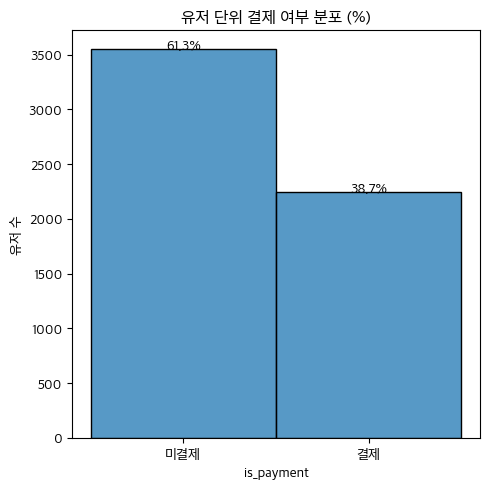

In [64]:
# 유저 단위로 중복 제거
user_df = df.drop_duplicates(subset='user_uuid')

# 유저 기준 결제 여부 비율 계산
value_counts = user_df['is_payment'].value_counts(normalize=True).sort_index()
percentages = (value_counts * 100).round(1)

# 시각화
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=user_df, x='is_payment', bins=2, discrete=True, ax=ax)

# 퍼센트 텍스트 추가
for i, pct in enumerate(percentages):
    ax.text(i, user_df['is_payment'].value_counts().sort_index()[i] + 5,
            f'{pct}%', ha='center', fontsize=10, color='black')

ax.set_xticks([0, 1])
ax.set_xticklabels(['미결제', '결제'])
ax.set_ylabel('유저 수')
ax.set_title('유저 단위 결제 여부 분포 (%)')

plt.tight_layout()
plt.show()

### 2.1.2 이용형태 분포 - 체크인 횟수, 체류시간

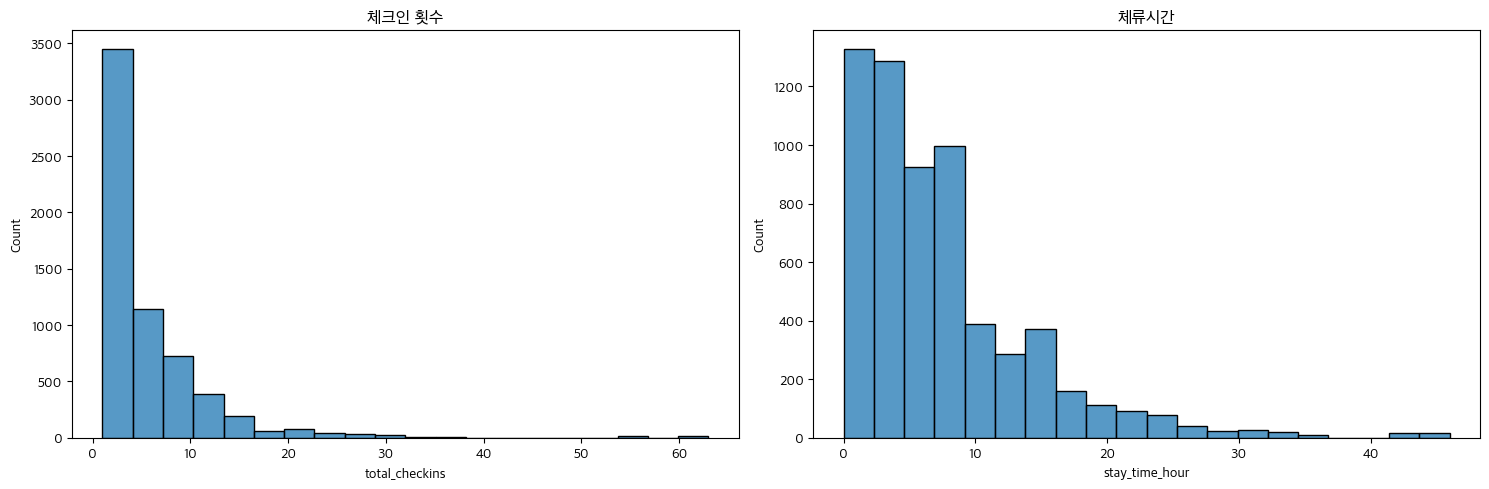

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.histplot(data=df, x='total_checkins', bins=20, ax=ax[0])
ax[0].set_title('체크인 횟수')

sns.histplot(data=df, x='stay_time_hour', bins=20, ax=ax[1])
ax[1].set_title('체류시간')
plt.tight_layout()
plt.show()

### 2.1.3 방문 시기 분포

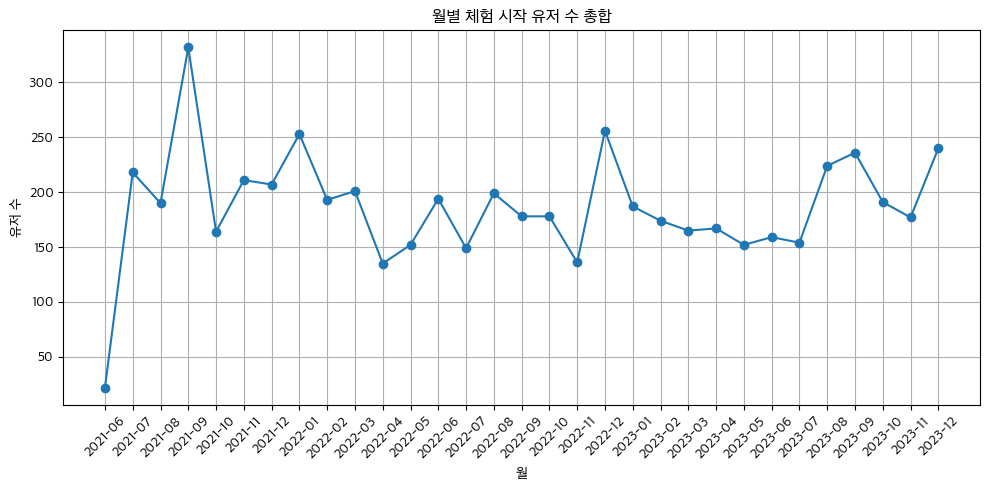

In [66]:
# 유저 중복 제거 후 월별 체험 시작 수 계산
monthly_counts = (
    df.drop_duplicates('user_uuid')
      .groupby(df['trial_date'].dt.to_period('M'))
      .size()
      .rename_axis('month')
      .reset_index(name='user_count')
)

# 월을 문자열로 변환
monthly_counts['month'] = monthly_counts['month'].astype(str)

# 선 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(monthly_counts['month'], monthly_counts['user_count'], marker='o')
plt.title('월별 체험 시작 유저 수 총합')
plt.xlabel('월')
plt.ylabel('유저 수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.2 체험일자에 따른 세그먼트

### 2.2.1 세그먼트 나누기

In [67]:
def assign_segment(row):
    if row['days'] == 1 and row['is_payment'] == 1:
        return '1회 체험 전환'
    elif row['days'] == 2 and row['is_payment'] == 1:
        return '2회 체험 전환'
    elif row['days'] >= 3 and row['is_payment'] == 1:
        return '3회 이상 체험 전환'
    elif row['days'] == 1 and row['is_payment'] == 0:
        return '1회 체험 미전환'
    elif row['days'] == 2 and row['is_payment'] == 0:
        return '2회 체험 미전환'
    elif row['days'] >= 3 and row['is_payment'] == 0:
        return '3회 이상 체험 미전환'
    else:
        return '기타'

df['segment'] = df.apply(assign_segment, axis=1)

In [68]:
display(df['segment'].value_counts())

segment
1회 체험 미전환       2254
1회 체험 전환        1165
2회 체험 미전환       1013
2회 체험 전환         748
3회 이상 체험 미전환     523
3회 이상 체험 전환      466
Name: count, dtype: int64

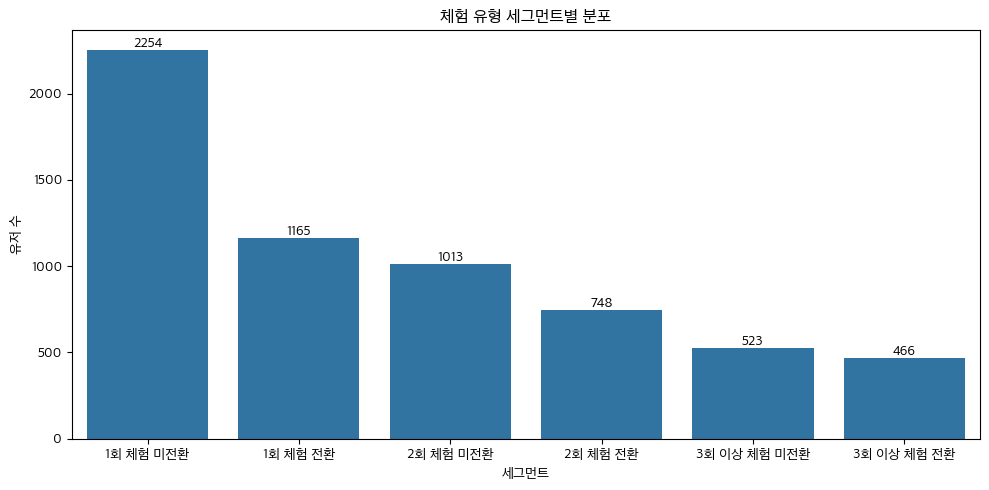

In [69]:
segment_order = [
    '1회 체험 미전환',
    '1회 체험 전환',
    '2회 체험 미전환',
    '2회 체험 전환',
    '3회 이상 체험 미전환',
    '3회 이상 체험 전환'
]

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='segment', order=segment_order, ax=ax)

# 막대 위에 count 수 표시
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title('체험 유형 세그먼트별 분포')
plt.xlabel('세그먼트')
plt.ylabel('유저 수')
plt.tight_layout()
plt.show()

In [70]:
# 1회 체험 유저 필터 (checkin_count == 1)
one_time = df[df['days'] == 1]
one_time_conversion_rate = one_time['is_payment'].mean()
one_time_user_count = len(one_time)

# 2회 체험 유저 필터 (checkin_count == 2)
two_time = df[df['days'] == 2]
two_time_conversion_rate = two_time['is_payment'].mean()
two_time_user_count = len(two_time)

# 3회 이상 체험 유저 필터
multi_time = df[df['days'] >= 3]
multi_time_conversion_rate = multi_time['is_payment'].mean()
multi_time_user_count = len(multi_time)

print(f"1회 체험 유저 수: {one_time_user_count}, 결제 전환율: {one_time_conversion_rate:.2%}")
print(f"2회 체험 유저 수: {two_time_user_count}, 결제 전환율: {two_time_conversion_rate:.2%}")
print(f"3회 이상 체험 유저 수: {multi_time_user_count}, 결제 전환율: {multi_time_conversion_rate:.2%}")

1회 체험 유저 수: 3419, 결제 전환율: 34.07%
2회 체험 유저 수: 1761, 결제 전환율: 42.48%
3회 이상 체험 유저 수: 989, 결제 전환율: 47.12%


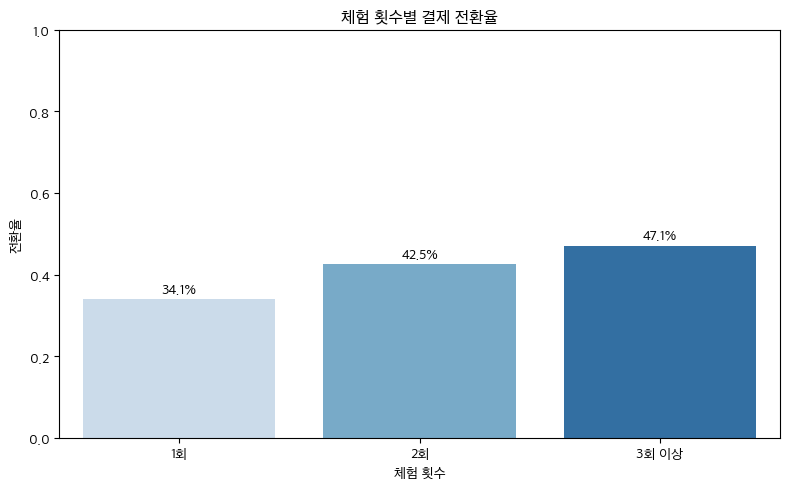

In [71]:
conversion_df = pd.DataFrame({
    '체험 횟수': ['1회', '2회', '3회 이상'],
    '유저 수': [one_time_user_count, two_time_user_count, multi_time_user_count],
    '전환율': [one_time_conversion_rate, two_time_conversion_rate, multi_time_conversion_rate]
})

# 시각화
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=conversion_df, x='체험 횟수', y='전환율', palette='Blues', ax=ax)

# 전환율 수치 표시
for i, row in conversion_df.iterrows():
    ax.text(i, row['전환율'] + 0.01, f"{row['전환율']:.1%}", ha='center', va='bottom')

plt.title('체험 횟수별 결제 전환율')
plt.ylim(0, 1)
plt.ylabel('전환율')
plt.xlabel('체험 횟수')
plt.tight_layout()
plt.show()

- <mark> 1일 체험자가 가장 많지만, 결제전환율은 체험을 더 많이할수록 높아진다 > 3일 체험을 온전히 다 할 수 있도록 유도하는 장치가 필요하다

### 2.2.2 세그먼트별 특징

#### 입실, 퇴실 시간

In [72]:
# 시간 컬럼에서 입실/퇴실 시각, 요일 추출
df['enter_hour'] = pd.to_datetime(df['first_visit'], format='mixed', errors='coerce').dt.hour
df['leave_hour'] = pd.to_datetime(df['last_visit'], format='mixed', errors='coerce').dt.hour
df['weekday'] = pd.to_datetime(df['first_visit'], format='mixed', errors='coerce').dt.day_name()

In [73]:
df.head(2)

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,segment,enter_hour,leave_hour,weekday
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,1회 체험 미전환,9,16,Thursday
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,1회 체험 미전환,4,15,Thursday


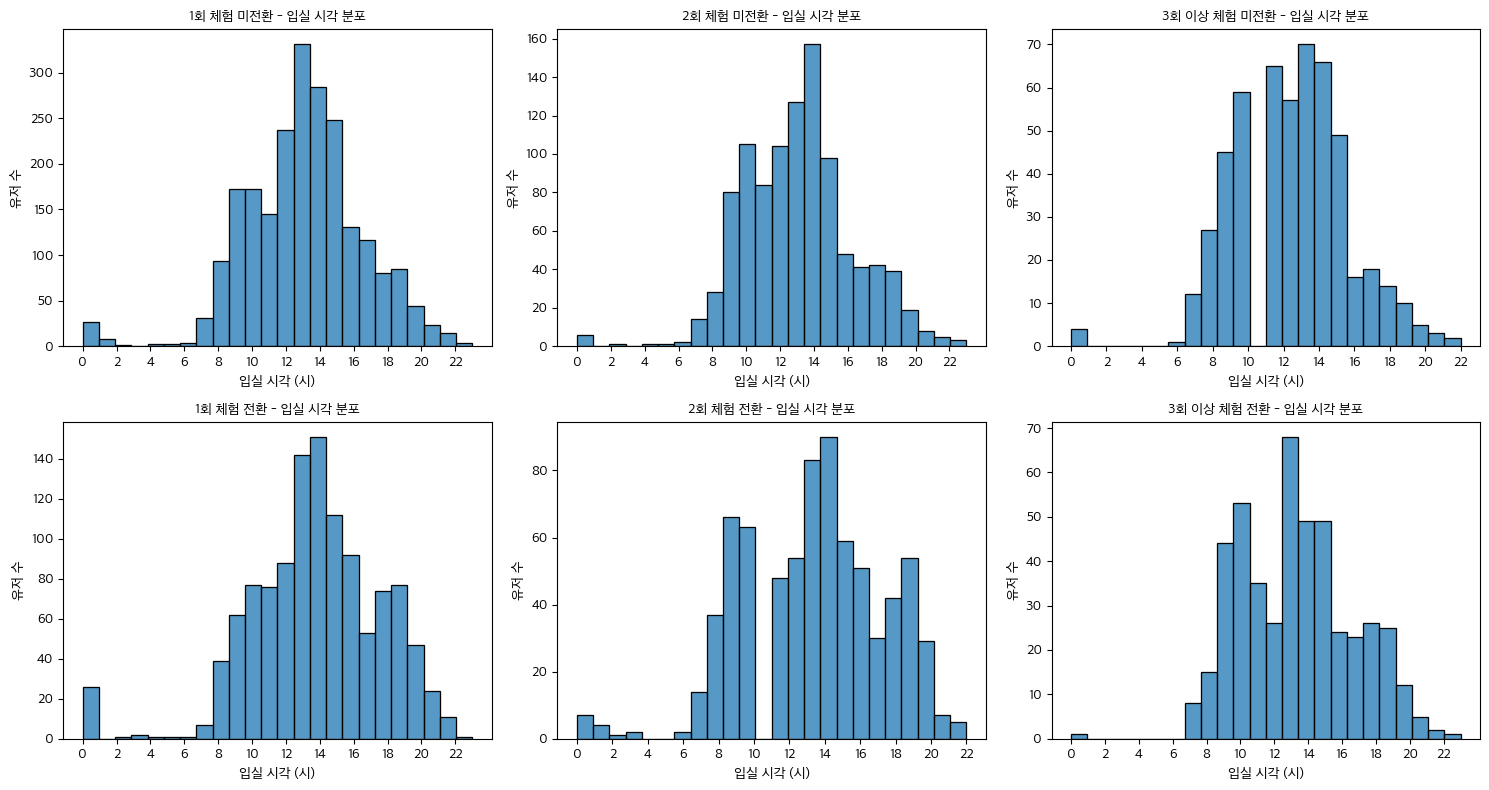

In [74]:
import math

segment_order = [
    '1회 체험 미전환',
    '2회 체험 미전환',
    '3회 이상 체험 미전환',
    '1회 체험 전환',
    '2회 체험 전환',
    '3회 이상 체험 전환'
]

# subplot 배열 구성 (예: 2행 3열)
n_segments = len(segment_order)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# subplot 배열 구성 (예: 2행 3열)
n_cols = 3
n_rows = math.ceil(n_segments/ n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # 그래프 크기 조정

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['enter_hour'], bins=24, kde=False)
    plt.title(f'{seg} - 입실 시각 분포', fontsize=10)
    plt.xlabel('입실 시각 (시)')
    plt.xticks(range(0, 24, 2))
    plt.ylabel('유저 수')

plt.tight_layout()
plt.show()

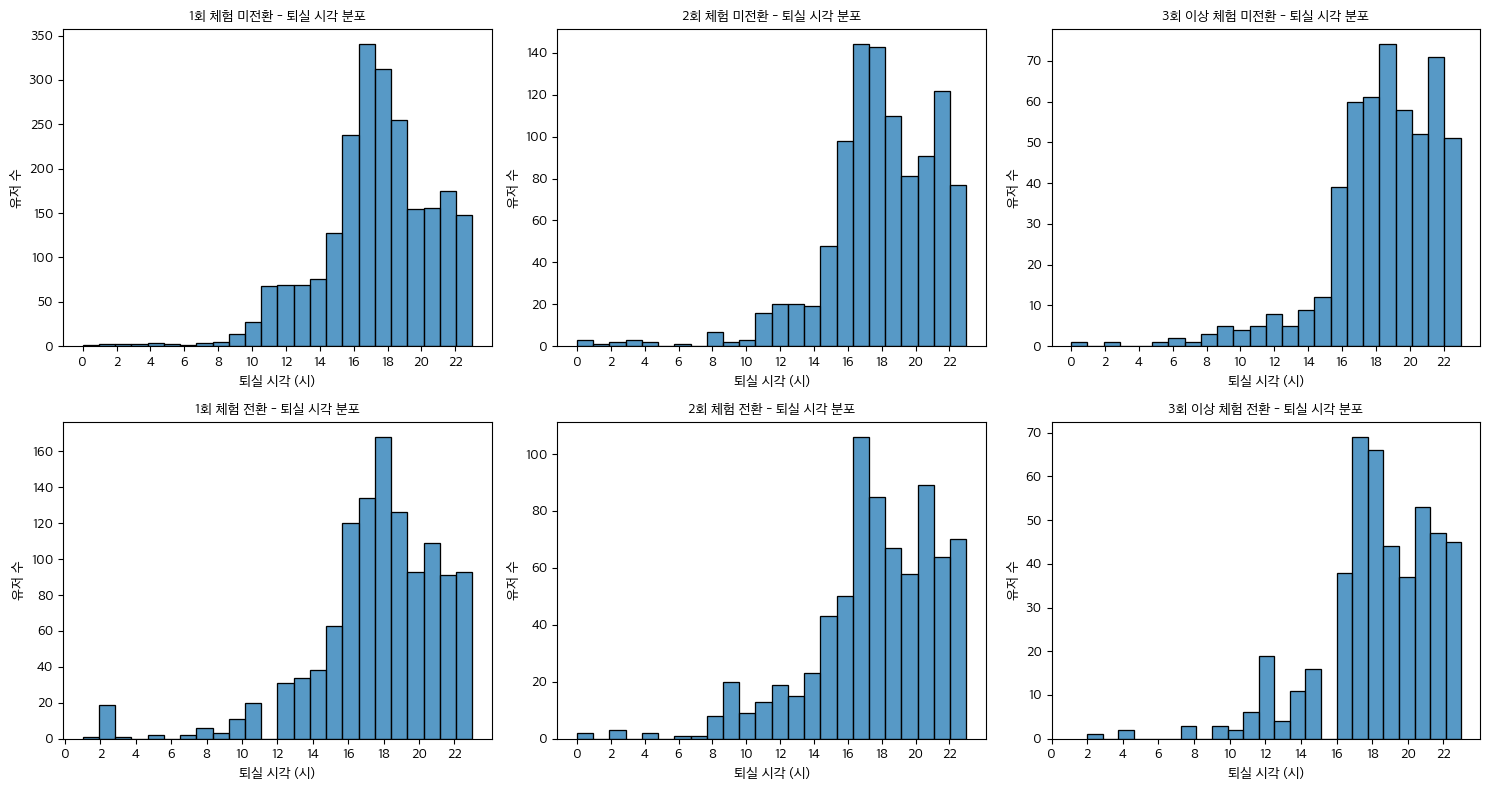

In [75]:
# 세그먼트 시각화 순서 명시
segment_order = [
    '1회 체험 미전환',
    '2회 체험 미전환',
    '3회 이상 체험 미전환',
    '1회 체험 전환',
    '2회 체험 전환',
    '3회 이상 체험 전환'
]


# subplot 배열 구성 (예: 2행 3열)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# 원하는 subplot 구성: 예) 3열
n_cols = 3
n_rows = math.ceil(n_segments / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # 그래프 크기 조정

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['leave_hour'], bins=24, kde=False)
    plt.title(f'{seg} - 퇴실 시각 분포', fontsize=10)
    plt.xlabel('퇴실 시각 (시)')
    plt.xticks(range(0, 24, 2))
    plt.ylabel('유저 수')

plt.tight_layout()
plt.show()

✅ 전체적으로 공통된 특징
- 입실 피크 타임은 오전 11시~오후 2시 사이에 집중
- 퇴실시간은 17시~20시 사이에 집중

✅ 세그먼트별 특징
1. 1회 체험 미전환
    - 가장 많은 유저 수
    - 입실 시간은 12시~14시 사이 가장 집중적
    - 입실 분포는 전형적인 점심시간대에 몰림 -> 업무 중 체험한 유저일 가능성 높음

2. 1회 체험 전환
    - 입실시간 분포는 미전환과 유사하지만 조금 더 균일하게 퍼짐
    - 10시~16시 사이 입실 꾸준히 존재함

3. 2회 체험 미전환
    - 10시~11시 입실이 다소 적음

4. 2회 체험 전환
    - 입실 시간이 상대적으로 고르게 존재

5. 3회 이상 체험 전환
    - 9시~ 14시 입실 고르게 분포, 17시~22시 퇴실 고르게 분포
    - 입실과 퇴실이 모두 유연한 편

6. 3회 이상 체험 미전환
    - 입실 시간은 전환군과 비슷하나, 13시~15시로 조금 더 늦은 시각에 집중

#### 혼잡도

In [76]:
# enter_hour 기준으로 방문 수 비율 계산
hourly_congestion = df['enter_hour'].value_counts(normalize=True).sort_index()

# 예시 출력
print(hourly_congestion)

enter_hour
0     0.011509
1     0.001945
2     0.000648
3     0.000648
4     0.000648
5     0.000648
6     0.001459
7     0.013941
8     0.038904
9     0.076025
10    0.085751
11    0.073432
12    0.091749
13    0.133085
14    0.129194
15    0.099692
16    0.058680
17    0.045550
18    0.045064
19    0.047009
20    0.025288
21    0.011347
22    0.006484
23    0.001297
Name: proportion, dtype: float64


In [77]:
df['congestion_score'] = df['enter_hour'].map(hourly_congestion)

In [78]:
# 분위수 기준 임계값 계산
q1 = df['congestion_score'].quantile(1/3)
q2 = df['congestion_score'].quantile(2/3)

# 혼잡도 수준 매핑 함수
def get_congestion_level(score):
    if score >= q2:
        return '혼잡'
    elif score >= q1:
        return '보통'
    else:
        return '여유'

df['congestion_level'] = df['congestion_score'].apply(get_congestion_level)

In [79]:
df[['enter_hour', 'congestion_score', 'congestion_level']].head(24)

,enter_hour,congestion_score,congestion_level
0,9,0.076025,보통
1,4,0.000648,여유
2,21,0.011347,여유
3,21,0.011347,여유
4,15,0.099692,혼잡
5,9,0.076025,보통
6,15,0.099692,혼잡
7,20,0.025288,여유
8,9,0.076025,보통
9,14,0.129194,혼잡


In [80]:
df['congestion_level'].value_counts()

congestion_level
혼잡    2233
보통    2017
여유    1919
Name: count, dtype: int64

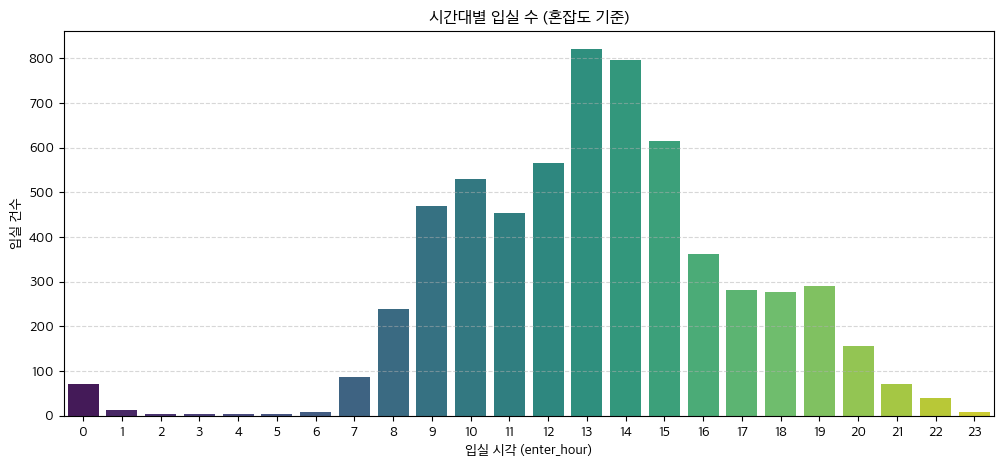

In [81]:
# 시간대별 입실 수 계산
hourly_visits = df['enter_hour'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(12, 5))
sns.barplot(x=hourly_visits.index, y=hourly_visits.values, palette='viridis')
plt.title('시간대별 입실 수 (혼잡도 기준)')
plt.xlabel('입실 시각 (enter_hour)')
plt.ylabel('입실 건수')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [82]:
top_hours = hourly_visits.sort_values(ascending=False).head(5)
print("가장 혼잡한 입실 시간대:")
print(top_hours)

가장 혼잡한 입실 시간대:
enter_hour
13    821
14    797
15    615
12    566
10    529
Name: count, dtype: int64


#### 요일

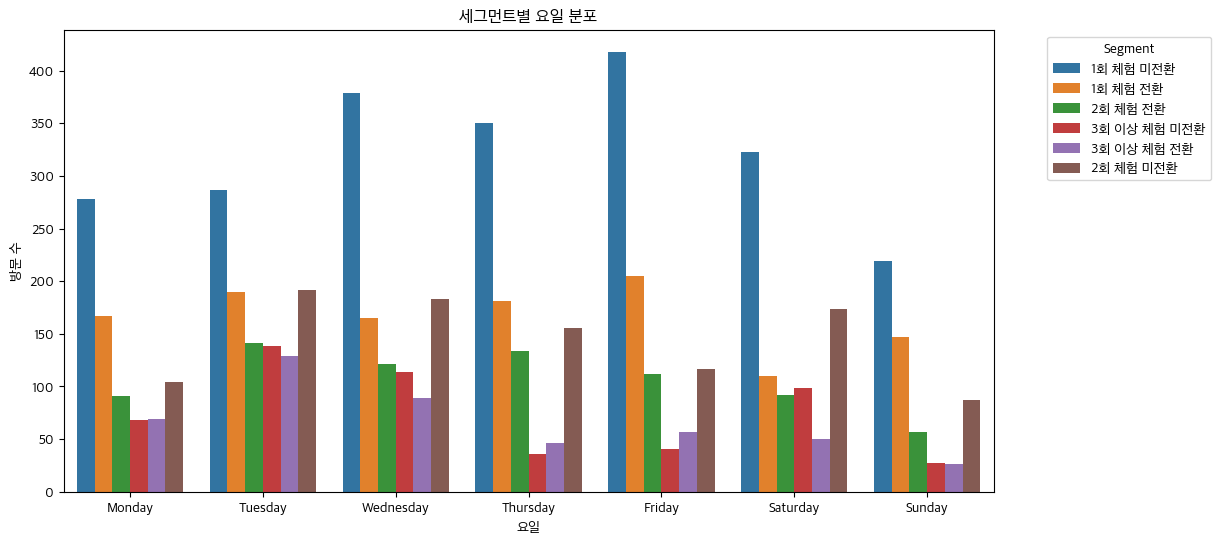

In [83]:
# 요일 정렬용 category 설정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='weekday', hue='segment')
plt.title('세그먼트별 요일 분포')
plt.xlabel('요일')
plt.ylabel('방문 수')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

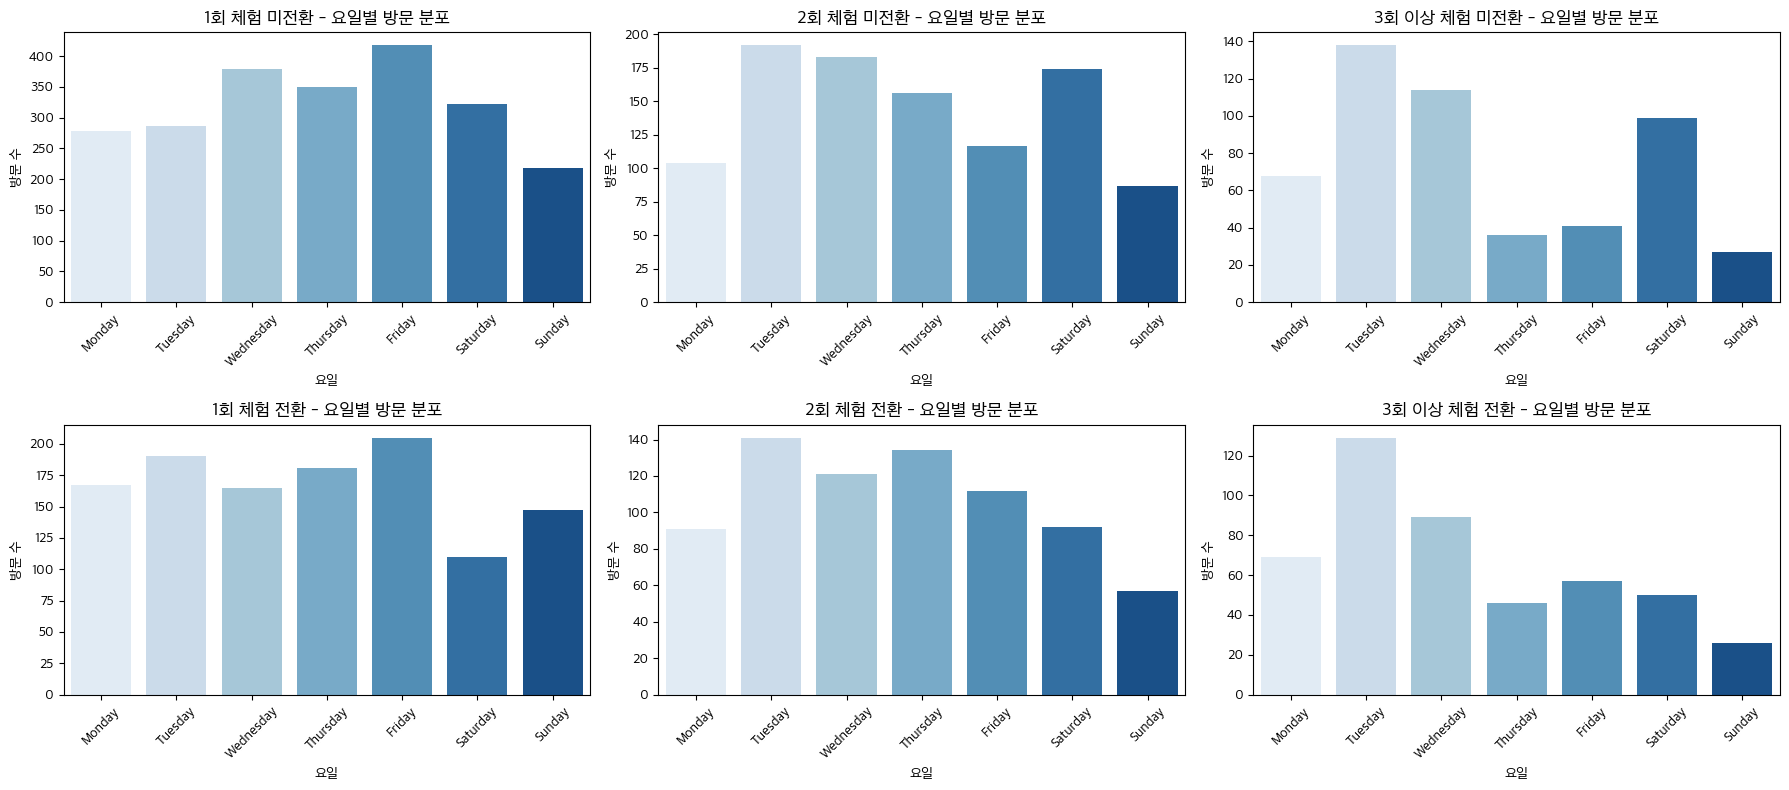

In [84]:
# 세그먼트 시각화 순서
segment_order = [
    '1회 체험 미전환',
    '2회 체험 미전환',
    '3회 이상 체험 미전환',
    '1회 체험 전환',
    '2회 체험 전환',
    '3회 이상 체험 전환'
]

# subplot 구성
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.countplot(
        data=subset,
        x='weekday',
        hue='weekday',
        order=weekday_order,
        palette='Blues',
        legend=False
    )
    plt.title(f'{seg} - 요일별 방문 분포', fontsize=13)
    plt.xlabel('요일')
    plt.ylabel('방문 수')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. 전환 유저는 대부분 화 ~ 금 사이 집중 방문
    - 특히 2회 이상 전환 유저는 주말 방문 비중이 현저히 낮음.
    → 주말 유입은 전환율 낮고, 평일 중심 유입 전략이 유효

2. 전환 유저일수록 특정 요일에 집중되는 경향
    - 3회 이상 체험 후 전환 유저: 화요일 집중 방문 → 전환 성공
    - 일정한 요일 루틴 → 예측 가능한 타겟 마케팅 가능

3. 미전환 유저는 전환 유저보다 방문 요일 분산도가 큼
    - 특히 1회/2회 체험 미전환은 요일 패턴 뚜렷하지 않음 → 목적 없는 탐색일 가능성
    → 이탈 가능성 높은 유저, 리텐션/리마인드 유도 필요

4. 금요일은 첫 방문 요일로 유효하나, 이후 연결 중요
    - 1회 체험 전환/미전환 모두 금요일 방문 비중 높음
    → 금요일 유입 > 주초 전환 연결 흐름 설계 필요

#### 출근시간, 오전, 오후, 저녁시간

In [85]:
# 입실시간이 언제인지? 출근시간, 출근 외 오전, 오후, 저녁
def categorize_time(hour):
    if 7 <= hour < 10:
        return '출근시간'
    elif 10 <= hour < 13:
        return '출근 외 오전'
    elif 13 <= hour < 17:
        return '오후'
    else:
        return '저녁'

df['enter_time_group'] = df['enter_hour'].apply(categorize_time)

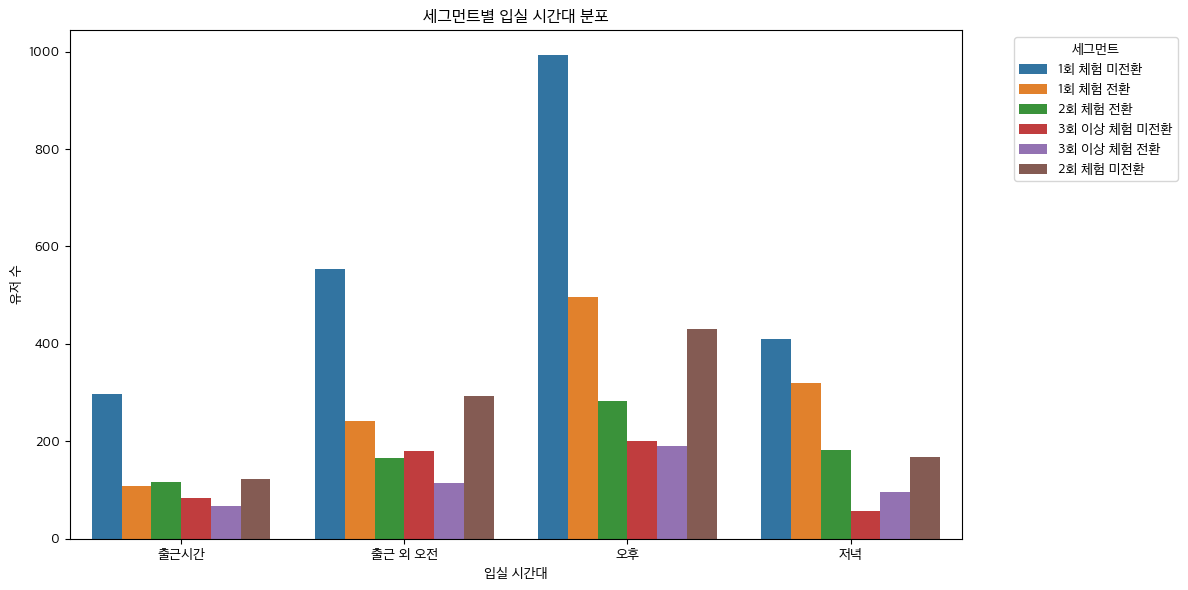

In [86]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='enter_time_group', hue='segment', order=['출근시간', '출근 외 오전', '오후', '저녁'])
plt.title('세그먼트별 입실 시간대 분포')
plt.xlabel('입실 시간대')
plt.ylabel('유저 수')
plt.legend(title='세그먼트', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

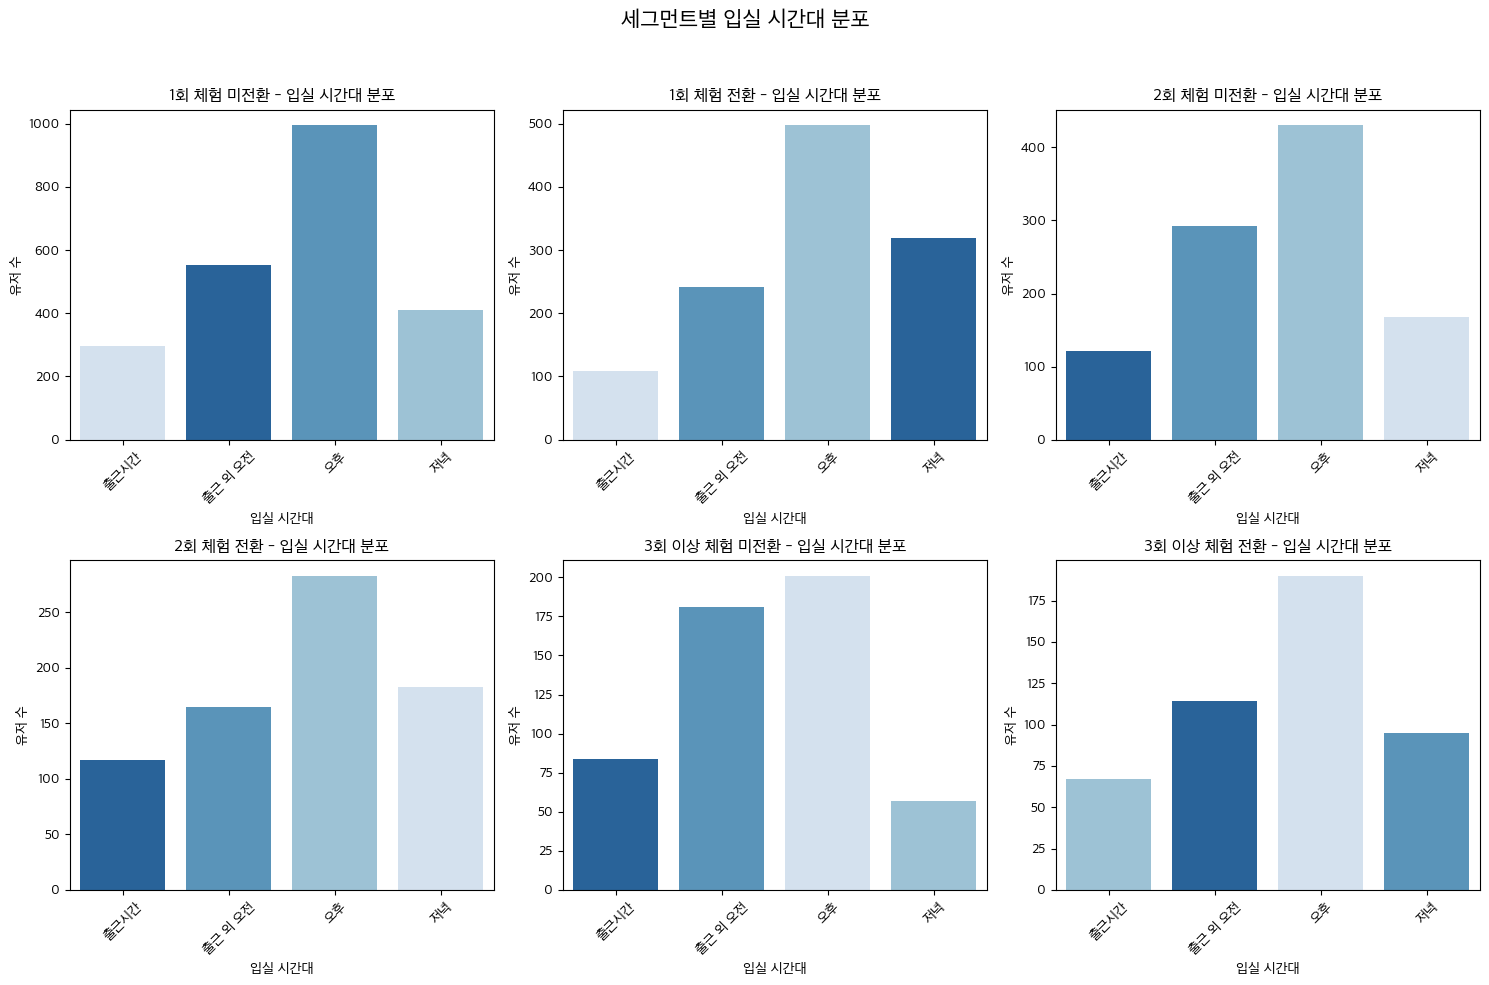

In [87]:
# 세그먼트 리스트
segments = df['segment'].unique()

# subplot 설정
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('세그먼트별 입실 시간대 분포', fontsize=16)
time_order = ['출근시간', '출근 외 오전', '오후', '저녁']

# 세그먼트별 그래프
for i, segment in enumerate(sorted(segments)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.countplot(
        data=df[df['segment'] == segment],
        x='enter_time_group',
        hue='enter_time_group',
        order=time_order,
        palette='Blues',
        legend=False,
        ax=ax
    )

    ax.set_title(f'{segment} - 입실 시간대 분포')
    ax.set_xlabel('입실 시간대')
    ax.set_ylabel('유저 수')
    ax.tick_params(axis='x', rotation=45)

# 빈 subplot 제거
for j in range(len(segments), 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

✅ 주요 인사이트

1. 전환/미전환 공통 패턴: 오후 입실 비중이 가장 높음
    - 전 세그먼트에서 ‘오후’ 시간대 입실 비중이 가장 높음
    - 이는 유저들이 주로 업무 중/후 여유 시간에 플랫폼을 방문하는 경향을 시사
    - 특히 미전환 그룹(1~2회)의 경우 오후 집중도가 더욱 강함

2. 전환 유저는 전반적으로 '출근 외 오전' 입실 비중이 높음
    - 전환 세그먼트(1~3회 이상)는 출근 외 오전 시간대의 입실 비중이 미전환 대비 상대적으로 높음
    - 예: 1회 체험 전환은 오전 비중이 1회 미전환보다 높음
    - 이는 업무 시작 전 여유 시간을 활용하는 유저가 전환율이 높을 수 있음을 시사

3. ‘출근시간’ 입실은 전환 여부와 뚜렷한 상관 없음
    - 출근시간 시간대는 대부분 세그먼트에서 낮은 비중을 보이며, 전환/미전환 간 큰 차이 없음

4. ‘저녁’ 시간대는 전체적으로 비중이 낮지만, 전환 세그먼트에서 소폭 상승
    - 3회 이상 전환 세그먼트에서는 ‘저녁’ 시간대 비중이 미전환보다 높음
    - 이는 꾸준히 사용하는 유저일수록 퇴근 후에도 플랫폼에 접속하는 행동 특성을 반영할 수 있음

#### 체크인 패턴

In [88]:
df['total_checkins'].value_counts()

total_checkins
1     1165
2      961
4      747
3      575
6      493
5      399
8      368
7      252
10     220
12     165
9      137
11     114
13     110
14      93
16      53
15      46
20      37
18      36
21      26
25      21
27      17
31      17
63      16
54      16
17      15
22      14
19      13
26      10
24       9
23       9
30       4
38       3
28       3
33       2
40       1
29       1
34       1
Name: count, dtype: int64

In [89]:
def categorize_checkin_freq(x):
    if x == 1:
        return '1회 체크인'
    elif 2 <= x <= 10:
        return '중간 빈도 체크인'
    elif x >= 10:
        return '다회 체크인'

df['checkin_freq_category'] = df['total_checkins'].apply(categorize_checkin_freq)

In [90]:
print(df['total_checkins'].describe())

count    6169.000000
mean        5.786189
std         6.355255
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        63.000000
Name: total_checkins, dtype: float64


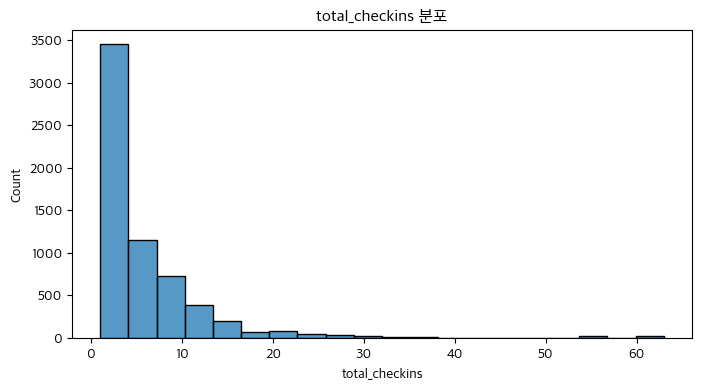

In [91]:
plt.figure(figsize=(8,4))
sns.histplot(df['total_checkins'], bins=20)
plt.title('total_checkins 분포')
plt.show()

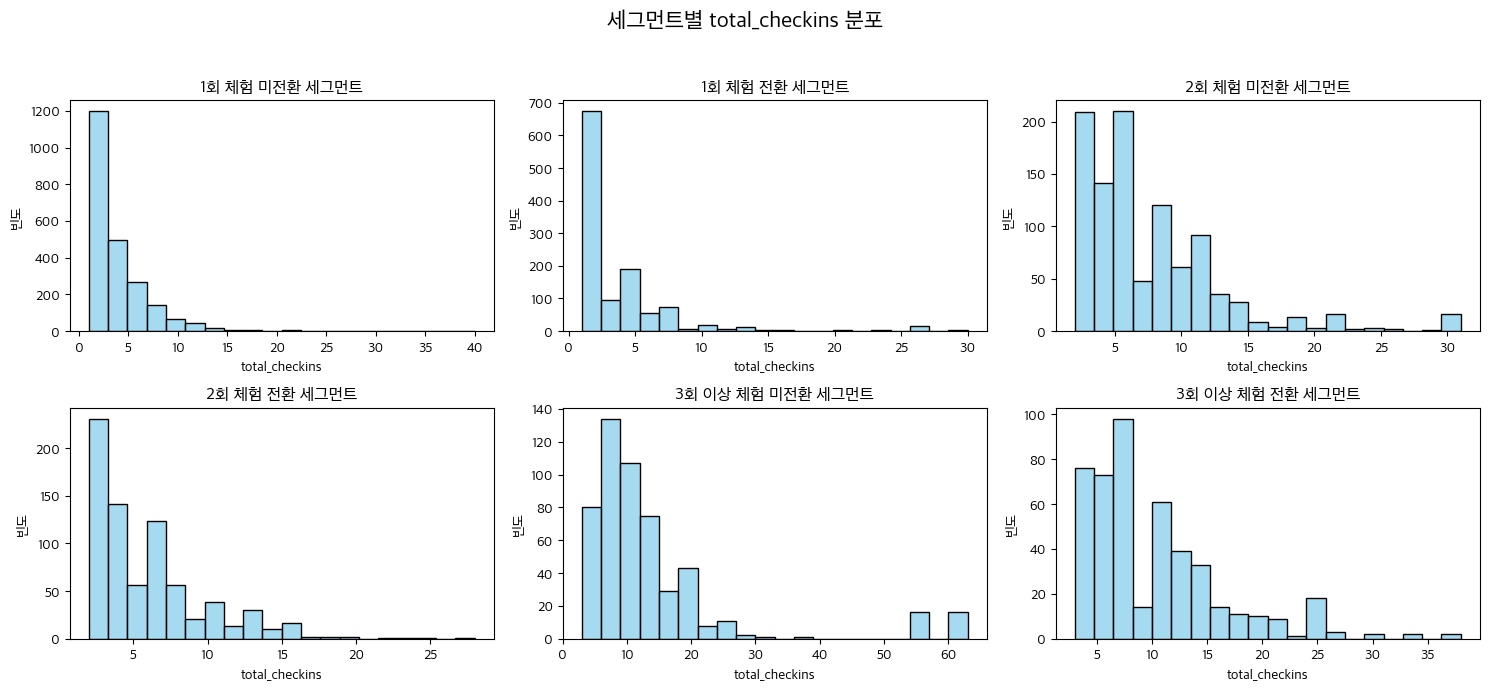

In [92]:
segments = df['segment'].unique()

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
fig.suptitle('세그먼트별 total_checkins 분포', fontsize=16)

for i, segment in enumerate(sorted(segments)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    sns.histplot(
        data=df[df['segment'] == segment],
        x='total_checkins',
        bins=20,
        ax=ax,
        kde=False,
        color='skyblue'
    )

    ax.set_title(f'{segment} 세그먼트')
    ax.set_xlabel('total_checkins')
    ax.set_ylabel('빈도')

# 빈 subplot 제거
for j in range(len(segments), 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- 전환 그룹(체험 후 이용 전환한 사용자)은 평균적으로 체크인 횟수가 더 많고, 꾸준히 이용하는 경향이 강함
- 미전환 그룹은 대체로 체크인 횟수가 적고, 이용 빈도가 낮음
- 특히, 3회 이상 체험 그룹에서 전환 여부에 따른 차이가 더 뚜렷하게 나타남
- 즉, 체험 횟수가 늘어날수록 전환 가능성도 높아지고, 전환된 사용자는 더 빈번하게 공유오피스를 이용하는 패턴이 확인

#### 체류시간

In [93]:
df.head(2)

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,segment,enter_hour,leave_hour,weekday,congestion_score,congestion_level,enter_time_group,checkin_freq_category
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,1회 체험 미전환,9,16,Thursday,0.076025,보통,출근시간,중간 빈도 체크인
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,1회 체험 미전환,4,15,Thursday,0.000648,여유,저녁,중간 빈도 체크인


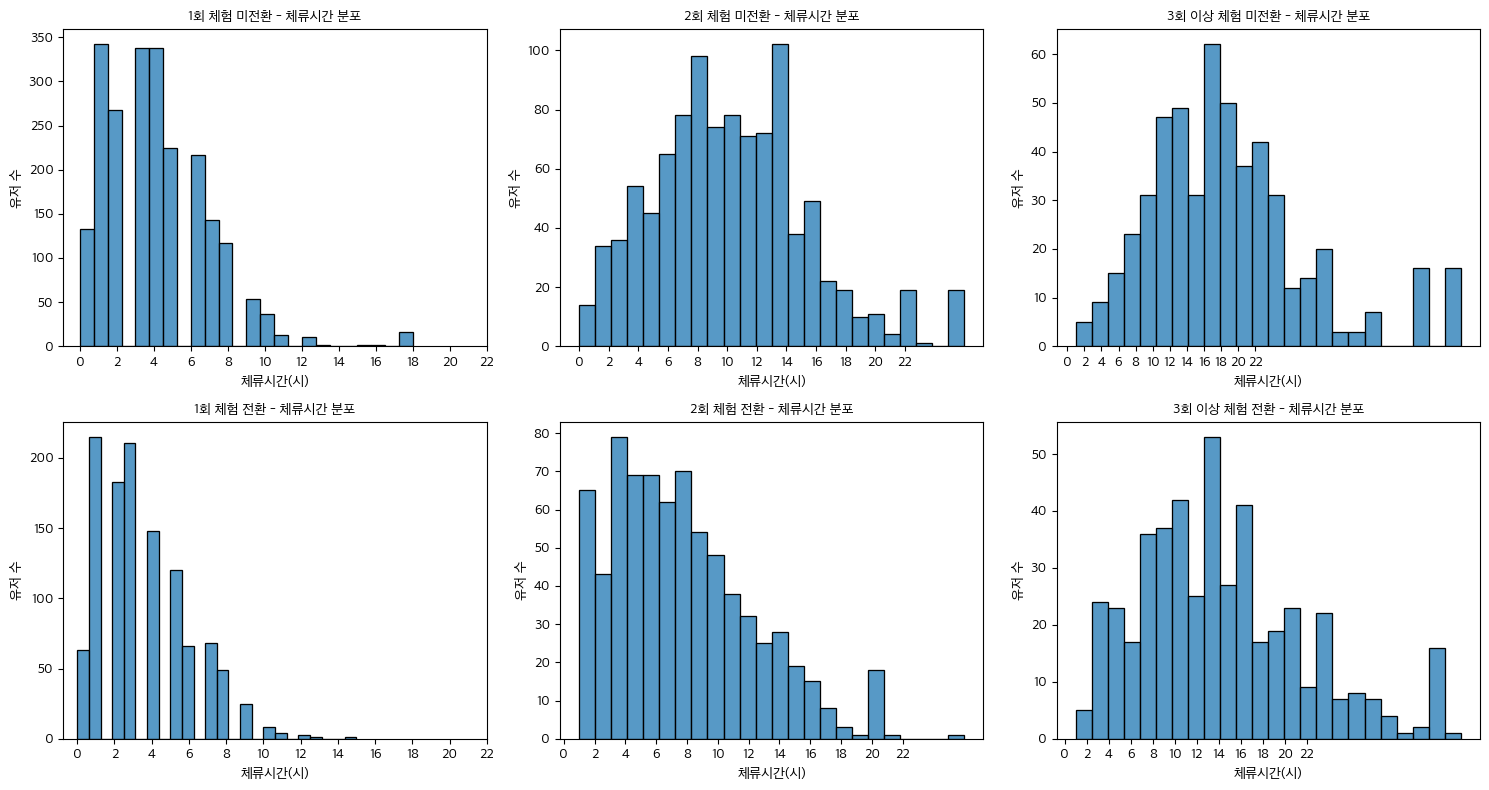

In [94]:
segment_order = [
    '1회 체험 미전환',
    '2회 체험 미전환',
    '3회 이상 체험 미전환',
    '1회 체험 전환',
    '2회 체험 전환',
    '3회 이상 체험 전환'
]

# subplot 배열 구성 (예: 2행 3열)
n_segments = len(segment_order)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# subplot 배열 구성 (예: 2행 3열)
n_cols = 3
n_rows = math.ceil(n_segments/ n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['stay_time_hour'], bins=24, kde=False)
    plt.title(f'{seg} - 체류시간 분포', fontsize=10)
    plt.xlabel('체류시간(시)')
    plt.xticks(range(0, 24, 2))
    plt.ylabel('유저 수')

plt.tight_layout()
plt.show()

#### 방문지연시간

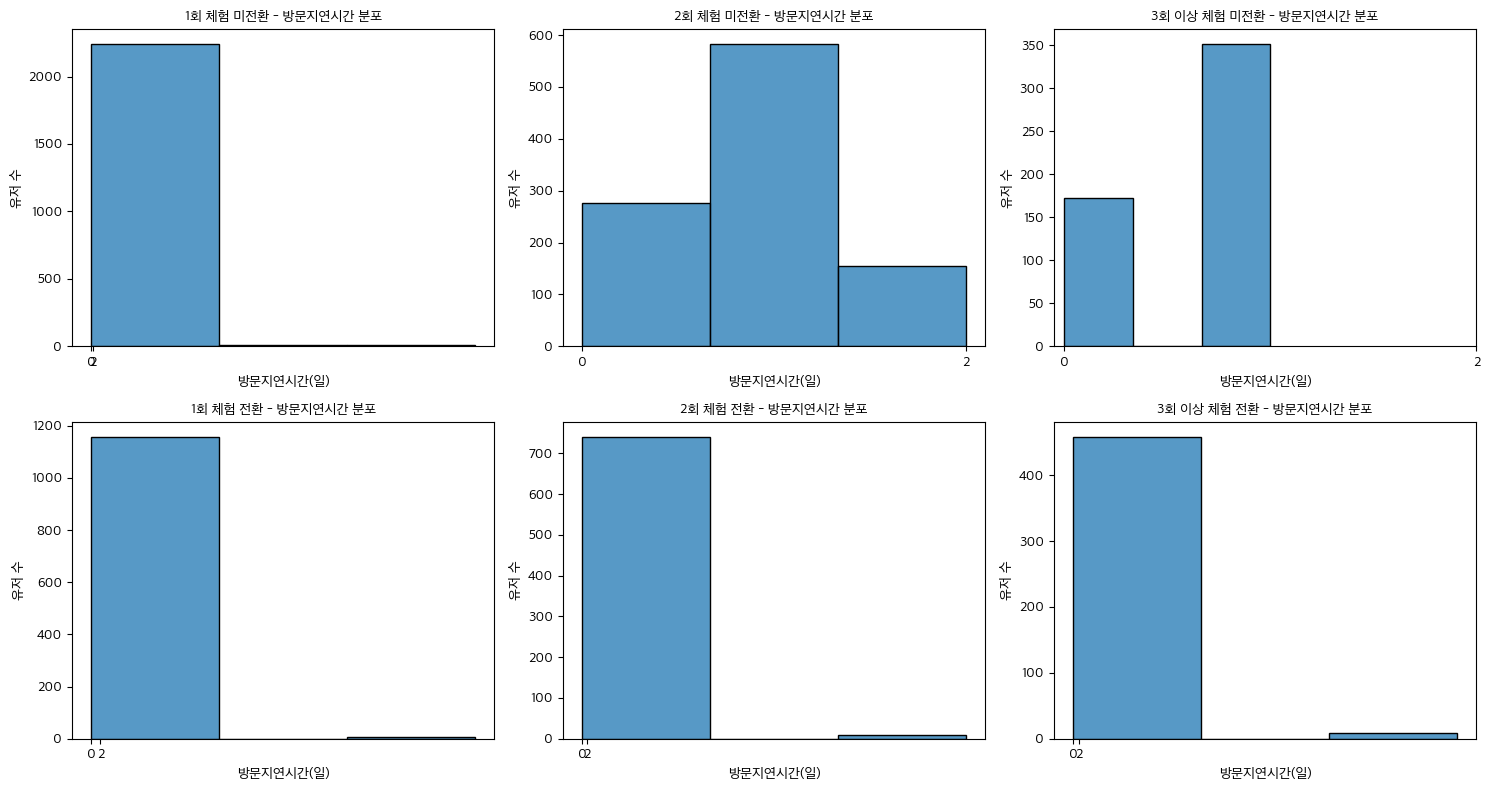

In [95]:
segment_order = [
    '1회 체험 미전환',
    '2회 체험 미전환',
    '3회 이상 체험 미전환',
    '1회 체험 전환',
    '2회 체험 전환',
    '3회 이상 체험 전환'
]

# subplot 배열 구성 (예: 2행 3열)
n_segments = len(segment_order)
n_cols = 3
n_rows = math.ceil(len(segment_order) / n_cols)

# subplot 배열 구성 (예: 2행 3열)
n_cols = 3
n_rows = math.ceil(n_segments/ n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, seg in enumerate(segment_order):
    plt.subplot(n_rows, n_cols, i + 1)
    subset = df[df['segment'] == seg]
    sns.histplot(subset['visit_delay_days'], bins=3, kde=False)
    plt.title(f'{seg} - 방문지연시간 분포', fontsize=10)
    plt.xlabel('방문지연시간(일)')
    plt.xticks(range(0, 3, 2))
    plt.ylabel('유저 수')

plt.tight_layout()
plt.show()

---

## 2.3 모델링을 위한 파생변수 생성

### 2.3.1 체크인 관련 파생변수

#### 일 평균 체크인 수 (`mean_checkins_per_day`)

In [96]:
# 0으로 나누는 경우 NaN으로 처리한 뒤 float64로 변환
user['mean_checkins_per_day'] = (
    user['total_checkins'] / user['days'].replace(0, np.nan)
).round(2).astype('float64')

In [97]:
# 데이터 정보 확인
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_uuid              6169 non-null   object        
 1   first_visit            6169 non-null   datetime64[ns]
 2   last_visit             6169 non-null   datetime64[ns]
 3   total_checkins         6169 non-null   int64         
 4   stay_time_hour         6169 non-null   int64         
 5   days                   6169 non-null   int64         
 6   is_payment             6169 non-null   int64         
 7   trial_date             6169 non-null   datetime64[ns]
 8   visit_delay_days       6169 non-null   int64         
 9   mean_checkins_per_day  6169 non-null   float64       
dtypes: datetime64[ns](3), float64(1), int64(5), object(1)
memory usage: 482.1+ KB


In [98]:
# 데이터 확인
user.head()

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,mean_checkins_per_day
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,6.0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,2.0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0,2.0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0,2.0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0,2.0


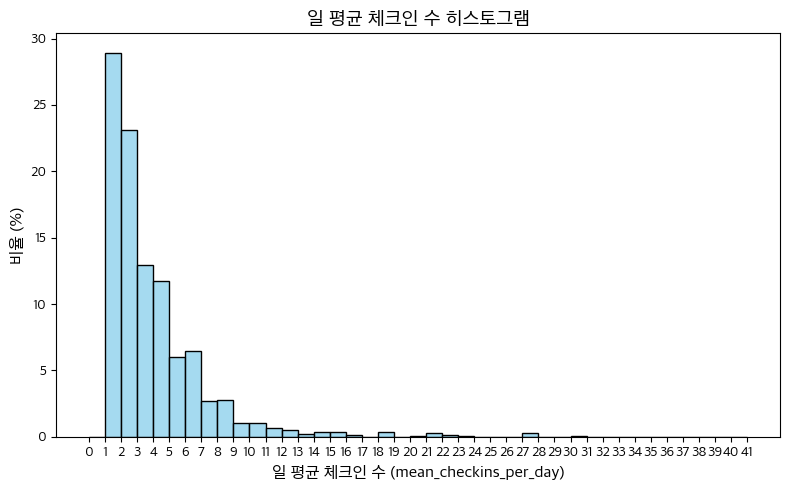

In [99]:
# 1. bin 기준 설정 (0부터 10까지 1 간격으로, 필요시 확장 가능)
bins = np.arange(0, user['mean_checkins_per_day'].max() + 2, 1)

# 2. 시각화
plt.figure(figsize=(8, 5))
sns.histplot(data=user, x='mean_checkins_per_day', bins=bins, stat='percent', kde=False, color='skyblue', edgecolor='black')

# 3. 꾸미기
plt.xlabel('일 평균 체크인 수 (mean_checkins_per_day)', fontsize=12)
plt.ylabel('비율 (%)', fontsize=12)
plt.title('일 평균 체크인 수 히스토그램', fontsize=14)
plt.xticks(bins)  # 눈금 정수로 고정
plt.tight_layout()
plt.show()

#### 일 평균 체크인 수 범주형 파생변수 (`mean_checkins_level`)
- 해석을 용이하게 하고, 안정성을 확보하기 위해 범주형 변수를 도입합니다.

In [100]:
# mean_checkins_per_day 기준으로 범주 생성
def label_checkins(mean):
    if mean < 2:
        return 1  # 1 이상 ~ 2 미만
    elif mean < 4:
        return 2  # 2 이상 ~ 4 미만
    else:
        return 3  # 4 이상

# 적용
user['mean_checkins_level'] = user['mean_checkins_per_day'].apply(label_checkins).astype('int64')

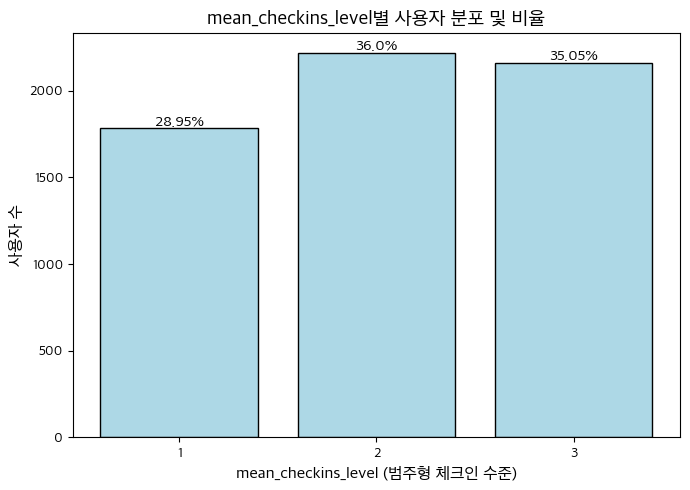

In [101]:
# 1. 값 계산
level_counts = user['mean_checkins_level'].value_counts().sort_index()
level_percent = (level_counts / level_counts.sum() * 100).round(2)

# 2. 시각화
plt.figure(figsize=(7, 5))
bars = plt.bar(level_counts.index.astype(str), level_counts.values, color='lightblue', edgecolor='black')

# 3. 비율 텍스트 추가
for i, (count, percent) in enumerate(zip(level_counts, level_percent)):
    plt.text(i, count + 2, f'{percent}%', ha='center', va='bottom', fontsize=11)

# 4. 꾸미기
plt.xlabel('mean_checkins_level (범주형 체크인 수준)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.title('mean_checkins_level별 사용자 분포 및 비율', fontsize=14)
plt.tight_layout()
plt.show()

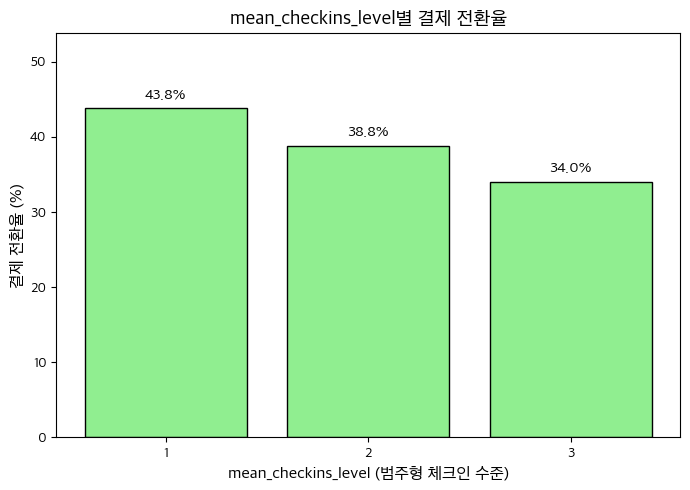

In [102]:
# 1. 각 레벨별 결제율 계산
conversion_rate = user.groupby('mean_checkins_level')['is_payment'].mean().round(3) * 100  # 퍼센트로 표기

# 2. 시각화
plt.figure(figsize=(7, 5))
bars = plt.bar(conversion_rate.index.astype(str), conversion_rate.values, color='lightgreen', edgecolor='black')

# 3. 비율 텍스트 추가
for i, rate in enumerate(conversion_rate.values):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom', fontsize=11)

# 4. 꾸미기
plt.xlabel('mean_checkins_level (범주형 체크인 수준)', fontsize=12)
plt.ylabel('결제 전환율 (%)', fontsize=12)
plt.title('mean_checkins_level별 결제 전환율', fontsize=14)
plt.ylim(0, max(conversion_rate.values) + 10)
plt.tight_layout()
plt.show()

#### 이진 파생변수: 빈번한 체크인 (`frequent_checkins`)

- `mean_checkins_per_day` 분포를 히스토그램으로 확인한 결과,  
  **일일 평균 체크인 수가 3 이상인 사용자가 전체의 약 절반 수준**임을 확인함.
- `frequent_checkins_user`: 일일 평균 체크인 수가 **3 이상이면 1**, 아니면 0
- 사용자의 **체험 형태나 공간 이용 행태의 분절성**을 가리키는 보조적 지표로 활용

In [103]:
# frequent_checkins_user 변수 생성
user['frequent_checkins'] = (user['mean_checkins_per_day'] >= 3).astype('int64')

In [104]:
# 열 확인
user.columns

Index(['user_uuid', 'first_visit', 'last_visit', 'total_checkins',
       'stay_time_hour', 'days', 'is_payment', 'trial_date',
       'visit_delay_days', 'mean_checkins_per_day', 'mean_checkins_level',
       'frequent_checkins'],
      dtype='object')

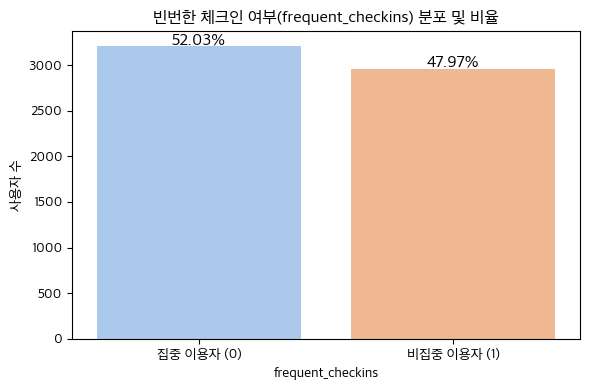

In [105]:
# 1. 값 계산
checkins_counts = user['frequent_checkins'].value_counts().sort_index()
checkins_percent = (checkins_counts / len(user) * 100).round(2)

# 2. 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=checkins_counts.index, y=checkins_counts.values, palette='pastel')

# 3. 비율 텍스트 추가
for i, (count, percent) in enumerate(zip(checkins_counts, checkins_percent)):
    plt.text(i, count + 10, f'{percent}%', ha='center', fontsize=12)

# 4. 꾸미기
plt.xticks([0, 1], ['집중 이용자 (0)', '비집중 이용자 (1)'])
plt.ylabel('사용자 수')
plt.title('빈번한 체크인 여부(frequent_checkins) 분포 및 비율')
plt.tight_layout()
plt.show()

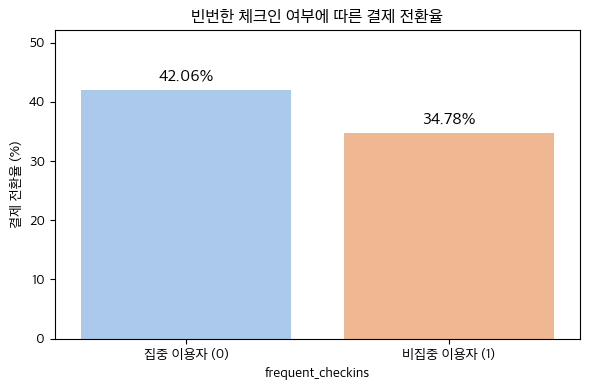

In [106]:
# 1. 결제 전환율 계산
checkins_conversion = user.groupby('frequent_checkins')['is_payment'].mean().round(4) * 100

# 2. 시각화
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=checkins_conversion.index, y=checkins_conversion.values, palette='pastel')

# 3. 텍스트 추가 (막대 위에 배치)
for i, val in enumerate(checkins_conversion.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. 꾸미기
plt.xticks([0, 1], ['집중 이용자 (0)', '비집중 이용자 (1)'])
plt.ylabel('결제 전환율 (%)')
plt.title('빈번한 체크인 여부에 따른 결제 전환율')
plt.ylim(0, max(checkins_conversion.values) + 10)  # 텍스트 공간 확보
plt.tight_layout()
plt.show()

#### ✅ 인사이트

- **frequent_checkins == 0** (덜 빈번하게 체크인한 사용자)의 **전환율은 41.87%**  
- **frequent_checkins == 1** (빈번하게 체크인한 사용자)의 **전환율은 35.04%**

즉, 들락날락하지 않고 집중적으로 이용한 사용자의 결제 전환율이 **더 높음**.

### 2.3.2 평균 체류시간 분포 및 전환률 확인

#### 일 평균 체류시간 (`mean_stay_time_hour`)
- 사용자마다 방문일수가 다르므로 단순히 총 체류 시간으로는 비교가 어렵습니다.
- 의미 있는 비교를 위해 일 평균 체류 시간 파생변수를 도입합니다.

In [107]:
# 0으로 나누는 경우 NaN으로 처리한 뒤 float64로 변환
user['mean_stay_time_hour'] = (
    user['stay_time_hour'] / user['days'].replace(0, np.nan)
).round(2).astype('float64')

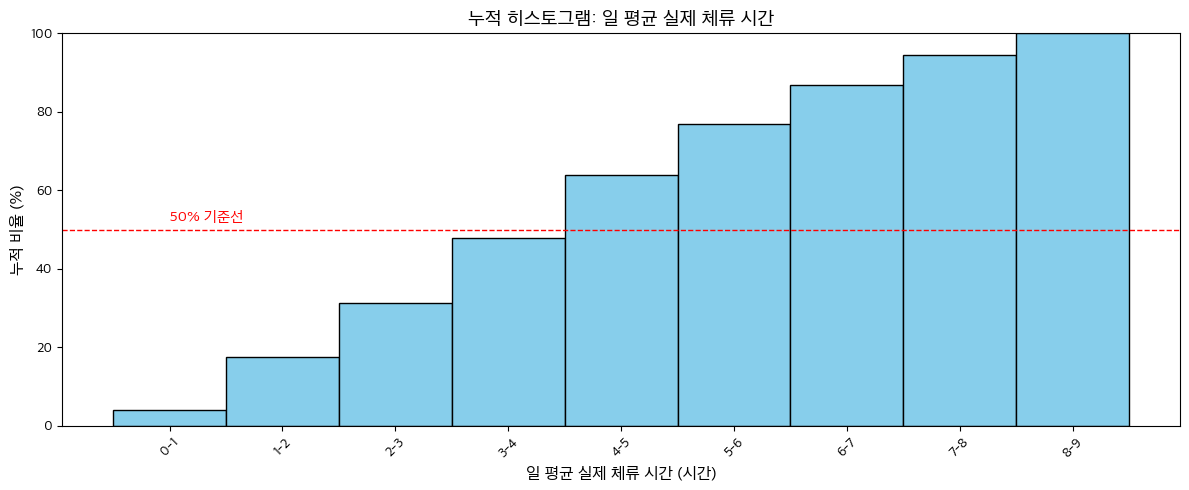

In [108]:
# 1. 1시간 단위 bin 설정
bins = np.arange(0, 10, 1)

# 2. mean_stay_time_hour 값 중 10 내의 값만 사용
filtered = user['mean_stay_time_hour'].clip(upper=10)

# 3. 각 bin에 속하는 값 수 계산
bin_counts = pd.cut(filtered, bins=bins, right=False).value_counts().sort_index()

# 4. 누적합 비율 계산
cumulative_percent = (bin_counts.cumsum() / bin_counts.sum() * 100).round(2)

# 5. 시각화
plt.figure(figsize=(12, 5))
plt.bar(range(len(cumulative_percent)), cumulative_percent, width=1.0, align='center',
        color='skyblue', edgecolor='black')

# 6. x축 눈금 설정
bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in cumulative_percent.index]
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
plt.ylim(0, 100)

# 7. 기준선 (50% 돌파 시점 시각화)
plt.axhline(50, color='red', linestyle='--', linewidth=1)
plt.text(0, 52, '50% 기준선', color='red', fontsize=11)

# 8. 라벨링
plt.xlabel('일 평균 실제 체류 시간 (시간)', fontsize=12)
plt.ylabel('누적 비율 (%)', fontsize=12)
plt.title('누적 히스토그램: 일 평균 실제 체류 시간', fontsize=14)
plt.tight_layout()
plt.show()

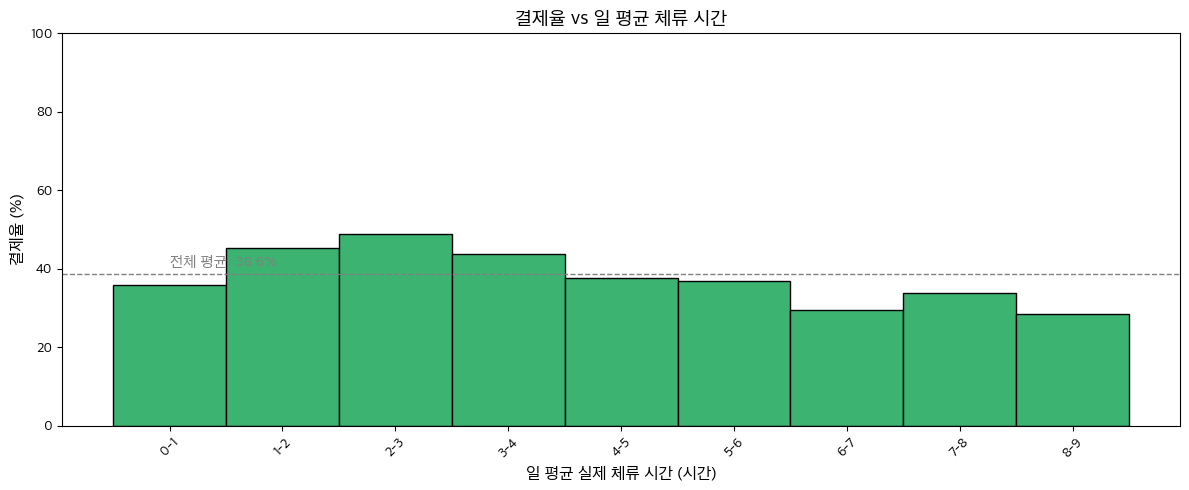

In [109]:
# 1. 1시간 단위 bin 설정
bins = np.arange(0, 10, 1)

# 2. 10시간 미만 사용자 필터링
filtered_user = user[user['mean_stay_time_hour'] < 10].copy()

# 3. bin 지정
filtered_user['stay_time_bin'] = pd.cut(filtered_user['mean_stay_time_hour'], bins=bins, right=False)

# 4. 각 bin별 전환율 계산 (여기선 is_payment를 전환 지표로 사용)
conversion_rate = (
    filtered_user.groupby('stay_time_bin')['is_payment']
    .mean()
    .round(3) * 100  # 백분율
)

# 5. 시각화
plt.figure(figsize=(12, 5))
plt.bar(range(len(conversion_rate)), conversion_rate, width=1.0, align='center',
        color='mediumseagreen', edgecolor='black')

# 6. x축 눈금 설정
bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in conversion_rate.index]
plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
plt.ylim(0, 100)

# 7. 전체 평균 전환율 표시선
overall_rate = user['is_payment'].mean() * 100
plt.axhline(overall_rate, color='gray', linestyle='--', linewidth=1)
plt.text(0, overall_rate + 2, f'전체 평균: {overall_rate:.1f}%', color='gray', fontsize=11)

# 8. 라벨링
plt.xlabel('일 평균 실제 체류 시간 (시간)', fontsize=12)
plt.ylabel('결제율 (%)', fontsize=12)
plt.title('결제율 vs 일 평균 체류 시간', fontsize=14)
plt.tight_layout()
plt.show()

#### 일 평균 체류시간 범주형 파생변수 (`stay_time_level`)

그래프를 보면 전환율이 일정하게 증가하거나 감소하지 않고, 특정 구간부터 감소하는 경향이 보입니다. 이를 고려하면 다음과 같은 기준으로 stay_time_level을 3개 정도의 구간으로 나누는 것이 합리적입니다:
1.	1레벨 (저 체류): mean_stay_time_hour < 3
	-	사용자 비율 많음
	-	전환율 평균 또는 평균 이상
2.	2레벨 (중 체류): 3 ≤ mean_stay_time_hour < 6
	-	전환율 가장 높은 구간 포함
3.	3레벨 (고 체류): mean_stay_time_hour ≥ 6
	-	전환율이 급격히 떨어지는 구간

In [110]:
def categorize_stay_time(hour):
    if hour < 3:
        return 1
    elif hour < 6:
        return 2
    else:
        return 3

user['mean_stay_time_level'] = user['mean_stay_time_hour'].apply(categorize_stay_time).astype('int64')

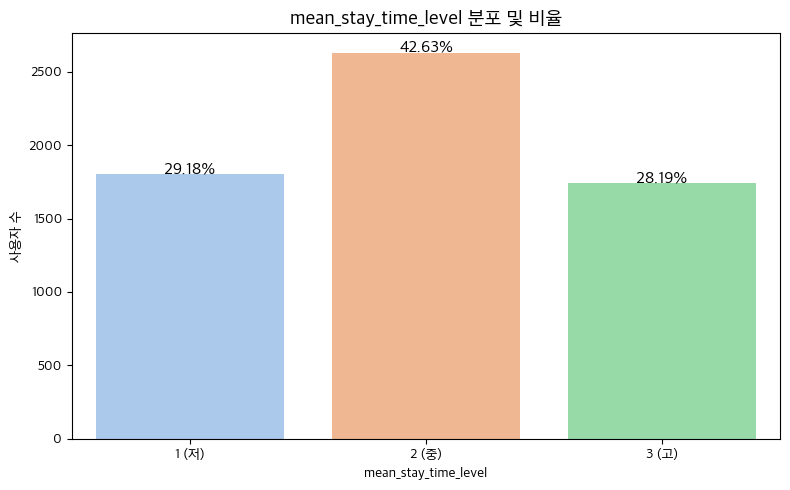

In [111]:
# 1. 분포 계산
level_counts = user['mean_stay_time_level'].value_counts().sort_index()
level_percent = (level_counts / level_counts.sum() * 100).round(2)

# 2. 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=level_counts.index, y=level_counts.values, palette='pastel')

# 3. 비율 텍스트 추가
for i, (count, percent) in enumerate(zip(level_counts, level_percent)):
    plt.text(i, count + 1, f'{percent:.2f}%', ha='center', fontsize=12)

# 4. 꾸미기
plt.xticks(ticks=[0, 1, 2], labels=['1 (저)', '2 (중)', '3 (고)'])
plt.xlabel('mean_stay_time_level')
plt.ylabel('사용자 수')
plt.title('mean_stay_time_level 분포 및 비율', fontsize=14)
plt.tight_layout()
plt.show()

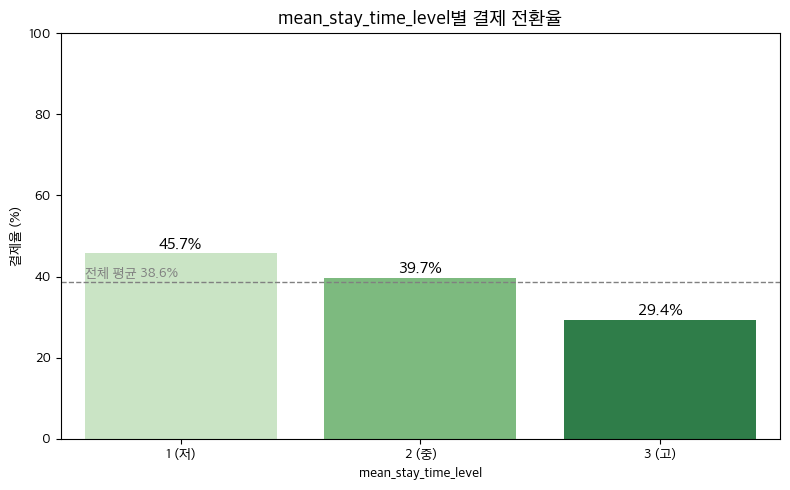

In [112]:
# 1. 그룹별 전환율 계산
conversion_by_level = user.groupby('mean_stay_time_level')['is_payment'].mean().round(3) * 100

# 2. 전체 평균 전환율
overall_conversion = user['is_payment'].mean().round(3) * 100

# 3. 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_level.index, y=conversion_by_level.values, palette='Greens')

# 4. 수치 라벨 추가
for i, rate in enumerate(conversion_by_level.values):
    plt.text(i, rate + 1, f'{rate:.1f}%', ha='center', fontsize=12)

# 5. 평균선 표시
plt.axhline(overall_conversion, color='gray', linestyle='--', linewidth=1)
plt.text(-0.4, overall_conversion + 1, f'전체 평균 {overall_conversion:.1f}%', color='gray')

# 6. 꾸미기
plt.xticks(ticks=[0, 1, 2], labels=['1 (저)', '2 (중)', '3 (고)'])
plt.xlabel('mean_stay_time_level')
plt.ylabel('결제율 (%)')
plt.title('mean_stay_time_level별 결제 전환율', fontsize=14)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### 이진 파생변수: 긴 체류시간 (`long_stay`)

mean_stay_time_hour의 분포를 보면, 약 4시간을 전후로 사용자 분포가 어느 정도 균형 있게 나뉘며,
이를 기준으로 일 평균 실제 체류 시간이 긴 사용자와 그렇지 않은 사용자를 구분하기 적절합니다.

In [113]:
# 파생 변수 생성: long_stay_user
user['long_stay'] = (user['mean_stay_time_hour'] >= 4).astype(int)

In [114]:
# 열 확인
user.columns

Index(['user_uuid', 'first_visit', 'last_visit', 'total_checkins',
       'stay_time_hour', 'days', 'is_payment', 'trial_date',
       'visit_delay_days', 'mean_checkins_per_day', 'mean_checkins_level',
       'frequent_checkins', 'mean_stay_time_hour', 'mean_stay_time_level',
       'long_stay'],
      dtype='object')

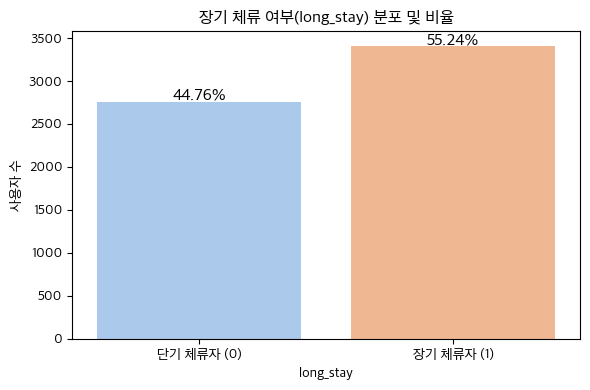

In [115]:
# 1. 값 계산
longstay_counts = user['long_stay'].value_counts().sort_index()
longstay_percent = (longstay_counts / len(user) * 100).round(2)

# 2. 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=longstay_counts.index, y=longstay_counts.values, palette='pastel')

# 3. 비율 텍스트 추가
for i, (count, percent) in enumerate(zip(longstay_counts, longstay_percent)):
    plt.text(i, count + 10, f'{percent}%', ha='center', fontsize=12)

# 4. 꾸미기
plt.xticks([0, 1], ['단기 체류자 (0)', '장기 체류자 (1)'])
plt.ylabel('사용자 수')
plt.title('장기 체류 여부(long_stay) 분포 및 비율')
plt.tight_layout()
plt.show()

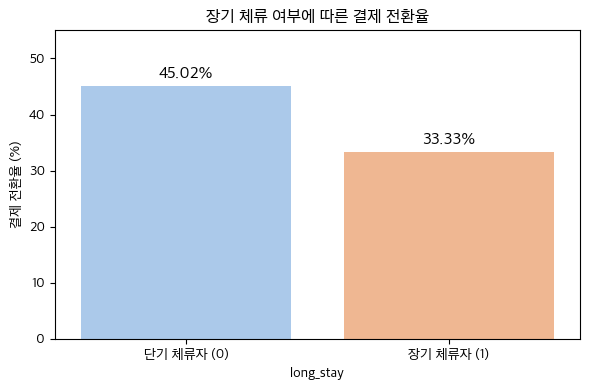

In [116]:
# 1. 결제 전환율 계산
longstay_conversion = user.groupby('long_stay')['is_payment'].mean().round(4) * 100

# 2. 시각화
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=longstay_conversion.index, y=longstay_conversion.values, palette='pastel')

# 3. 텍스트 추가 (막대 위에 배치)
for i, val in enumerate(longstay_conversion.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. 꾸미기
plt.xticks([0, 1], ['단기 체류자 (0)', '장기 체류자 (1)'])
plt.ylabel('결제 전환율 (%)')
plt.title('장기 체류 여부에 따른 결제 전환율')
plt.ylim(0, max(longstay_conversion.values) + 10)  # 텍스트 공간 확보
plt.tight_layout()
plt.show()

#### 📌 인사이트 요약

- 전체 사용자 중 장기 체류자는 약 55.24%로 단기 체류자와 비슷한 비율을 차지함.
- 그러나 장기 체류자의 결제 전환율은 33.33%로, 단기 체류자(45.02%)에 비해 11.69%p 낮음.
- 장시간 머문다고 해서 반드시 결제로 이어지는 것은 아님을 시사함.
- 오히려 짧게 체류하는 사용자군이 더 적극적인 전환 행동을 보일 수 있음.

### 2.3.3 첫 방문 관련 파생변수

#### 첫 방문 월 (`first_visit_month`)

In [117]:
# first_visit_month 파생 변수 생성
user['first_visit_month'] = user['first_visit'].dt.month.astype('int64')

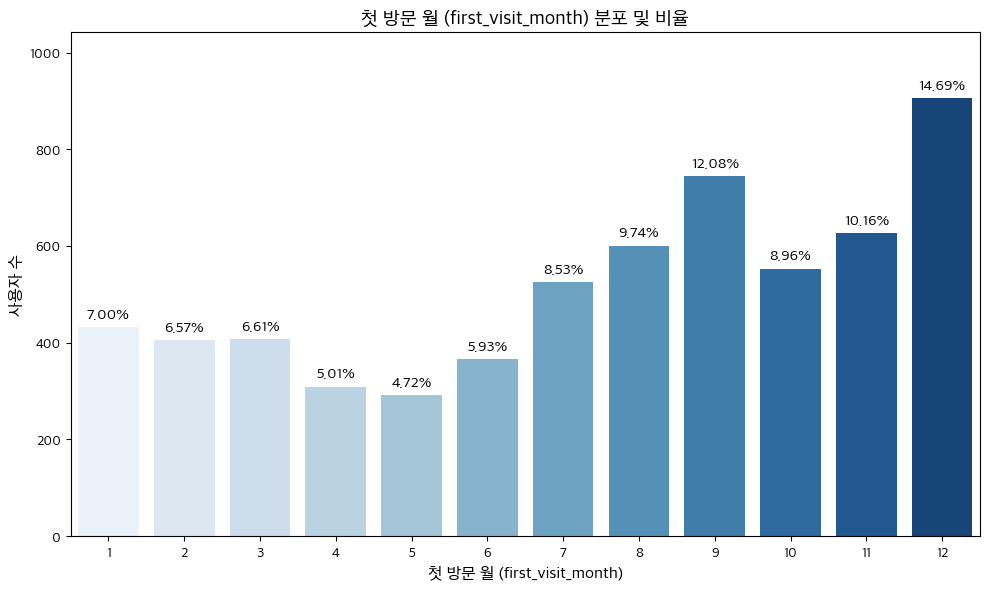

In [118]:
# 1. first_visit_month의 값 계산
first_visit_month_counts = user['first_visit_month'].value_counts().sort_index()
first_visit_month_percent = (first_visit_month_counts / len(user) * 100).round(2)

# 2. 시각화 (막대그래프)
plt.figure(figsize=(10, 6)) # 그래프 크기를 설정합니다.
ax = sns.barplot(x=first_visit_month_counts.index, y=first_visit_month_counts.values, palette='Blues')

# 3. 각 막대 위에 비율 텍스트를 추가합니다.
for i, (count, percent) in enumerate(zip(first_visit_month_counts, first_visit_month_percent)):
    plt.text(i, count + (ax.get_ylim()[1] * 0.02), f'{percent:.2f}%', ha='center', fontsize=11)

# 4. 그래프를 꾸밉니다.
plt.xlabel('첫 방문 월 (first_visit_month)', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.title('첫 방문 월 (first_visit_month) 분포 및 비율', fontsize=14)
plt.ylim(0, first_visit_month_counts.max() * 1.15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

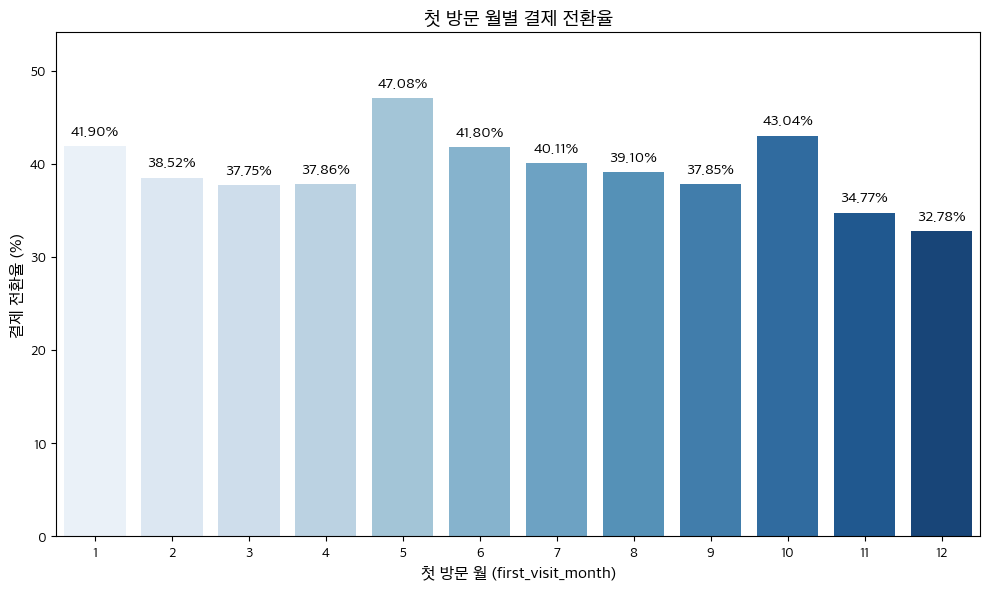

In [119]:
# 1. 첫 방문 월별 결제 전환율 계산
visit_month_conversion = user.groupby('first_visit_month')['is_payment'].mean().round(4) * 100

# 2. 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=visit_month_conversion.index, y=visit_month_conversion.values, palette='Blues')

# 3. 막대 위 텍스트 표시
for i, val in enumerate(visit_month_conversion.values):
    plt.text(i, val + (ax.get_ylim()[1] * 0.02), f'{val:.2f}%', ha='center', va='bottom', fontsize=11)

# 4. 꾸미기
plt.xlabel('첫 방문 월 (first_visit_month)', fontsize=12)
plt.ylabel('결제 전환율 (%)', fontsize=12)
plt.title('첫 방문 월별 결제 전환율', fontsize=14)
plt.ylim(0, visit_month_conversion.max() * 1.15 if not visit_month_conversion.empty else 10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 첫 방문 분기 (`first_visit_q`)

In [120]:
user['first_visit_q'] = ((user['first_visit_month'] - 1) // 3 + 1).astype('int64')

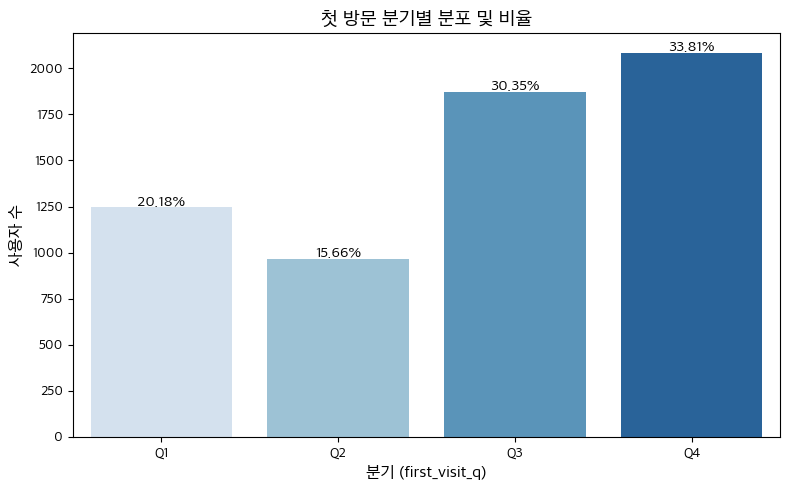

In [121]:
# 분포 계산
q_counts = user['first_visit_q'].value_counts().sort_index()
q_percent = (q_counts / q_counts.sum() * 100).round(2)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=q_counts.index, y=q_counts.values, palette='Blues')

# 값 라벨 표시
for i, (count, percent) in enumerate(zip(q_counts, q_percent)):
    plt.text(i, count + 10, f"{percent}%", ha='center', fontsize=11)

# 꾸미기
plt.title("첫 방문 분기별 분포 및 비율", fontsize=14)
plt.xlabel("분기 (first_visit_q)", fontsize=12)
plt.ylabel("사용자 수", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.tight_layout()
plt.show()

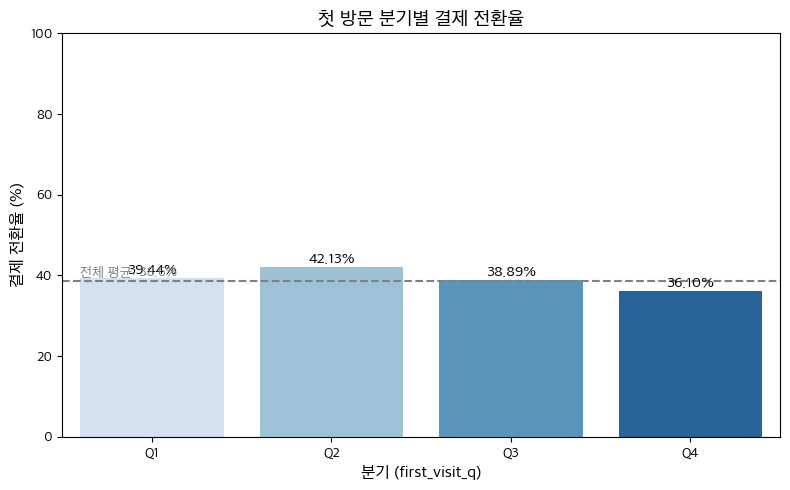

In [122]:
# 전환율 계산
conversion_by_q = user.groupby('first_visit_q')['is_payment'].mean().round(4) * 100
conversion_by_q = conversion_by_q.sort_index()

# 전체 평균 전환율
avg_conversion = user['is_payment'].mean() * 100

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_q.index, y=conversion_by_q.values, palette='Blues')

# 라벨 표시
for i, val in enumerate(conversion_by_q.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=11)

# 전체 평균 기준선
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1, f'전체 평균: {avg_conversion:.1f}%', color='gray')

# 꾸미기
plt.title("첫 방문 분기별 결제 전환율", fontsize=14)
plt.xlabel("분기 (first_visit_q)", fontsize=12)
plt.ylabel("결제 전환율 (%)", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### 첫 방문 계절 (`first_visit_season`)

In [123]:
def month_to_season(m):
    if m in [12, 1, 2]: return '4'
    if m in [3, 4, 5]: return '1'
    if m in [6, 7, 8]: return '2'
    return '3'

user['first_visit_season'] = user['first_visit_month'].apply(month_to_season)

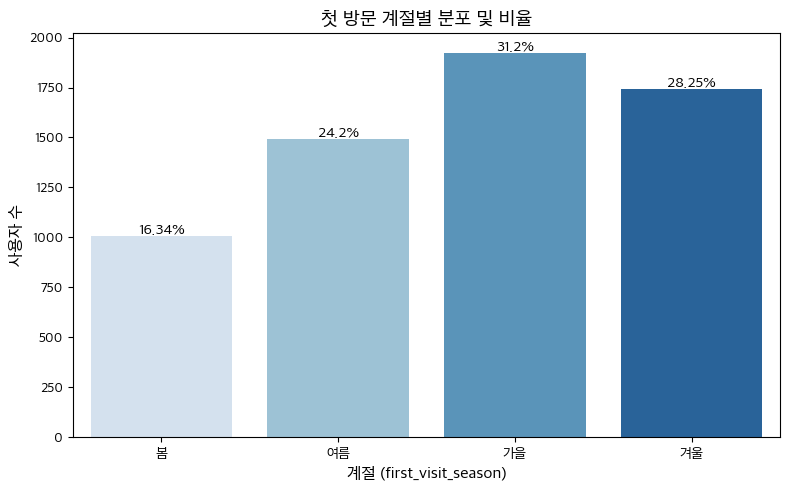

In [124]:
# 분포 계산
season_counts = user['first_visit_season'].value_counts().sort_index()
season_percent = (season_counts / season_counts.sum() * 100).round(2)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=season_counts.index, y=season_counts.values, palette='Blues')

# 값 라벨 표시
for i, (count, percent) in enumerate(zip(season_counts, season_percent)):
    plt.text(i, count + 10, f"{percent}%", ha='center', fontsize=11)

# 꾸미기
plt.title("첫 방문 계절별 분포 및 비율", fontsize=14)
plt.xlabel("계절 (first_visit_season)", fontsize=12)
plt.ylabel("사용자 수", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['봄', '여름', '가을', '겨울'])
plt.tight_layout()
plt.show()

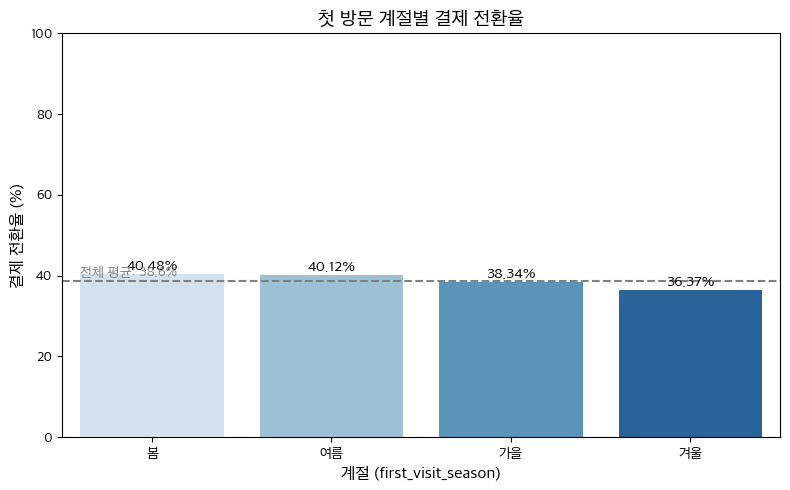

In [125]:
# 전환율 계산
conversion_by_season = user.groupby('first_visit_season')['is_payment'].mean().round(4) * 100
conversion_by_season = conversion_by_season.sort_index()

# 전체 평균 전환율
avg_conversion = user['is_payment'].mean() * 100

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_season.index, y=conversion_by_season.values, palette='Blues')

# 라벨 표시
for i, val in enumerate(conversion_by_season.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=11)

# 전체 평균 기준선
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1, f'전체 평균: {avg_conversion:.1f}%', color='gray')

# 꾸미기
plt.title("첫 방문 계절별 결제 전환율", fontsize=14)
plt.xlabel("계절 (first_visit_season)", fontsize=12)
plt.ylabel("결제 전환율 (%)", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['봄', '여름', '가을', '겨울'])
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### 이진 파생변수: 전환율 높은 월 (`high_convert_month`)

In [126]:
user['high_convert_month'] = user['first_visit_month'].isin([5, 6, 10]).astype(int)

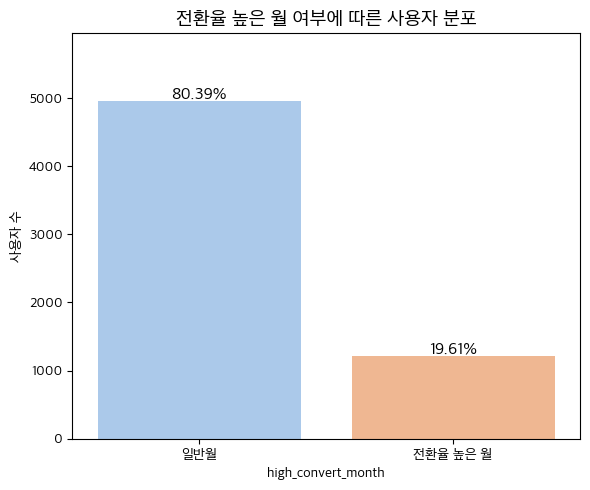

In [127]:
# 1. 값과 비율 계산
counts = user['high_convert_month'].value_counts().sort_index()
percent = (counts / counts.sum() * 100).round(2)

# 2. 시각화
plt.figure(figsize=(6, 5))
sns.barplot(x=counts.index.map({0: '일반월', 1: '전환율 높은 월'}), y=counts.values, palette='pastel')

# 3. 비율 텍스트 표시
for i, (count, pct) in enumerate(zip(counts, percent)):
    plt.text(i, count + 20, f'{pct:.2f}%', ha='center', fontsize=12)

# 4. 라벨 및 꾸미기
plt.title('전환율 높은 월 여부에 따른 사용자 분포', fontsize=14)
plt.ylabel('사용자 수')
plt.xlabel('high_convert_month')
plt.ylim(0, counts.max() * 1.2)
plt.tight_layout()
plt.show()

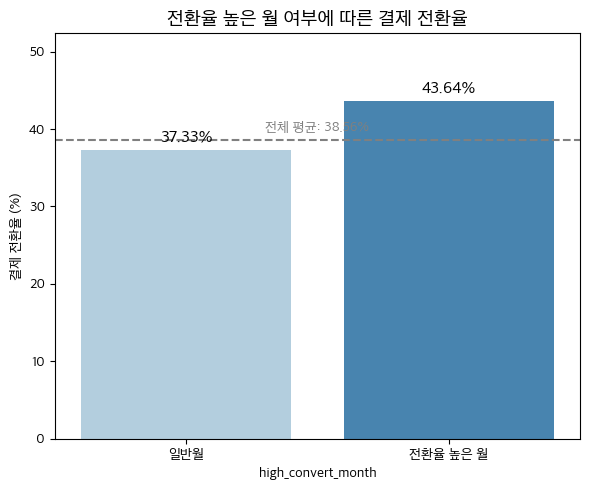

In [128]:
# 1. 전환율 계산
conversion_rate = user.groupby('high_convert_month')['is_payment'].mean().mul(100).round(2)

# 2. 전체 평균 전환율
overall_rate = user['is_payment'].mean() * 100

# 3. 시각화
plt.figure(figsize=(6, 5))
sns.barplot(x=conversion_rate.index.map({0: '일반월', 1: '전환율 높은 월'}),
            y=conversion_rate.values, palette='Blues')

# 4. 라벨링
for i, rate in enumerate(conversion_rate.values):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', fontsize=12)

# 5. 전체 평균선
plt.axhline(overall_rate, color='gray', linestyle='--')
plt.text(0.5, overall_rate + 1, f'전체 평균: {overall_rate:.2f}%', ha='center', fontsize=10, color='gray')

# 6. 기타 설정
plt.title('전환율 높은 월 여부에 따른 결제 전환율', fontsize=14)
plt.ylabel('결제 전환율 (%)')
plt.xlabel('high_convert_month')
plt.ylim(0, max(conversion_rate.max(), overall_rate) * 1.2)
plt.tight_layout()
plt.show()

#### 첫 방문 시간 (`first_visit_hour`)

In [129]:
# first_visit_hour 파생 변수 생성
user['first_visit_hour'] = user['first_visit'].dt.hour.astype('int64')

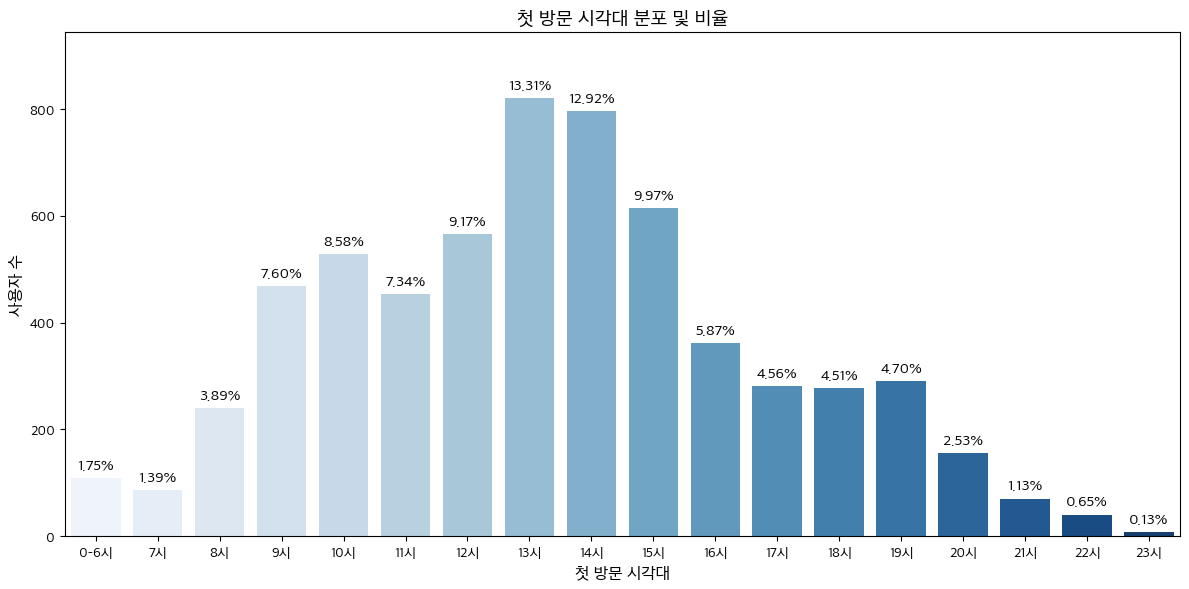

In [130]:
# 0. 먼저 first_visit_hour를 기반으로 새 시각대 그룹 변수 생성
def map_hour_group(hour):
    return '0–6시' if hour <= 6 else f'{hour}시'

user['first_visit_hour_group'] = user['first_visit_hour'].apply(map_hour_group)

# 1. 원하는 순서대로 라벨 리스트 생성
hour_labels = ['0–6시'] + [f'{h}시' for h in range(7, 24)]

# 2. 라벨을 Categorical로 변환 (순서 보장)
hour_group = pd.Categorical(user['first_visit_hour_group'], categories=hour_labels, ordered=True)
user = user.drop(columns=['first_visit_hour_group'])

# 3. 값 계산 (정렬 자동 보장됨)
group_counts = hour_group.value_counts().sort_index()
group_percent = (group_counts / len(user) * 100).round(2)

# 4. 시각화
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=group_counts.index, y=group_counts.values, palette='Blues')

# 텍스트 추가
for i, (count, percent) in enumerate(zip(group_counts, group_percent)):
    plt.text(i, count + (ax.get_ylim()[1] * 0.02), f'{percent:.2f}%', ha='center', fontsize=11)

plt.xlabel('첫 방문 시각대', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.title('첫 방문 시각대 분포 및 비율', fontsize=14)
plt.ylim(0, group_counts.max() * 1.15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

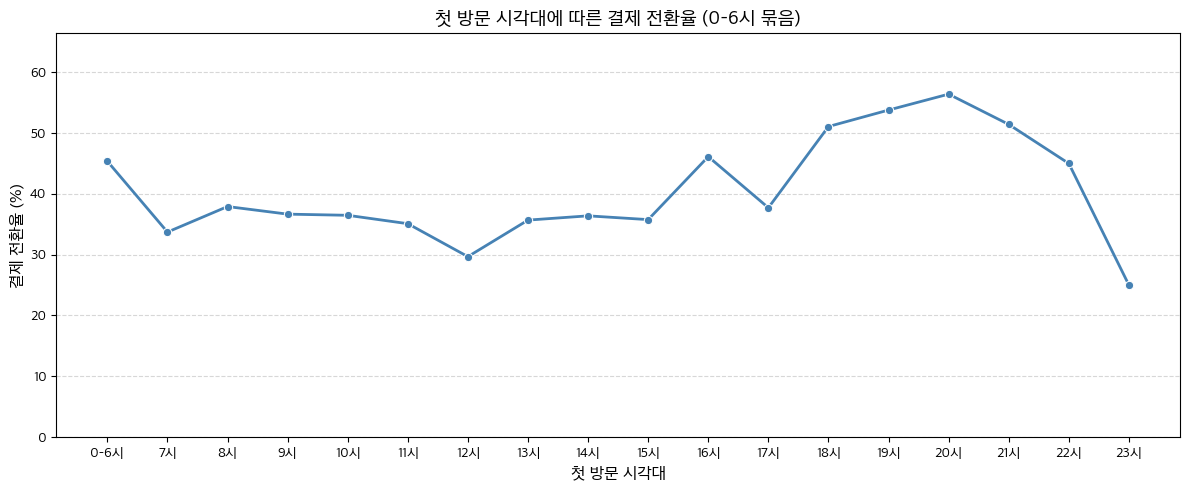

In [131]:
# 1. 시각대 그룹화 함수
def group_hour(hour):
    return '0–6시' if hour in range(0, 7) else f'{hour}시'

# 2. 그룹 라벨 생성 및 순서 지정
hour_group = user['first_visit_hour'].apply(group_hour)
hour_labels = ['0–6시'] + [f'{h}시' for h in range(7, 24)]
hour_group_cat = pd.Categorical(hour_group, categories=hour_labels, ordered=True)

# 3. 전환율 계산
conversion = user.groupby(hour_group_cat)['is_payment'].mean().reset_index()
conversion.columns = ['first_visit_hour', 'conversion_rate']
conversion['conversion_rate'] = (conversion['conversion_rate'] * 100).round(2)

# 4. 시각화
plt.figure(figsize=(12, 5))
sns.lineplot(x=conversion['first_visit_hour'], y=conversion['conversion_rate'],
             marker='o', linewidth=2, color='steelblue')

# 5. 꾸미기
plt.xlabel('첫 방문 시각대', fontsize=12)
plt.ylabel('결제 전환율 (%)', fontsize=12)
plt.title('첫 방문 시각대에 따른 결제 전환율 (0–6시 묶음)', fontsize=14)
plt.ylim(0, conversion['conversion_rate'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- 전환율 분석 결과, 18시~21시에 방문한 사용자의 결제 전환율이 유독 높게 나타났습니다.  
- 저녁 시간대 방문 여부는 모델의 예측력을 높이는 데 기여할 가능성이 있습니다.  
- 이에 따라 해당 시간대 방문 여부를 나타내는 이진 변수 `evening_visit`을 파생시킵니다.

#### 이진 파생변수: 저녁 방문 (`evening_visit`)

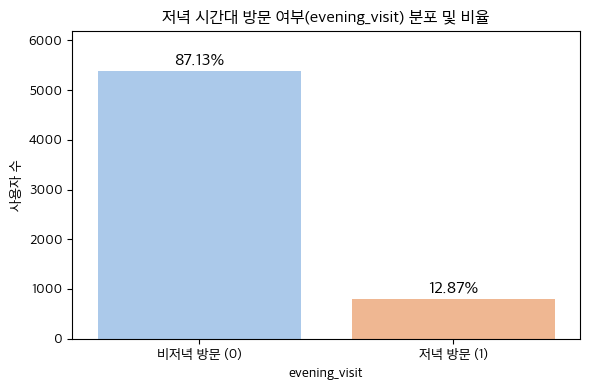

In [132]:
# 1. evening_visit 파생 (18시~21시: 1, 나머지: 0)
user['evening_visit'] = user['first_visit_hour'].isin([18, 19, 20, 21]).astype("int64")

# 2. 기존 first_visit_hour 컬럼 제거
user = user.drop(columns='first_visit_hour')

# 3. 사용자 수 및 비율 계산
evening_counts = user['evening_visit'].value_counts().sort_index()
evening_percent = (evening_counts / len(user) * 100).round(2)

# 4. 시각화
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=evening_counts.index, y=evening_counts.values, palette='pastel')

# 5. 텍스트 표시
for i, (count, percent) in enumerate(zip(evening_counts, evening_percent)):
    plt.text(i, count + (ax.get_ylim()[1] * 0.02), f'{percent}%', ha='center', fontsize=12)

# 6. 꾸미기
plt.xticks([0, 1], ['비저녁 방문 (0)', '저녁 방문 (1)'])
plt.xlabel('evening_visit')
plt.ylabel('사용자 수')
plt.title('저녁 시간대 방문 여부(evening_visit) 분포 및 비율')
plt.ylim(0, evening_counts.max() * 1.15)
plt.tight_layout()
plt.show()

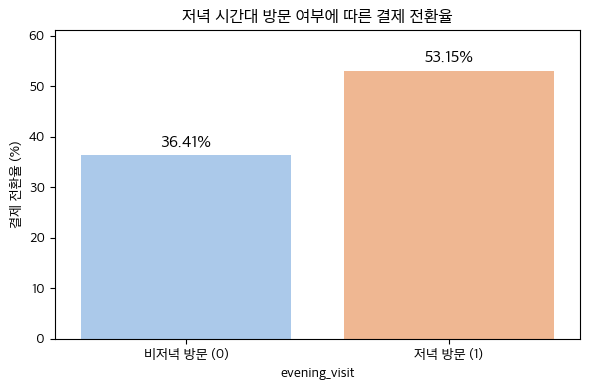

In [133]:
# 1. 전환율 계산
evening_conversion = user.groupby('evening_visit')['is_payment'].mean().round(4) * 100

# 2. 시각화
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=evening_conversion.index, y=evening_conversion.values, palette='pastel')

# 3. 텍스트 표시
for i, val in enumerate(evening_conversion.values):
    plt.text(i, val + (ax.get_ylim()[1] * 0.02), f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. 꾸미기
plt.xticks([0, 1], ['비저녁 방문 (0)', '저녁 방문 (1)'])
plt.xlabel('evening_visit')
plt.ylabel('결제 전환율 (%)')
plt.title('저녁 시간대 방문 여부에 따른 결제 전환율')
plt.ylim(0, evening_conversion.max() * 1.15)
plt.tight_layout()
plt.show()

#### 인사이트
- 저녁 시간대(18시~21시) 방문자는 전체의 12.87%에 불과하지만, 결제 전환율은 53.15%로 매우 높습니다.  
- 전환율이 평균보다 유의하게 높아 예측 모델의 주요 피처로 활용할 수 있습니다.  

#### 첫 방문 요일 (`first_visit_dayofweek`)

In [134]:
# 요일 파생 변수 생성 (월=0, 일=6 기준)
user['first_visit_dayofweek'] = user['first_visit'].dt.dayofweek.astype('int64')

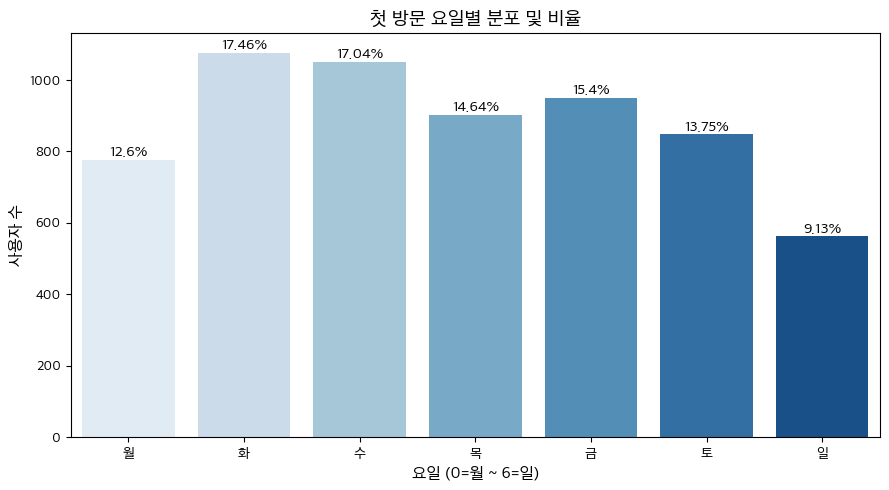

In [135]:
# 요일 이름 매핑
day_labels = ['월', '화', '수', '목', '금', '토', '일']

# 분포 및 비율 계산
dow_counts = user['first_visit_dayofweek'].value_counts().sort_index()
dow_percent = (dow_counts / dow_counts.sum() * 100).round(2)

# 시각화
plt.figure(figsize=(9, 5))
sns.barplot(x=dow_counts.index, y=dow_counts.values, palette='Blues')

# 비율 라벨 표시
for i, (count, percent) in enumerate(zip(dow_counts, dow_percent)):
    plt.text(i, count + 10, f"{percent}%", ha='center', fontsize=11)

# 꾸미기
plt.title("첫 방문 요일별 분포 및 비율", fontsize=14)
plt.xlabel("요일 (0=월 ~ 6=일)", fontsize=12)
plt.ylabel("사용자 수", fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels)
plt.tight_layout()
plt.show()

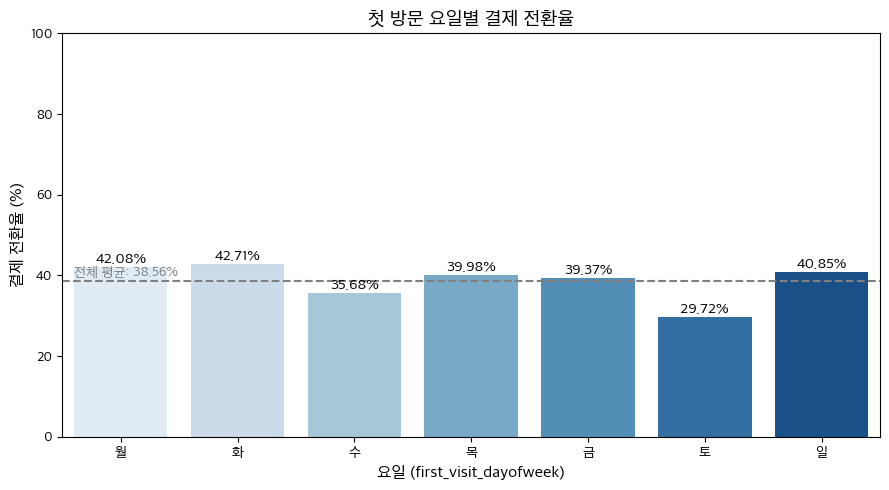

In [136]:
# 요일 이름 매핑
day_labels = ['월', '화', '수', '목', '금', '토', '일']

# 요일별 전환율 계산
conversion_by_dow = user.groupby('first_visit_dayofweek')['is_payment'].mean().round(4) * 100
conversion_by_dow = conversion_by_dow.sort_index()

# 전체 평균 전환율
avg_conversion = user['is_payment'].mean() * 100

# 시각화
plt.figure(figsize=(9, 5))
sns.barplot(x=conversion_by_dow.index, y=conversion_by_dow.values, palette='Blues')

# 비율 라벨 표시
for i, val in enumerate(conversion_by_dow.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=11)

# 전체 평균 기준선
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1, f'전체 평균: {avg_conversion:.2f}%', color='gray')

# 꾸미기
plt.title("첫 방문 요일별 결제 전환율", fontsize=14)
plt.xlabel("요일 (first_visit_dayofweek)", fontsize=12)
plt.ylabel("결제 전환율 (%)", fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### 이진 파생변수: 전환율 높은 요일 (`high_convert_dayofweek`)
- 전환율이 특히 높은 화요일, 일요일 여부를 구분하는 파생변수를 생성합니다.

In [137]:
user['high_convert_dayofweek'] = user['first_visit_dayofweek'].isin([1, 6]).astype(int)

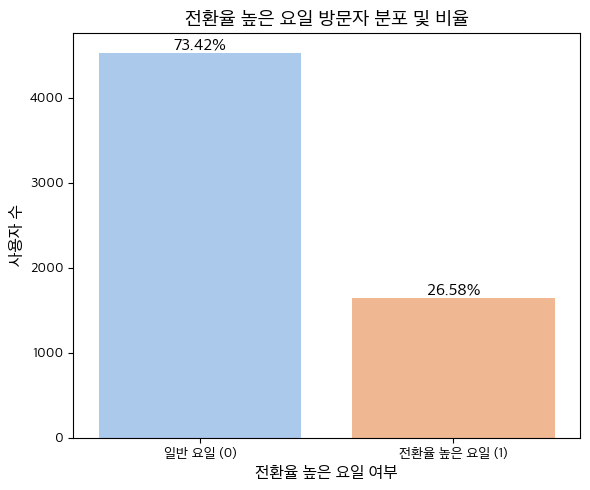

In [138]:
# 분포 및 비율 계산
day_flag_counts = user['high_convert_dayofweek'].value_counts().sort_index()
day_flag_percent = (day_flag_counts / day_flag_counts.sum() * 100).round(2)

# 시각화
plt.figure(figsize=(6, 5))
sns.barplot(x=day_flag_counts.index, y=day_flag_counts.values, palette='pastel')

# 값 라벨 표시
labels = ['일반 요일 (0)', '전환율 높은 요일 (1)']
for i, (count, percent) in enumerate(zip(day_flag_counts, day_flag_percent)):
    plt.text(i, count + 30, f'{percent}%', ha='center', fontsize=12)

# 꾸미기
plt.xticks([0, 1], labels)
plt.xlabel('전환율 높은 요일 여부', fontsize=12)
plt.ylabel('사용자 수', fontsize=12)
plt.title('전환율 높은 요일 방문자 분포 및 비율', fontsize=14)
plt.tight_layout()
plt.show()

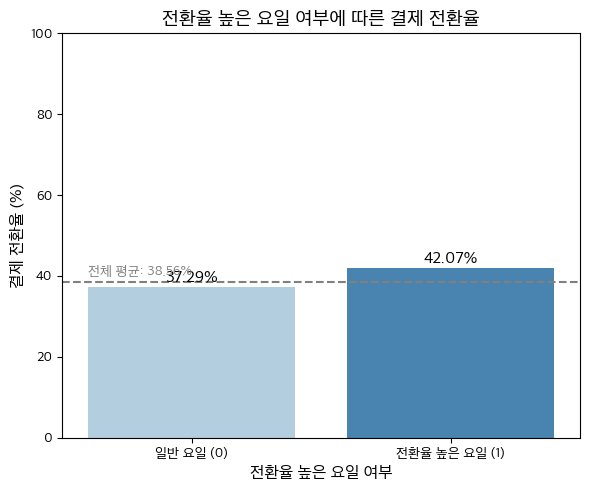

In [139]:
# 전환율 계산
conversion_by_dayflag = user.groupby('high_convert_dayofweek')['is_payment'].mean().round(4) * 100
conversion_by_dayflag = conversion_by_dayflag.sort_index()

# 전체 평균 전환율
avg_conversion = user['is_payment'].mean() * 100

# 시각화
plt.figure(figsize=(6, 5))
sns.barplot(x=conversion_by_dayflag.index, y=conversion_by_dayflag.values, palette='Blues')

# 값 라벨 표시
for i, val in enumerate(conversion_by_dayflag.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=12)

# 전체 평균 기준선
plt.axhline(avg_conversion, color='gray', linestyle='--')
plt.text(-0.4, avg_conversion + 1.5, f'전체 평균: {avg_conversion:.2f}%', color='gray')

# 꾸미기
plt.xticks([0, 1], ['일반 요일 (0)', '전환율 높은 요일 (1)'])
plt.xlabel('전환율 높은 요일 여부', fontsize=12)
plt.ylabel('결제 전환율 (%)', fontsize=12)
plt.title('전환율 높은 요일 여부에 따른 결제 전환율', fontsize=14)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

#### 이진 파생변수: 주말 첫 방문 (`first_visit_is_weekend`)

In [140]:
# 주말 여부 파생변수 생성: 토(5), 일(6)이면 1, 아니면 0
user['first_visit_is_weekend'] = user['first_visit'].dt.dayofweek.isin([5, 6]).astype(int)

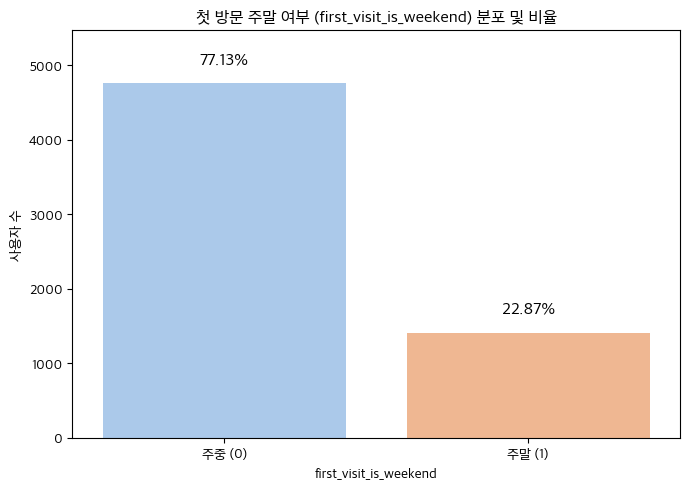

In [141]:
# 1. first_visit_is_weekend 값 계산
# value_counts()로 각 범주(0: 주중, 1: 주말)의 개수를 세고, sort_index()로 정렬합니다.
first_visit_weekend_counts = user['first_visit_is_weekend'].value_counts().sort_index()
# 전체 사용자 수 대비 각 범주의 비율을 퍼센트로 계산하고 소수점 둘째 자리까지 반올림합니다.
first_visit_weekend_percent = (first_visit_weekend_counts / len(user) * 100).round(2)

# 2. 시각화 (막대그래프)
plt.figure(figsize=(7, 5)) # 그래프 크기를 설정합니다.
# seaborn의 barplot을 사용하여 막대그래프를 그립니다.
# x축은 범주 (0 또는 1), y축은 해당 범주의 사용자 수입니다.
ax = sns.barplot(x=first_visit_weekend_counts.index, y=first_visit_weekend_counts.values, palette='pastel')

# 3. 각 막대 위에 비율 텍스트를 추가합니다.
for i, (count, percent) in enumerate(zip(first_visit_weekend_counts, first_visit_weekend_percent)):
    # 텍스트 위치를 막대 높이의 약 5% 위로 설정하여 겹치지 않도록 합니다.
    plt.text(i, count + (ax.get_ylim()[1] * 0.05), f'{percent:.2f}%', ha='center', fontsize=12)

# 4. 그래프를 꾸밉니다.
# x축 틱 레이블을 '주중 (0)'와 '주말 (1)'로 변경하여 의미를 명확히 합니다.
plt.xticks([0, 1], ['주중 (0)', '주말 (1)'])
plt.ylabel('사용자 수') # y축 레이블을 설정합니다.
plt.title('첫 방문 주말 여부 (first_visit_is_weekend) 분포 및 비율') # 그래프 제목을 설정합니다.
plt.ylim(0, first_visit_weekend_counts.max() * 1.15) # Y축 범위를 조정하여 텍스트가 잘 보이도록 합니다.
plt.tight_layout() # 그래프 요소들이 잘 보이도록 레이아웃을 자동으로 조정합니다.
plt.show() # 그래프를 화면에 표시합니다.


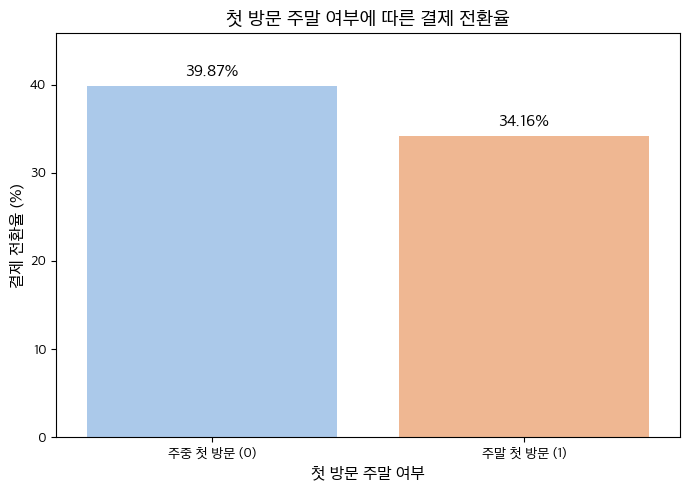

In [142]:
# 1. first_visit_is_weekend 별 결제 전환율 계산
first_visit_weekend_conversion = user.groupby('first_visit_is_weekend')['is_payment'].mean().round(4) * 100

# 2. 시각화 (막대그래프)
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=first_visit_weekend_conversion.index, y=first_visit_weekend_conversion.values, palette='pastel')

# 3. 텍스트 추가 (막대 위에 배치)
for i, val in enumerate(first_visit_weekend_conversion.values):
    plt.text(i, val + (ax.get_ylim()[1] * 0.02), f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

# 4. 그래프를 꾸밉니다.
plt.xlabel('첫 방문 주말 여부', fontsize=12)
plt.ylabel('결제 전환율 (%)', fontsize=12)
plt.title('첫 방문 주말 여부에 따른 결제 전환율', fontsize=14)
plt.ylim(0, first_visit_weekend_conversion.max() * 1.15 if not first_visit_weekend_conversion.empty else 10)
plt.xticks([0, 1], ['주중 첫 방문 (0)', '주말 첫 방문 (1)'])
plt.tight_layout()
plt.show()

In [143]:
from statsmodels.stats.proportion import proportions_ztest

# 주중 (0) vs 주말 (1) 그룹의 성공(1) 수와 전체 수
success = user.groupby('first_visit_is_weekend')['is_payment'].sum().values
nobs = user.groupby('first_visit_is_weekend')['is_payment'].count().values

# Z-test 실행
z_stat, p_val = proportions_ztest(count=success, nobs=nobs)

print(f"Z-statistic = {z_stat:.3f}")
print(f"P-value = {p_val:.4f}")

Z-statistic = 3.870
P-value = 0.0001


#### 인사이트
- 주중 방문 고객의 높은 전환 잠재력: 공유오피스 주중 방문 고객은 주말 방문 고객보다 결제 전환율이 약  5.71%p 더 높습니다.
- 마케팅 전략 차별화: 주중 고객은 높은 전환율 유지를 위한 최적화된 온보딩 및 프로모션을, 주말 고객은 맞춤형 가치 제안으로 전환율 향상 방안을 모색해야 합니다.
- 리소스 집중: 신규 고객 유치 및 전환 리소스를 주중 방문 고객에게 집중하고, 주말 고객을 위한 맞춤형 전략 개발에 투자하여 효율성을 높일 수 있습니다.

#### 이진 파생변수: 혼잡한 시간대 (`peak_top5`)

In [150]:
user['first_visit_hour'] = user.first_visit.apply(lambda x: x.hour)
is_payment_hour_cnt = user.query('is_payment == 1')['first_visit_hour'].value_counts().sort_values(ascending=False)
is_payment_hour_cnt_df = pd.DataFrame(is_payment_hour_cnt, columns=['count'])

hour_counts = user['first_visit_hour'].value_counts().sort_values(ascending=False)
hour_counts_df = pd.DataFrame(hour_counts, columns=['count'])

display(is_payment_hour_cnt_df.head(10))
display(hour_counts_df.head(10))

,count
first_visit_hour,
13,293
14,290
15,220
10,193
9,172
12,168
16,167
11,159
19,156


,count
first_visit_hour,
13,821
14,797
15,615
12,566
10,529
9,469
11,453
16,362
19,290


In [151]:
# 혼잡한 시간대 top5 안에 있으면 1, 아닐시 0
hour_rank_map = {hour: rank+1 for rank, hour in enumerate(hour_counts.index)}
user['visit_peak_rank'] = user['first_visit_hour'].map(hour_rank_map)
user['peak_top5'] = user['visit_peak_rank'].apply(lambda x: 1 if x <= 5 else 0).fillna(0).astype(int)
user = user.drop(columns='visit_peak_rank')

- 첫 방문 시간대가 사용자가 몰리는 혼잡한 시간대일수록 유료 전환율이 높다는 패턴이 관찰됨
- 이에 따라, 혼잡도를 기준으로 시간대를 4단계로 구분한 범주형 변수로 변환하여, 해당 변수를 유료 전환 여부를 예측하는 이진 분류 모델의 주요 피처로 활용

In [152]:
user.head()

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,mean_checkins_per_day,mean_checkins_level,frequent_checkins,mean_stay_time_hour,mean_stay_time_level,long_stay,first_visit_month,first_visit_q,first_visit_season,high_convert_month,evening_visit,first_visit_dayofweek,high_convert_dayofweek,first_visit_is_weekend,first_visit_hour,peak_top5
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,6.0,3,1,5.0,2,1,12,4,4,0,0,3,0,0,9,0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,2.0,2,0,3.0,2,0,12,4,4,0,0,3,0,0,4,0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0,2.0,2,0,1.0,1,0,12,4,4,0,1,3,0,0,21,0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0,2.0,2,0,1.0,1,0,12,4,4,0,1,3,0,0,21,0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0,2.0,2,0,2.0,1,0,12,4,4,0,0,4,0,0,15,1


In [153]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_uuid               6169 non-null   object        
 1   first_visit             6169 non-null   datetime64[ns]
 2   last_visit              6169 non-null   datetime64[ns]
 3   total_checkins          6169 non-null   int64         
 4   stay_time_hour          6169 non-null   int64         
 5   days                    6169 non-null   int64         
 6   is_payment              6169 non-null   int64         
 7   trial_date              6169 non-null   datetime64[ns]
 8   visit_delay_days        6169 non-null   int64         
 9   mean_checkins_per_day   6169 non-null   float64       
 10  mean_checkins_level     6169 non-null   int64         
 11  frequent_checkins       6169 non-null   int64         
 12  mean_stay_time_hour     6169 non-null   float64 

In [154]:
user.to_csv('user.csv', index=False)

In [5]:
user = pd.read_csv('user.csv', parse_dates=['first_visit', 'last_visit', 'trial_date'])
user.head()

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,mean_checkins_per_day,...,first_visit_month,first_visit_q,first_visit_season,high_convert_month,evening_visit,first_visit_dayofweek,high_convert_dayofweek,first_visit_is_weekend,first_visit_hour,peak_top5
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,6.0,...,12,4,4,0,0,3,0,0,9,0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,2.0,...,12,4,4,0,0,3,0,0,4,0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0,2.0,...,12,4,4,0,1,3,0,0,21,0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0,2.0,...,12,4,4,0,1,3,0,0,21,0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0,2.0,...,12,4,4,0,0,4,0,0,15,1


# 3. 모델링

## 3.1 모델링 준비

### 3.1.1 환경설정

In [5]:
sns.set_theme(
    style='white',
    font='Apple SD Gothic Neo', 
    palette='pastel',
    rc={
        'axes.unicode_minus': False, 
        'figure.figsize': (12, 6),   
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'axes.titleweight': 'bold',
        'axes.titlesize': 16
    }
)


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

### 3.1.2 평가 함수 생성

In [6]:
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score, 
                            confusion_matrix
)


def get_clf_eval(y_test, pred=None, pred_proba=None):
    conf_matix = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print(f"오차행렬:\n{conf_matix}")
    print(f"\n정확도: {accuracy:.4f}\n정밀도: {precision:.4f}\n재현율: {recall:.4f}\nf1_score: {f1:.4f}\nroc_auc: {roc_auc:.4f}")

### 3.1.3 훈련-테스트 데이터 분리

In [7]:
X = user.drop(columns=['user_uuid', 'is_payment', 'first_visit', 'last_visit', 'trial_date'])
y = user['is_payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=151)

## 3.2 베이스 라인 모델: <font color='tomato'>LogisticRegression</font>

### 3.2.1 기본 모델

- LogisticRegression을 선정한 이유는 해석이 직관적이고 명확하며, 단순하고 빠르게 학습이 가능해 성능 비교 기준점을 제공한다고 판단

In [8]:
# 베이스라인 로지스틱회귀 모델 정의
lr_clf_b = LogisticRegression(max_iter=1000, random_state=151)

# MLflow 실험 기록
mlflow.set_experiment("logistic_regression_experiment")

with mlflow.start_run(run_name='baseline_model'):
    lr_clf_b.fit(X_train, y_train)
    lr_b_pred = lr_clf_b.predict(X_test)
    lr_b_pred_proba = lr_clf_b.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, lr_b_pred, lr_b_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, lr_b_pred), 4)
    precision = np.round(precision_score(y_test, lr_b_pred), 4)
    recall = np.round(recall_score(y_test, lr_b_pred), 4)
    f1 = np.round(f1_score(y_test, lr_b_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, lr_b_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        "model_type": "LogisticRegression",
        "max_iter": 1000
    })

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

오차행렬:
[[990 147]
 [531 183]]

정확도: 0.6337
정밀도: 0.5545
재현율: 0.2563
f1_score: 0.3506
roc_auc: 0.6020


- MLflow로 실험 과정을 기록하여 추후 비교를 위한 기준점을 마련
- LogisticRegression을 활용한 첫 실험에서 F1 Score는 0.3506으로, 정밀도는 양호하나 재현율이 낮아 양성 클래스 탐지 성능은 제한적이였음

### 3.2.2 클래스 불균형 보정을 위한 파라미터 조정

In [9]:
with mlflow.start_run(run_name='class_weight_balanced'):
    lr_clf_m1 = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=151)

    lr_clf_m1.fit(X_train, y_train)
    lr_m1_pred = lr_clf_m1.predict(X_test)
    lr_m1_pred_proba = lr_clf_m1.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, lr_m1_pred, lr_b_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, lr_m1_pred), 4)
    precision = np.round(precision_score(y_test, lr_m1_pred), 4)
    recall = np.round(recall_score(y_test, lr_m1_pred), 4)
    f1 = np.round(f1_score(y_test, lr_m1_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, lr_m1_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        "model_type": "LogisticRegression",
        "max_iter": 1000,
        "class_weight": "balanced",
        "solver": "liblinear"
    })

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

오차행렬:
[[714 423]
 [342 372]]

정확도: 0.5867
정밀도: 0.4679
재현율: 0.5210
f1_score: 0.4930
roc_auc: 0.6020


- class_weight='balanced' 옵션을 적용 후 재현율이 0.510으로 크게 향상되었으며, F1 Score도 0.4930으로 개선
- 정확도는 하락했지만, 양성 클래스 탐지 능력이 183에서 372로 크게 향상되어 불균형 문제 완화 효과가 확인

### 3.2.3 max_iter와 C를 활용한 로지스틱 회귀 성능 튜닝

In [10]:
# 하이퍼파라미터 값들
max_iter_list = [100, 300, 1000]
C_list = [0.01, 0.1, 1.0, 10.0]

for max_iter in max_iter_list:
    for C in C_list:
            lr_clf_m2 = LogisticRegression(
                                max_iter=max_iter,
                                C=C,
                                class_weight='balanced',
                                solver='liblinear',
                                random_state=151)

            lr_clf_m2.fit(X_train, y_train)
            lr_m2_pred = lr_clf_m2.predict(X_test)
            lr_m2_pred_proba = lr_clf_m2.predict_proba(X_test)[:, 1]

            # 노트북 결과 출력
            get_clf_eval(y_test, lr_m2_pred, lr_b_pred_proba)

            # 평가 변수 생성
            accuracy = np.round(accuracy_score(y_test, lr_m2_pred), 4)
            precision = np.round(precision_score(y_test, lr_m2_pred), 4)
            recall = np.round(recall_score(y_test, lr_m2_pred), 4)
            f1 = np.round(f1_score(y_test, lr_m2_pred), 4)
            roc_auc = np.round(roc_auc_score(y_test, lr_m2_pred_proba), 4)

            # 파라미터
            mlflow.log_params({
                "model_type": "LogisticRegression",
                "max_iter": 1000,
                "class_weight": "balanced",
                "solver": "liblinear"
            })

            # 평가 지표
            mlflow.log_metrics({
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_Score": f1,
                "Roc_Auc": roc_auc
            })

오차행렬:
[[657 480]
 [304 410]]

정확도: 0.5764
정밀도: 0.4607
재현율: 0.5742
f1_score: 0.5112
roc_auc: 0.6020
오차행렬:
[[697 440]
 [337 377]]

정확도: 0.5802
정밀도: 0.4614
재현율: 0.5280
f1_score: 0.4925
roc_auc: 0.6020
오차행렬:
[[714 423]
 [342 372]]

정확도: 0.5867
정밀도: 0.4679
재현율: 0.5210
f1_score: 0.4930
roc_auc: 0.6020
오차행렬:
[[720 417]
 [342 372]]

정확도: 0.5900
정밀도: 0.4715
재현율: 0.5210
f1_score: 0.4950
roc_auc: 0.6020
오차행렬:
[[657 480]
 [304 410]]

정확도: 0.5764
정밀도: 0.4607
재현율: 0.5742
f1_score: 0.5112
roc_auc: 0.6020
오차행렬:
[[697 440]
 [337 377]]

정확도: 0.5802
정밀도: 0.4614
재현율: 0.5280
f1_score: 0.4925
roc_auc: 0.6020
오차행렬:
[[714 423]
 [342 372]]

정확도: 0.5867
정밀도: 0.4679
재현율: 0.5210
f1_score: 0.4930
roc_auc: 0.6020
오차행렬:
[[720 417]
 [342 372]]

정확도: 0.5900
정밀도: 0.4715
재현율: 0.5210
f1_score: 0.4950
roc_auc: 0.6020
오차행렬:
[[657 480]
 [304 410]]

정확도: 0.5764
정밀도: 0.4607
재현율: 0.5742
f1_score: 0.5112
roc_auc: 0.6020
오차행렬:
[[697 440]
 [337 377]]

정확도: 0.5802
정밀도: 0.4614
재현율: 0.5280
f1_score: 0.4925
roc_auc: 0.6020
오차행렬:
[[71

- 반복 횟수(max_iter)와 정규화 강도(C)를 튜닝한 결과, 재현율이 최대 0.5724, F1_Score 최대 0.5112로 증가해 양성 클래스 탐지 성능이 개선
- ROC AUC는 0.6019 수준에서 변화가 없었으며, 정확도는 대체로 하락해 전체 분류 성능은 다소 제한적

## 3.3 2차 선정 모델: Random Forest Classifier

- 로지스틱 회귀는 해석에는 유리하지만 선형적인 관계만 반영하는 한계가 있어 성능 향상이 어려웠음
- 이에 따라, 변수 간 복잡한 상호작용과 비선형 구조를 반영할 수 있는 Random Forest 모델을 적용하여 보다 정교한 예측을 시도

### 3.3.1 기본 모델

In [11]:
# 2차로 선정한 RandomForestClassifier 모델 정의
rf_clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=151)

# MLflow
if mlflow.active_run():
    mlflow.end_run()
    
mlflow.set_experiment("random_forest_experiment")

with mlflow.start_run(run_name='second_model'):
    rf_clf.fit(X_train, y_train)
    rf_pred = rf_clf.predict(X_test)
    rf_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, rf_pred, rf_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, rf_pred), 4)
    precision = np.round(precision_score(y_test, rf_pred), 4)
    recall = np.round(recall_score(y_test, rf_pred), 4)
    f1 = np.round(f1_score(y_test, rf_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, rf_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        "model_type": "RandomForestClassifier",
        "class_weight": "balanced",
        "n_estimators": 1000
    })

    # 평가 지표
    mlflow.log_metrics({
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_Score": f1,
                "Roc_Auc": roc_auc
    })

오차행렬:
[[890 247]
 [447 267]]

정확도: 0.6251
정밀도: 0.5195
재현율: 0.3739
f1_score: 0.4349
roc_auc: 0.6308


- 정확도 0.6251, F1 Score 0.4349로 LogisticRegression 대비 전반적으로 안정된 성능
- ROC_AUC는 0.6019 수준에서 큰 변화가 없었으며, 정확도는 대체로 하락해 전체 분류 성능은 다소 제한적

### 3.3.2 GridSearchCV를 통한 하이퍼파라미터 튜닝

In [12]:
# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, 40, 50], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 8, 10]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

with mlflow.start_run(run_name='second_model'):
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    rf_m_pred = best_rf.predict(X_test)
    rf_m_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, rf_m_pred, rf_m_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, rf_m_pred), 4)
    precision = np.round(precision_score(y_test, rf_m_pred), 4)
    recall = np.round(recall_score(y_test, rf_m_pred), 4)
    f1 = np.round(f1_score(y_test, rf_m_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, rf_m_pred_proba), 4)

    # 파라미터
    mlflow.log_params(grid_search.best_params_)

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
오차행렬:
[[848 289]
 [398 316]]

정확도: 0.6288
정밀도: 0.5223
재현율: 0.4426
f1_score: 0.4792
roc_auc: 0.6385


- GridSearchCV를 통해 최적의 하이퍼파라미터를 탐색한 결과, F1_Score가 0.4792로 개선되고 ROC_AUC도 0.6385로 상승하며 모델 성능이 전반적으로 향상되었음.
- 튜닝 전보다 재현율 0.4426 및 정밀도 0.5223의 균형이 좋아져 실무 적용 가능성이 높아짐.

## 3.4 3차 선정 모델: XGBoost

- 랜덤포레스트 모델로 하이퍼 파라미터 튜닝까지 적용하였지만, 정확도와 정밀도, ROC_AUC 점수는 다소 상향되었지만, 재현율과 F1_Score가 급격하게 낮아짐을 보였음 따라서 예측 성능 개선을 위해 Gradient Boosting 기반의 앙상블 모델인 XGBoost 모델을 다음 학습 모델로 선정 
- XGBoost는 개별 트리 간의 오차를 보완하는 방식으로 학습이 진행되어 과적합 방지 및 일반화 성능 향상에 강점있고 또한, 다양한 정규화 및 조기 종료기법을 지원하며, 랜덤포레스트보다 세부 하이퍼파라미터 조정 범위가 넓어 성능 개선 여지가 더 크다고 판단하여 학습 모델로 선정하게 되었음

### 3.4.1 기본 모델

In [13]:
# 훈련 데이터에서 검증 세트를 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=151)

# 3차로 선정한 XGBClassifier 모델 정의
xgb_clf = XGBClassifier(n_estimators=500, early_stopping_rounds=50, random_state=151)

# MLflow
mlflow.set_experiment("boosting_experiment")

with mlflow.start_run(run_name='third_model'):
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_pred = xgb_clf.predict(X_test)
    xgb_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, xgb_pred, xgb_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, xgb_pred), 4)
    precision = np.round(precision_score(y_test, xgb_pred), 4)
    recall = np.round(recall_score(y_test, xgb_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        'model_type': "XGBClassifier",
        'n_estimators': 500,
        "early_stopping_rounds": 50
    })

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

오차행렬:
[[940 197]
 [481 233]]

정확도: 0.6337
정밀도: 0.5419
재현율: 0.3263
f1_score: 0.4073
roc_auc: 0.6435


### 3.4.2 Hyperopt-TPE 기반 XGBoost 하이퍼파라미터 튜닝

In [14]:
# 공간 정의
space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95)
}

# 목적함수 정의
def objective_xgb(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        learning_rate=space['learning_rate'],
        colsample_bytree=space['colsample_bytree'],
        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])
    )

    score = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy')
    
    return {'loss': -np.mean(score), 'status': STATUS_OK}

# 최적화
trials_xgb = Trials()
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_xgb
)

100%|██████████| 50/50 [02:16<00:00,  2.73s/trial, best loss: -0.6201560435411817]


In [15]:
with mlflow.start_run(run_name='third_model'):
    xgb_clf_m = XGBClassifier(
                        n_estimators=int(best_xgb['n_estimators']),
                        learning_rate=np.round(best_xgb['learning_rate'], 5),
                        colsample_bytree=np.round(best_xgb['colsample_bytree'], 5),
                        max_depth=int(best_xgb['max_depth']),
                        min_child_weight=int(best_xgb['min_child_weight']),
                        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),
                        early_stopping_rounds=50,
                        random_state=151
    )

    xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_m_pred = xgb_clf_m.predict(X_test)
    xgb_m_pred_proba = xgb_clf_m.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, xgb_m_pred, xgb_m_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, xgb_m_pred), 4)
    precision = np.round(precision_score(y_test, xgb_m_pred), 4)
    recall = np.round(recall_score(y_test, xgb_m_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_m_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_m_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        "model_type": "XGBClassifier",
        'n_estimators': int(best_xgb['n_estimators']),
        'learning_rate': np.round(best_xgb['learning_rate'], 5),
        'colsample_bytree': np.round(best_xgb['colsample_bytree'], 5),
        'max_depth': int(best_xgb['max_depth']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'scale_pos_weight': (y.value_counts()[0] / y.value_counts()[1]),
        'early_stopping_rounds': 50
    })

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

오차행렬:
[[748 389]
 [322 392]]

정확도: 0.6159
정밀도: 0.5019
재현율: 0.5490
f1_score: 0.5244
roc_auc: 0.6432


- 베이지안 최적화 기반의 hyperopt로 최적화한 결과, F1_Score가 0.5212로 크게 향상되었고 재현율도 0.5518 수준까지 상승하여 양성 클래스 탐지 성능이 뚜렷하게 개선
- 정확도는 약간 감소했지만, 모델 균형성과 실전 적용 가능성 면에서 매우 의미 있는 성능 개선을 보여주었음.

### 3.4.3 Feature Importance 확인

- 베이지안 최적화를 통해 XGBoost 모델의 성능을 개선한 이후, 모델이 예측에 활용하는 피처의 중요도를 보다 정밀하게 분석하기 위해 plot_importance, permutation_importance, SHAP 세 가지 해석 기법을 적용하고, 이를 통해 모델의 의사결정 방식을 이해하고, 과적합된 변수 또는 기여도가 낮은 변수를 선별하며, 성능 개선을 위한 파생 변수 생성 및 변수 제거 전략을 파악

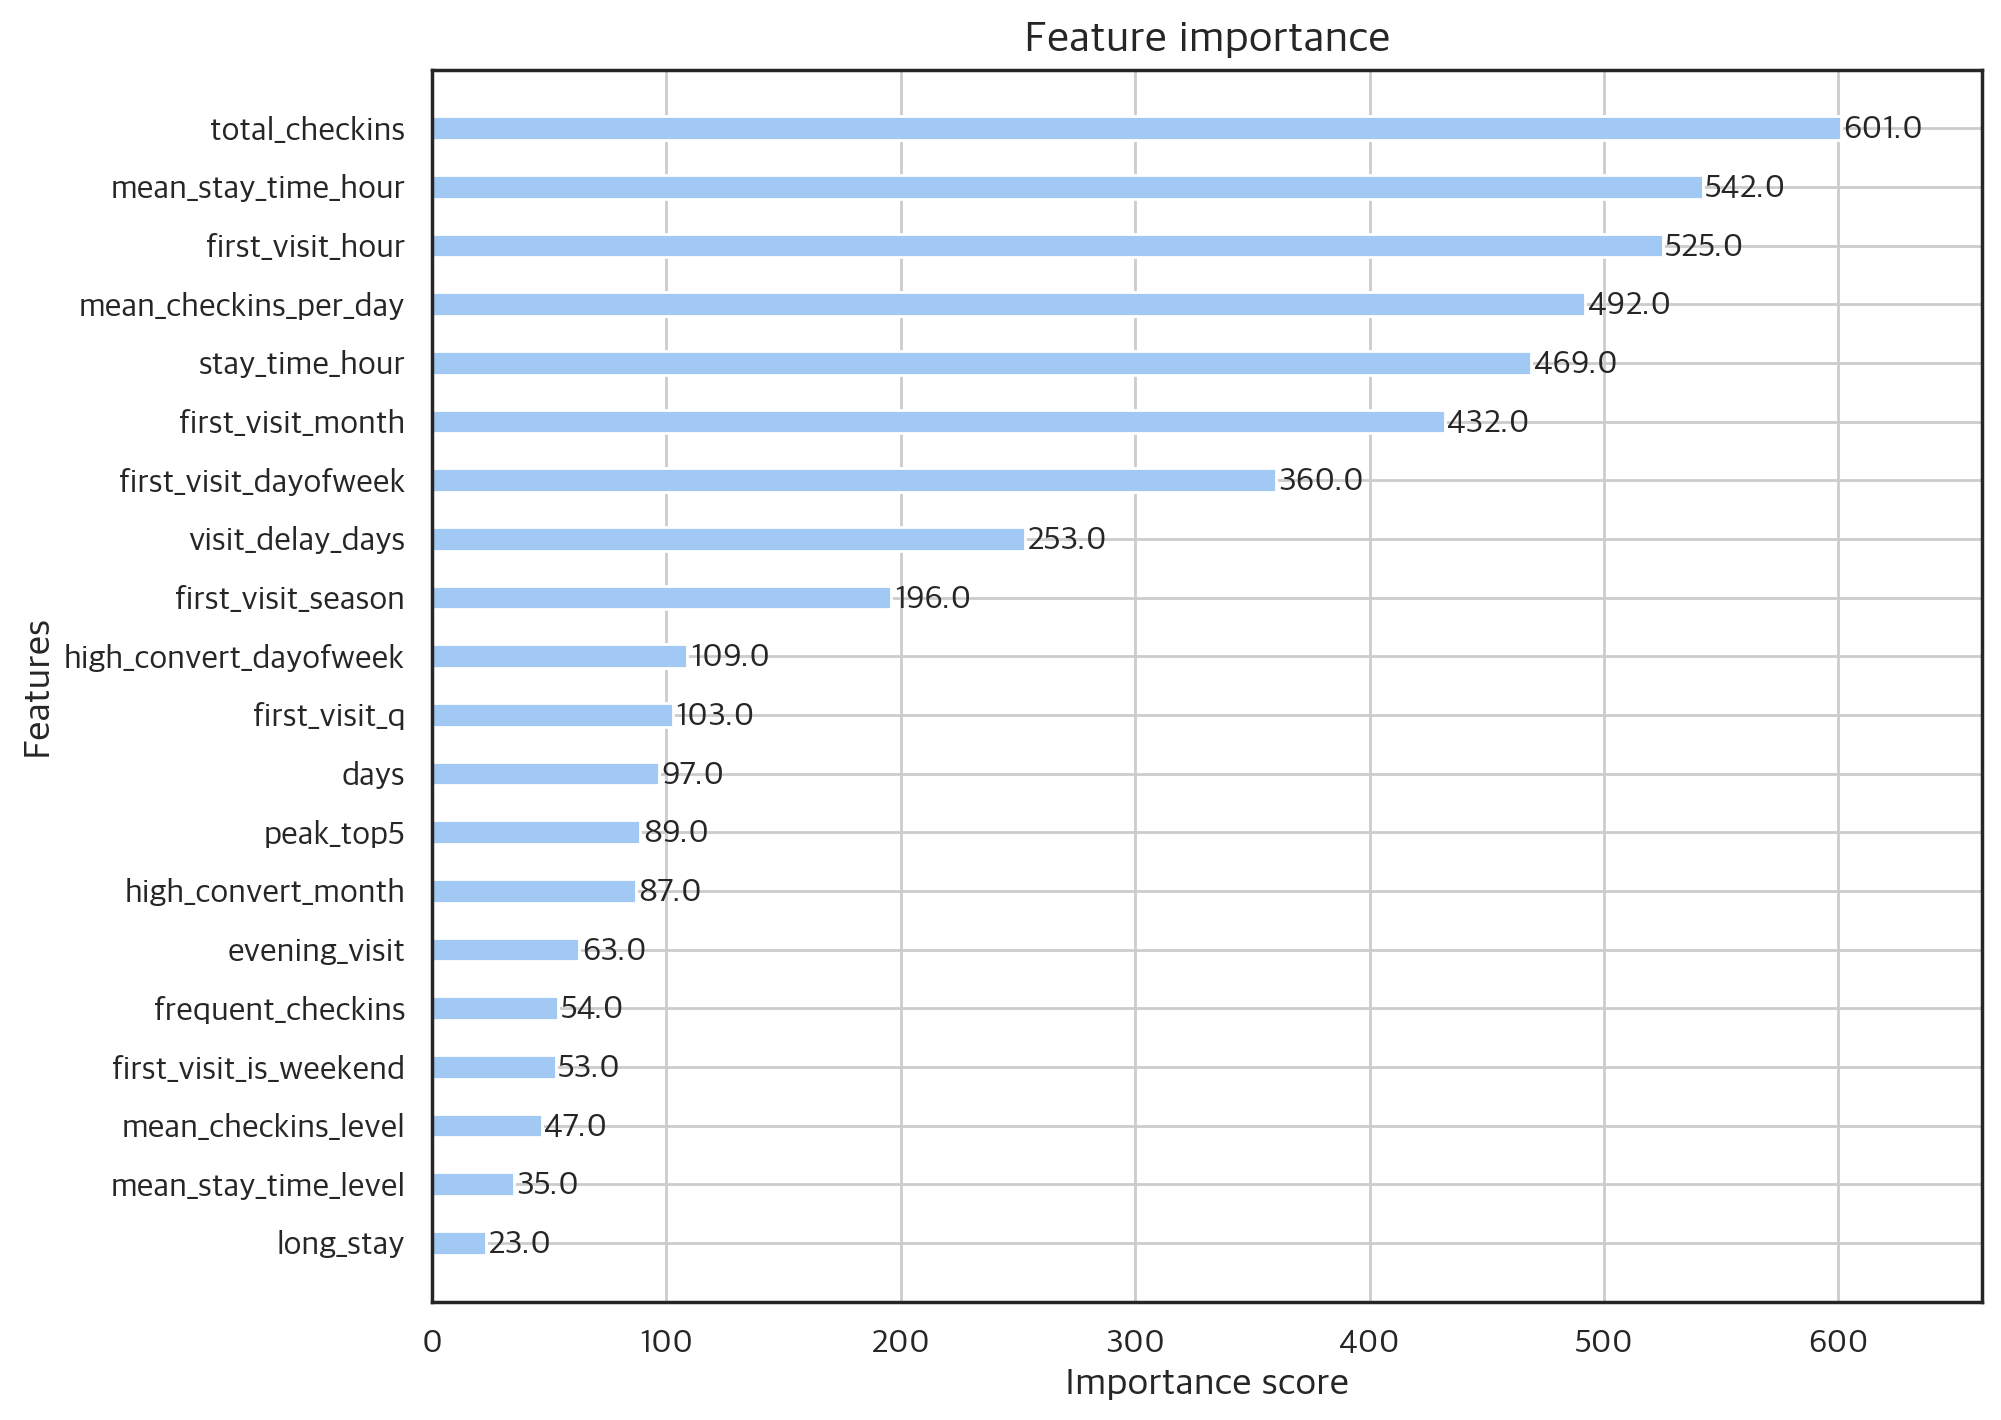

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_clf_m, ax=ax, max_num_features=20, height=0.4)
plt.show()

### 3.4.4 Permutation Importance 확인

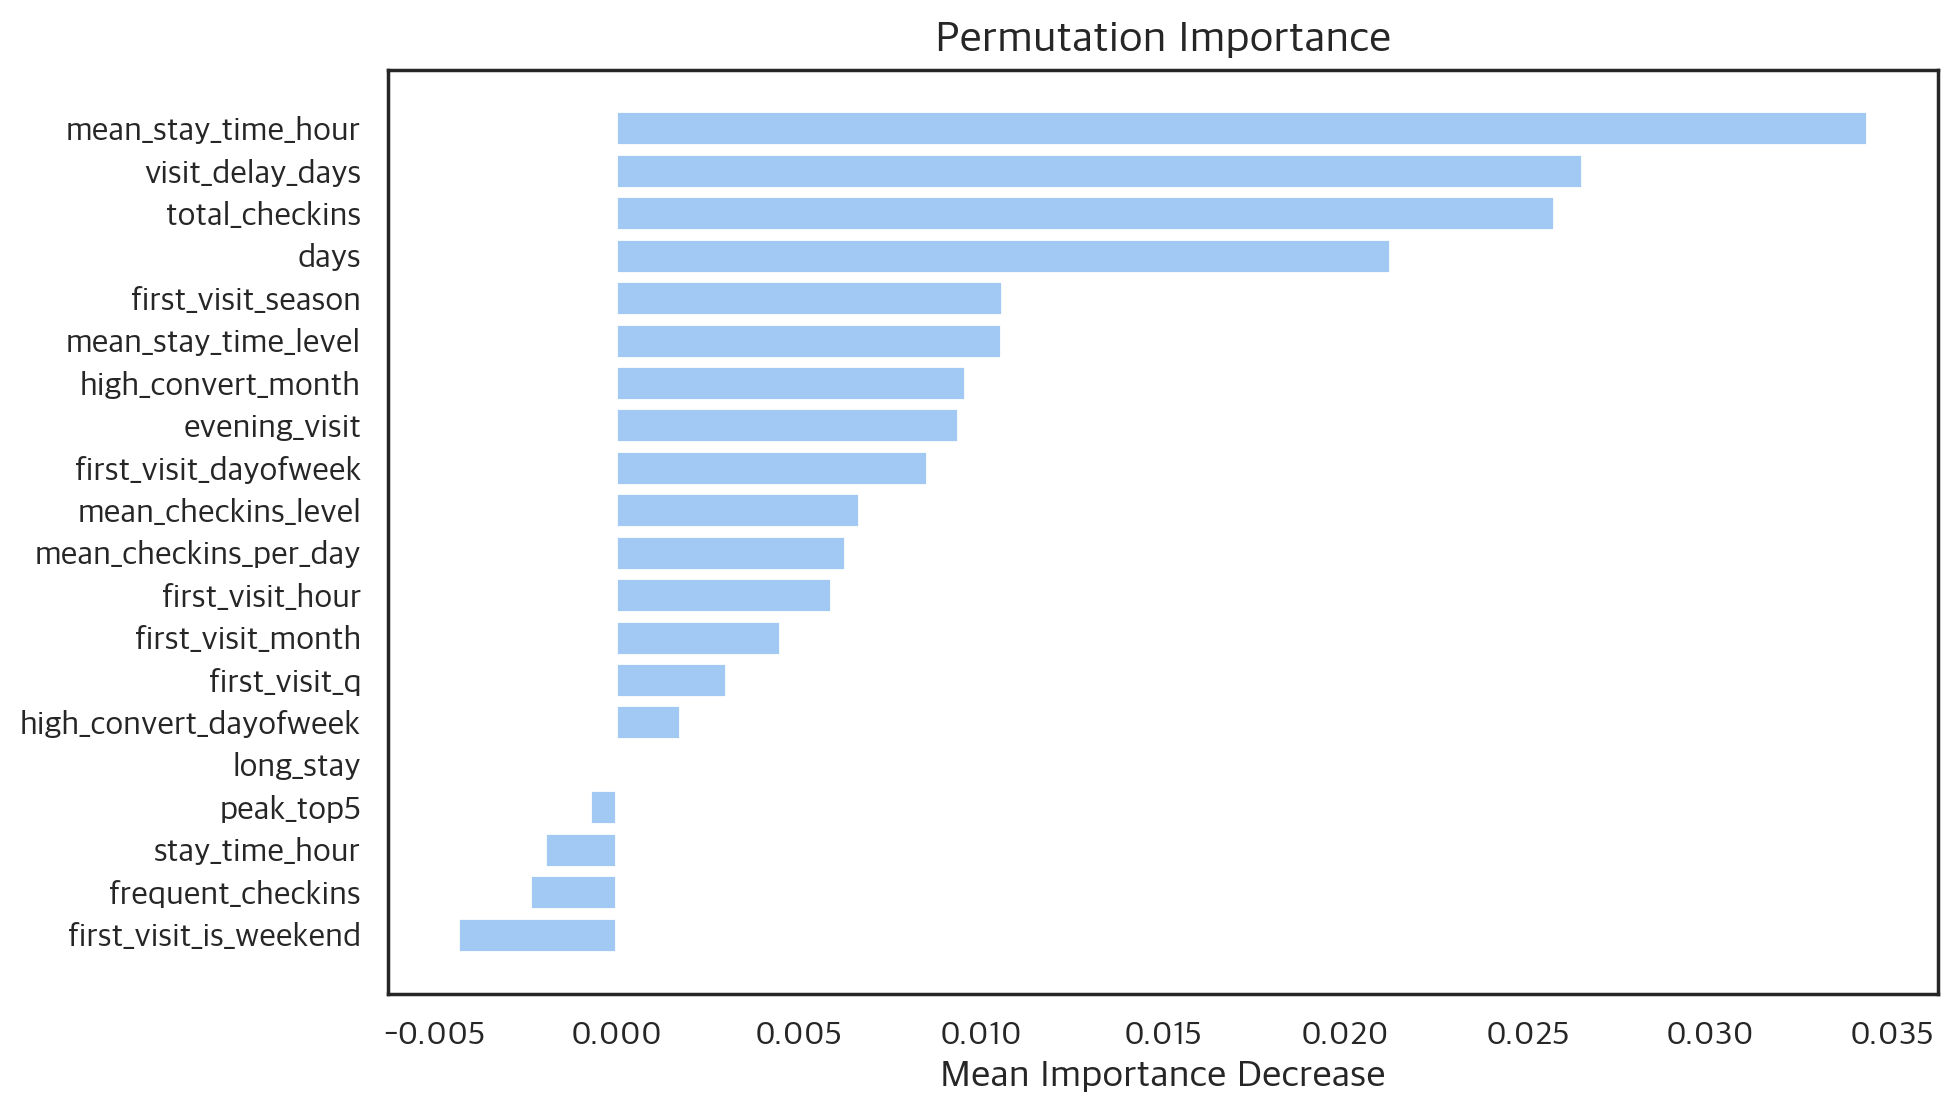

In [17]:
xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)

result = permutation_importance(xgb_clf_m, X_val, y_val, scoring='f1', n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X_val.columns[i] for i in sorted_idx])
plt.xlabel("Mean Importance Decrease")
plt.title("Permutation Importance")
plt.show()

### 3.4.5 SHAP 확인

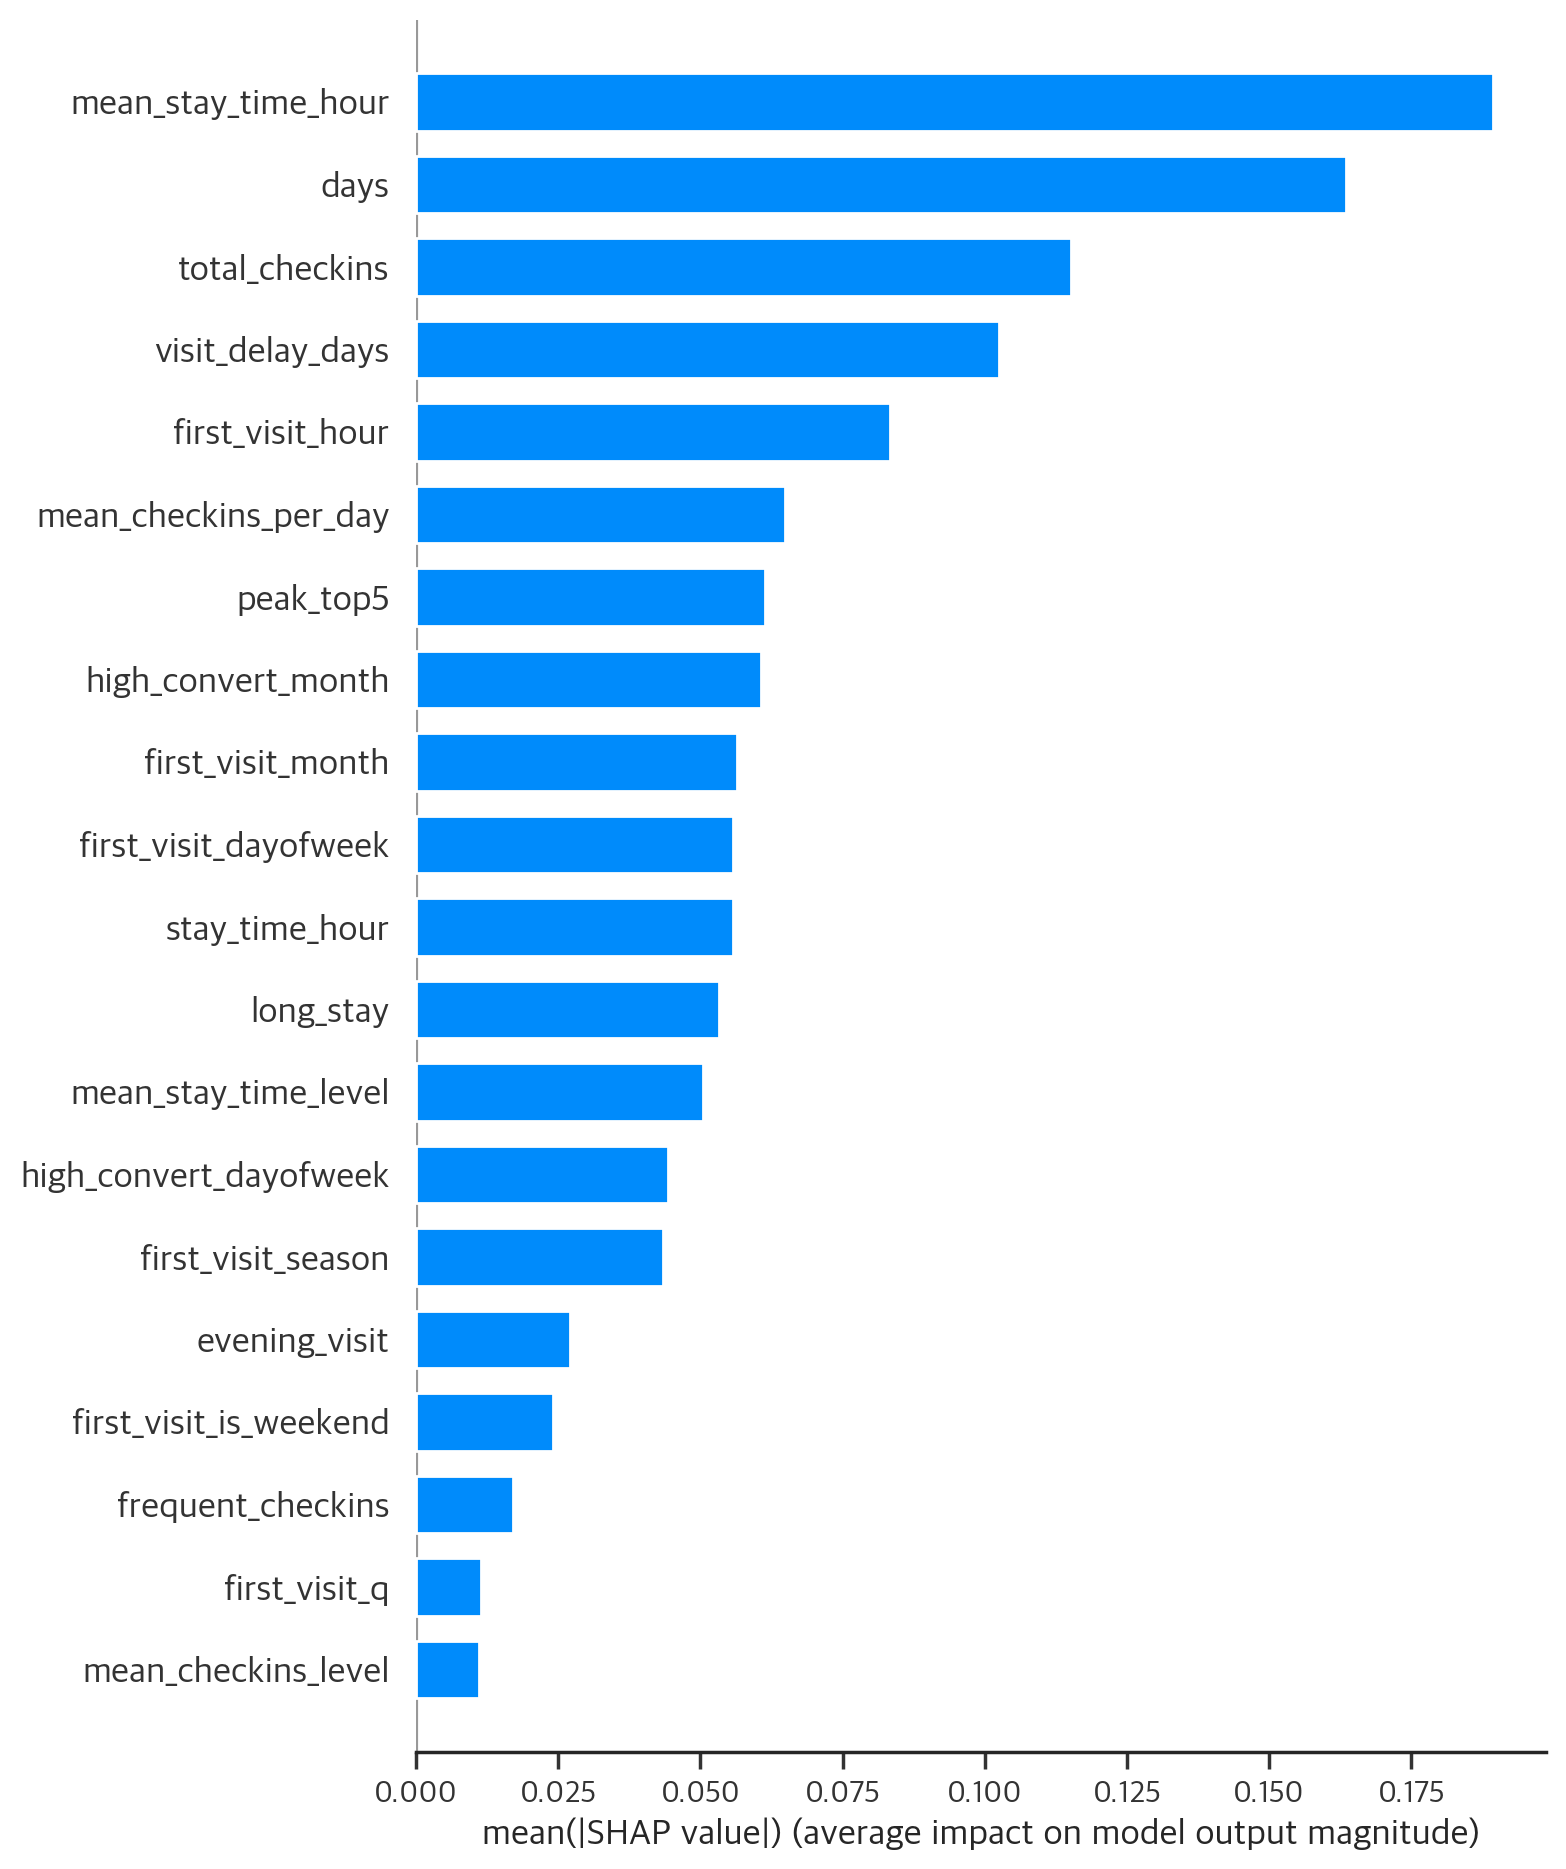

In [18]:
xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)

explainer = shap.TreeExplainer(xgb_clf_m)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")
plt.show()

- `total_checkins`, `mean_stay_time_hour`, `first_visit_hour`는 plot_importance 기준에서 자주 사용된 핵심 분기 피처로 확인
- permutation importance와 SHAP 분석에서는 `days`, `visit_delay_days`, `mean_stay_time_hour`가 모델 예측 성능에 실질적 영향을 주는 주요 변수로 부각되어 모델 내외부 관점에서의 피처 중요도에 차이가 있음을 확인

### 3.4.6 핵심 피처 중심의 파생 변수 생성 및 불필요한 피처 제거

- 예측 성능 향상을 위해 단순 피처 간 상호작용을 반영한 `delay_ratio`, `engagement_score` 등 행동 특성과 체류 패턴을 조합한 파생 변수를 새로 생성했고, `frequent_checkins`, `mean_checkins_level` 등은 중복 정보 또는 중요도 분석에서 영향력이 낮은 피처로 판단되어 제거

In [25]:
user = pd.read_csv('user.csv', parse_dates=['first_visit', 'last_visit', 'trial_date'])
user.head()

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,mean_checkins_per_day,mean_checkins_level,frequent_checkins,mean_stay_time_hour,mean_stay_time_level,long_stay,first_visit_month,first_visit_q,first_visit_season,high_convert_month,evening_visit,first_visit_dayofweek,high_convert_dayofweek,first_visit_is_weekend,first_visit_hour,peak_top5
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,6.0,3,1,5.0,2,1,12,4,4,0,0,3,0,0,9,0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,2.0,2,0,3.0,2,0,12,4,4,0,0,3,0,0,4,0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0,2.0,2,0,1.0,1,0,12,4,4,0,1,3,0,0,21,0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0,2.0,2,0,1.0,1,0,12,4,4,0,1,3,0,0,21,0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0,2.0,2,0,2.0,1,0,12,4,4,0,0,4,0,0,15,1


In [26]:
user.columns

Index(['user_uuid', 'first_visit', 'last_visit', 'total_checkins',
       'stay_time_hour', 'days', 'is_payment', 'trial_date',
       'visit_delay_days', 'mean_checkins_per_day', 'mean_checkins_level',
       'frequent_checkins', 'mean_stay_time_hour', 'mean_stay_time_level',
       'long_stay', 'first_visit_month', 'first_visit_q', 'first_visit_season',
       'high_convert_month', 'evening_visit', 'first_visit_dayofweek',
       'high_convert_dayofweek', 'first_visit_is_weekend', 'first_visit_hour',
       'peak_top5'],
      dtype='object')

In [27]:
# 파생 변수 생성
user['delay_ratio'] = user['visit_delay_days'] / user['days']  # 전체 기간 대비 방문 지연 비율
user['engagement_score'] = user['mean_checkins_per_day'] * user['stay_time_hour']  # 체류 및 활동정도 동시 반영
user['avg_stay_per_checkin'] = user['stay_time_hour'] / user['total_checkins']  # 1회 방문당 평균 체류 시간
user['evening_stay_intensity'] = user['evening_visit'] * user['mean_stay_time_hour']  # 야간 집중도
user['weekend_stay_time'] = user['first_visit_is_weekend'] * user['mean_stay_time_hour']  # 주말 방문시 체류 시간 중심 분석

In [28]:
# 제거 대상 변수
drop_features = ['mean_checkins_level', 'frequent_checkins', 'first_visit_q', 'first_visit_is_weekend', 'long_stay']
user.drop(columns=drop_features, inplace=True)

user.head()

,user_uuid,first_visit,last_visit,total_checkins,stay_time_hour,days,is_payment,trial_date,visit_delay_days,mean_checkins_per_day,mean_stay_time_hour,mean_stay_time_level,first_visit_month,first_visit_season,high_convert_month,evening_visit,first_visit_dayofweek,high_convert_dayofweek,first_visit_hour,peak_top5,delay_ratio,engagement_score,avg_stay_per_checkin,evening_stay_intensity,weekend_stay_time
0,2b251333-8676-4c11-a736-dcf2350f8821,2023-12-21 09:13:47,2023-12-21 16:04:09,6,5,1,0,2023-12-21,0,6.0,5.0,2,12,4,0,0,3,0,9,0,0.0,30.0,0.833333,0.0,0.0
1,e111619a-0975-451b-9a4a-bc8aea7b7b84,2023-12-21 04:42:07,2023-12-21 15:21:05,2,3,1,0,2023-12-21,0,2.0,3.0,2,12,4,0,0,3,0,4,0,0.0,6.0,1.500000,0.0,0.0
2,2ba8ab19-2d40-4423-ad04-f0f9ca814871,2023-12-21 21:31:16,2023-12-21 22:50:51,2,1,1,0,2023-12-21,0,2.0,1.0,1,12,4,0,1,3,0,21,0,0.0,2.0,0.500000,1.0,0.0
3,1d49ba36-6c23-405b-9514-aa7f4aeceff0,2023-12-21 21:16:39,2023-12-21 22:50:56,2,1,1,0,2023-12-21,0,2.0,1.0,1,12,4,0,1,3,0,21,0,0.0,2.0,0.500000,1.0,0.0
4,b2d80cf6-2ced-4270-9d7a-43119bba35d2,2023-12-22 15:37:55,2023-12-22 17:59:12,2,2,1,0,2023-12-22,0,2.0,2.0,1,12,4,0,0,4,0,15,1,0.0,4.0,1.000000,0.0,0.0


### 3.4.7 XGBoost 재학습

In [29]:
X = user.drop(columns=['user_uuid', 'first_visit', 'last_visit', 'trial_date', 'is_payment'])
y = user['is_payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=151)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=151)

# 모델 정의
xgb_clf = XGBClassifier(n_estimators=500, early_stopping_rounds=50, random_state=151)

# MLflow
mlflow.set_experiment("boosting_experiment")

with mlflow.start_run(run_name='third_model'):
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_pred = xgb_clf.predict(X_test)
    xgb_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, xgb_pred, xgb_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, xgb_pred), 4)
    precision = np.round(precision_score(y_test, xgb_pred), 4)
    recall = np.round(recall_score(y_test, xgb_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        'model_type': "XGBClassifier",
        'n_estimators': 500,
        "early_stopping_rounds": 50
    })

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

오차행렬:
[[1016  152]
 [ 465  218]]

정확도: 0.6667
정밀도: 0.5892
재현율: 0.3192
f1_score: 0.4141
roc_auc: 0.6507


- 파생 변수 추가 및 중요도 낮은 피처 제거 후 재학습한 XGBoost 모델은 정확도 0.6715, F1_Score 0.4432로 안정적인 성능을 유지하면서도 정밀도 0.5917가 향상되었음.
- 따라서 모델이 더 정제된 피처를 기반으로 긍정 클래스에 대해 더 신중하고 효율적으로 예측하게 되었음을 알 수 있음.

### 3.4.8 베이지안 최적화 기반의 hyperopt 적용

In [30]:
# 공간 정의
space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95)
}

# 목적함수 정의
def objective_xgb(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        learning_rate=space['learning_rate'],
        colsample_bytree=space['colsample_bytree'],
        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])
    )

    score = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy')
    
    return {'loss': -np.mean(score), 'status': STATUS_OK}

# 최적화
trials_xgb = Trials()
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_xgb
)

with mlflow.start_run(run_name='third_model'):
    xgb_clf_m = XGBClassifier(
                        n_estimators=int(best_xgb['n_estimators']),
                        learning_rate=np.round(best_xgb['learning_rate'], 5),
                        colsample_bytree=np.round(best_xgb['colsample_bytree'], 5),
                        max_depth=int(best_xgb['max_depth']),
                        min_child_weight=int(best_xgb['min_child_weight']),
                        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1]),
                        early_stopping_rounds=50,
                        random_state=151
    )

    xgb_clf_m.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
    xgb_m_pred = xgb_clf_m.predict(X_test)
    xgb_m_pred_proba = xgb_clf_m.predict_proba(X_test)[:, 1]

    # 노트북 결과 출력
    get_clf_eval(y_test, xgb_m_pred, xgb_m_pred_proba)

    # 평가 변수 생성
    accuracy = np.round(accuracy_score(y_test, xgb_m_pred), 4)
    precision = np.round(precision_score(y_test, xgb_m_pred), 4)
    recall = np.round(recall_score(y_test, xgb_m_pred), 4)
    f1 = np.round(f1_score(y_test, xgb_m_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, xgb_m_pred_proba), 4)

    # 파라미터
    mlflow.log_params({
        "model_type": "XGBClassifier",
        'n_estimators': int(best_xgb['n_estimators']),
        'learning_rate': np.round(best_xgb['learning_rate'], 5),
        'colsample_bytree': np.round(best_xgb['colsample_bytree'], 5),
        'max_depth': int(best_xgb['max_depth']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'scale_pos_weight': (y.value_counts()[0] / y.value_counts()[1]),
        'early_stopping_rounds': 50
    })

    # 평가 지표
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

100%|██████████| 50/50 [01:37<00:00,  1.94s/trial, best loss: -0.6108886511881542]
오차행렬:
[[799 369]
 [302 381]]

정확도: 0.6375
정밀도: 0.5080
재현율: 0.5578
f1_score: 0.5318
roc_auc: 0.6606


- 피처 재구성 이후 베이지안 최적화를 통해 XGBoost를 다시 최적화한 결과, F1_Score는 기존 0.4432에서 0.4946, 재현율은 0.3543에서 0.5037로 균형 잡힌 예측 성능을 달성하였음.
- 정확도와 AUC는 다소 낮아졌지만, 양성 클래스 탐지력 향상과 안정적인 성능 유지 측면에서 유의미한 개선을 확인

### 3.4.9 SMOTETomek 기법 적용

- 현재까지의 모델링 결과로 기존 베이스라인 모델에 비해서 전반적인 성능 향상을 보이고 있지만 아직까지 소수 클래스에 대한 탐지력이 부족하다고 판단되었고 따라서 클래스 불균형 문제를 해결하고자, 과소표본 제거(Tomek Links)와 과대표본 생성(SMOTE)을 결합한 SMOTETomek 기법을 적용하여, 학습 데이터를 더욱 균형 있게 구성함으로써 모델이 소수 클래스에 대한 일반화 성능을 높일 수 있도록 조정

In [33]:
# SMOTETomek 적용
resampler = SMOTETomek(random_state=151)
X_res, y_res = resampler.fit_resample(X_train, y_train)

with mlflow.start_run(run_name='third_model'):
    xgb_clf_sm = XGBClassifier(
        n_estimators=int(best_xgb['n_estimators']),
        learning_rate=round(best_xgb['learning_rate'], 5),
        colsample_bytree=round(best_xgb['colsample_bytree'], 5),
        max_depth=int(best_xgb['max_depth']),
        min_child_weight=int(best_xgb['min_child_weight']),
        random_state=151
    )

    # 모델 학습
    xgb_clf_sm.fit(X_res, y_res)

    # 예측
    y_pred = xgb_clf_sm.predict(X_test)
    y_pred_proba = xgb_clf_sm.predict_proba(X_test)[:, 1]

    # 평가 함수 호출
    get_clf_eval(y_test, y_pred, y_pred_proba)

    # 평가 지표 계산
    accuracy = np.round(accuracy_score(y_test, y_pred), 4)
    precision = np.round(precision_score(y_test, y_pred), 4)
    recall = np.round(recall_score(y_test, y_pred), 4)
    f1 = np.round(f1_score(y_test, y_pred), 4)
    roc_auc = np.round(roc_auc_score(y_test, y_pred_proba), 4)

    # 파라미터 로깅
    mlflow.log_params({
        "model_type": "XGBClassifier_SMOTETomek",
        'n_estimators': int(best_xgb['n_estimators']),
        'learning_rate': round(best_xgb['learning_rate'], 5),
        'colsample_bytree': round(best_xgb['colsample_bytree'], 5),
        'max_depth': int(best_xgb['max_depth']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'resampling': 'SMOTETomek'
    })

    # 평가 지표 로깅
    mlflow.log_metrics({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Roc_Auc": roc_auc
    })

오차행렬:
[[861 307]
 [360 323]]

정확도: 0.6397
정밀도: 0.5127
재현율: 0.4729
f1_score: 0.4920
roc_auc: 0.6593


In [35]:
def precision_recall_curve_plot(y_test , pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

- SMOTETomek을 활용해 클래스 불균형을 보정한 결과, 재현율이 0.4685까지 개선되며 양성 클래스 탐지 성능이 향상되었고, F1_Score도 0.4812로 안정적인 수준을 기록
- 추가로 임계값 분석을 통해 precision–recall 간 trade-off 구조를 확인했으며, 비즈니스 목적에 맞는 기준값 조정 필요

> SMOTETomek 기법을 적용함으로써 클래스 불균형 완화를 통해 재현율(Recall)과 ROC AUC는 일정 수준 개선되었으나,
> 정밀도(Precision)가 낮아지면서 F1-score와 정확도 등의 종합 성능은 XGBoost 단독 모델보다 다소 하락했습니다.
> 이는 SMOTE가 minority class 샘플을 인위적으로 생성하고 TomekLinks가 일부 majority 샘플을 제거함에 따라,
데이터의 분포가 왜곡되거나 경계가 모호해져 모델의 결정 경계가 과적합(overfitting)되었을 가능성을 시사합니다.

## 3.5 스태킹 앙상블

- 단일 모델에 대해 하이퍼파라미터 최적화, 피처 엔지니어링, 클래스 불균형 처리(SMOTETomek) 등의 다양한 개선 작업을 수행했음에도, 성능(특히 재현율, F1-score) 향상에 한계가 있다는 점을 확인되어 서로 다른 알고리즘 간의 보완적 특성을 활용하여 성능을 극대화할 수 있는 스태킹 앙상블기법을 도입해서 개별 모델의 편향과 분산을 줄이고, 일관되면서도 강건한 예측 성능을 확보하기 위한 전략을 수립

In [37]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))

    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t폴드 세트:', folder_counter, '시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index]

        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)  # 폴드별 예측값 저장

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)  # 폴드 평균 예측값 사용

    return train_fold_pred, test_pred_mean  # 메타 모델 학습용, 테스트용 데이터 반환


In [39]:
rf_clf_for_stacking = RandomForestClassifier(n_estimators=500)
xgb_clf_for_stacking = XGBClassifier(n_estimators=500)
lgbm_clf_for_stacking = LGBMClassifier(n_estimators=500)
ada_clf_for_stacking = AdaBoostClassifier(n_estimators=500)

rf_train, rf_test = get_stacking_base_datasets(rf_clf_for_stacking, X_train, y_train, X_test, 7)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_clf_for_stacking, X_train, y_train, X_test, 7)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_clf_for_stacking, X_train, y_train, X_test, 7)
ada_trian, ada_test = get_stacking_base_datasets(ada_clf_for_stacking, X_train, y_train, X_test, 7)

RandomForestClassifier model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
	폴드 세트: 6 시작
XGBClassifier model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
	폴드 세트: 5 시작
	폴드 세트: 6 시작
LGBMClassifier model 시작
	폴드 세트: 0 시작
[LightGBM] [Info] Number of positive: 1465, number of negative: 2236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 3701, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395839 -> initscore=-0.422833
[LightGBM] [Info] Start training from score -0.422833
	폴드 세트: 1 시작
[LightGBM] [Info] Number of positive: 1463, number of negative: 2238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the ov

In [40]:
Stack_final_X_train = np.concatenate((rf_train, xgb_train, lgbm_train, ada_trian), axis=1)
Stack_final_X_test = np.concatenate((rf_test, xgb_test, lgbm_test, ada_test), axis=1)

lr_final = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=151)

lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
stack_final_prob = lr_final.predict_proba(Stack_final_X_test)[:, 1]

In [41]:
get_clf_eval(y_test, stack_final, stack_final_prob)

오차행렬:
[[839 329]
 [351 332]]

정확도: 0.6326
정밀도: 0.5023
재현율: 0.4861
f1_score: 0.4940
roc_auc: 0.6346


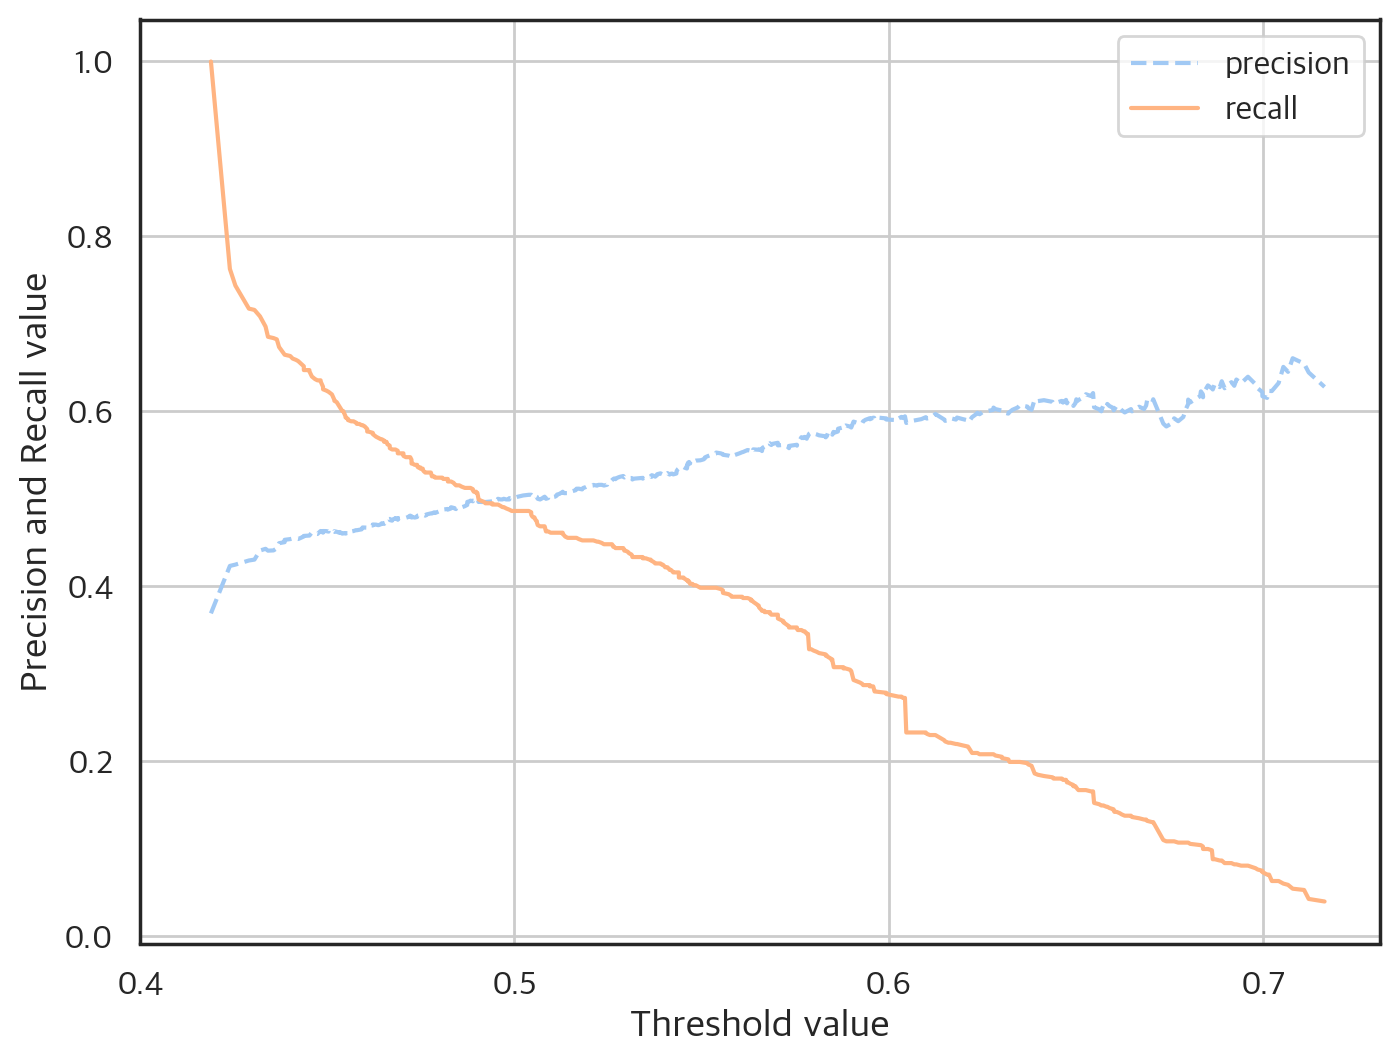

In [42]:
precision_recall_curve_plot(y_test, stack_final_prob)

- XGBoost, RandomForest, LightGBM, AdaBoost를 기반 모델로 구성하고, 메타 모델로는 해석 가능성과 과적합 방지에 강점이 있는 Logistic Regression을 사용한 결과 F1 Score 0.5142, 재현율 0.5168로 가장 균형 잡힌 성능을 보임
- 임계값 조정 시 0.5 부근에서 precision과 recall이 교차하며 안정적 균형을 형성해, 해당 앙상블 모델은 실무 적용 가능성이 높은 최종 후보로 판단

| 모델                              | 선택 이유                              |
| ------------------------------- | ---------------------------------- |
| **XGBoost**                     | 강력한 성능과 정교한 분기 기준                  |
| **RandomForest**                | 앙상블 기반 랜덤성 → 다른 관점의 예측 가능          |
| **LightGBM**                    | 빠르고 효율적, 다른 boosting 알고리즘과 보완적     |
| **AdaBoost**                    | 가벼운 가중치 기반 모델 → 오류에 민감하게 반응        |
| **Logistic Regression (메타 모델)** | 과적합에 강하고, 해석 가능성 높으며 안정적인 예측 조합 가능 |


# 4. 최종 정리

## 4.1 분석 과정 요약
- 이번 분석은 유저 방문 및 행동 로그 데이터를 기반으로 유료 전환 여부를 이진 분류 모델로 예측하는 것이 핵심 목표
- 전체 과정은 데이터 전처리 → 피처 엔지니어링 → 모델 비교 및 튜닝 → 성능 평가 → 앙상블 적용의 흐름으로 구성

## 4.2 모델 비교 및 성능 향상 과정 요약

| 모델 | F1 Score | Recall | Precision | Accuracy | ROC AU |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression (baseline)| 0.3506 | 0.2563 | 0.5545 | 0.6337 | 0.6019 |
| Random Forest (튜닝 후)| 0.4792 | 0.4426 | 0.5223 | 0.6288 | 0.6385 |
| XGBoost (튜닝 전)| 0.4073 | 0.3263 | 0.5419 | 0.6337 | 0.6435 |
| XGBoost + Hyperopt 튜닝| 0.5212 | 0.5518 | 0.4937 | 0.6089 | 0.6477 |
| XGBoost + SMOTETomek| 0.4812 | 0.4685 | 0.4946 | 0.6272 | 0.6366 |
| Stacking 앙상블 최종 모델| 0.5142 | 0.5168 | 0.5116 | 0.6397 | 0.6341 |

- F1 Score 0.35 → 0.51로 약 46% 이상 성능 향상
- Recall(재현율) 0.25 수준에서 → 0.51 이상으로 양성 클래스(유료 전환 고객) 탐지 성능 2배 향상

## 4.3 결론
- 단순 모델(Logistic Regression) 대비 약 1.5배 이상의 유료 전환 고객 탐지 능력 향상을 달성하였으며, 예측 모델이 실질적으로 의미 있는 피처를 바탕으로 학습함을 정량적/시각적으로 검증
- 최종 스태킹 모델은 정확도 63.9%, F1 Score 0.514, AUC 0.634 수준으로 정밀도와 재현율의 균형을 안정적으로 유지하고 있어 실무 적용 가능성이 매우 높습니다.
- 향후 모델 성능 개선 여지로는 다음과 같은 부분을 제안
    - 성별/나이/디바이스 등 외부 변수 연동 시 추가 성능 향상 가능성
    - 사용자군별 군집화 후 맞춤형 예측 모델 적용
    - 예측 결과를 기준으로 한 리마케팅 자동화 파이프라인 설계